## Band classification of IELTS writing task 2

## Introduction

Writing is one of the hardest skills to improve in a new language learning process. There are several GPT tools that we can leverage to improve the writing level. However, a formal evaluation tool is mandatory when a student is preparing for a standardized test. Beyond the skills evaluated in the different tests, the student also needs the result of the task to check if the desired outcome was achieved. The present project presents a prototype of a band classifier from given instructions and responses of the IELTS writing task 2. The aim of this project is to show the student the band of their essay, given the instructions and the essay.

## 1. Definition of the Dataset

The present dataset comes from the Kaggle ['IELTS Writing Scored Essays Dataset'](https://www.kaggle.com/datasets/mazlumi/ielts-writing-scored-essays-dataset/data). The first step is to load the dataset and check its information

In [1]:
# Importing libraries
import pandas as pd
from collections import Counter
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

import spacy
from spacy.tokens import Doc

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Embedding, Input, Dense, Dropout, LSTM, Bidirectional, GlobalMaxPooling1D, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer, TFBertModel, TFBertForSequenceClassification

In [2]:
# CPU-specific optimizations
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TensorFlow logging
tf.config.threading.set_intra_op_parallelism_threads(0)  # Use all available CPU cores
tf.config.threading.set_inter_op_parallelism_threads(0)  # Use all available CPU cores

# Disable GPU if accidentally detected
tf.config.set_visible_devices([], 'GPU')

In [3]:
# Loading the dataset
df = pd.read_csv('ielts_writing_dataset.csv', header=0)
# Getting some info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1435 entries, 0 to 1434
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Task_Type           1435 non-null   int64  
 1   Question            1435 non-null   object 
 2   Essay               1435 non-null   object 
 3   Examiner_Commen     62 non-null     object 
 4   Task_Response       0 non-null      float64
 5   Coherence_Cohesion  0 non-null      float64
 6   Lexical_Resource    0 non-null      float64
 7   Range_Accuracy      0 non-null      float64
 8   Overall             1435 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 101.0+ KB


As it was stated before, the input for the classifier is the question and the essay. In addition, the result is also needed.

In [4]:
# Filtering the necessary columns
df_filtered = df[df['Task_Type'] == 2][['Question','Essay','Overall']]
df_filtered

,Question,Essay,Overall
1,Rich countries often give money to poorer coun...,Poverty represents a worldwide crisis. It is t...,6.5
3,Rich countries often give money to poorer coun...,Human beings are facing many challenges nowada...,5.5
5,Some countries achieve international sports by...,Whether countries should only invest facilitie...,6.5
7,Some countries achieve international sports by...,"Sports is an essential part to most of us , so...",5.5
9,Some countries achieve international sports by...,International sports events require the most w...,9.0
...,...,...,...
1430,Without capital punishment our lives are less ...,Serious crimes need capital punishment so that...,5.0
1431,Some people think that they can learn better b...,It is certainly said that learning is an ongoi...,5.0
1432,Nowadays people like to change their day by da...,popular hobbies rather than their individual a...,5.0
1433,Universities should allocate the same amount o...,"Yes, I do feel that universities should have a...",5.0


The score from the database is defined on ranges. A conversion to equivalence with bands is performed. Here is the table of equivalences of the ranges found in the data.

| Overall       | Band | Label |
|-------        |----- |-------|
|  0   - 3.99   | A    |   0   |
| 4.00 - 5.49   | B1   |   1   |
| 5.50 - 6.99   | B2   |   2   |
| 7.00 - 8.49   | C1   |   3   |
| 8.50 - 9.00   | C2   |   4   |

In [5]:
# Convert the column to work with float
df_filtered['Overall'] = df_filtered['Overall'].astype(float)

# Create bins for the 'Overall' column.
df_filtered['Overall_band'] = pd.cut(df_filtered['Overall'], 
                                     bins=[min(df_filtered['Overall'])-0.01, 3.99, 5.49, 6.99, 8.49, max(df_filtered['Overall'])+0.01], 
                                     labels=[0, 1, 2, 3, 4]).astype(int)

# Drop the column Overall, it is not needed anymore
df_filtered.drop('Overall', axis=1, inplace=True)

After the transformation, the data is ready to the visualization step

## 2. Visualization of the Dataset Features and Results

Lets visualize the overall band to see the amount of results per band.

In [7]:
# Function to plot a pie chart
def plot_piechart(labels, data, colors, title, size):
    plt.figure(figsize=size)
    plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title(title)
    plt.show()

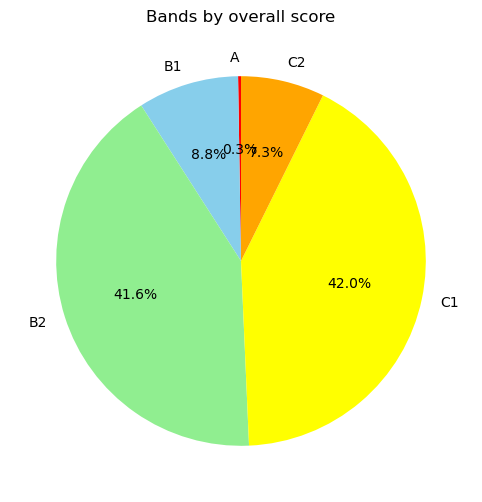

In [20]:
# Plotting the Overall_band distribution
labels = ['A','B1','B2','C1','C2']
plot_piechart(labels, df_filtered.groupby(['Overall_band']).size(),
             ['red', 'skyblue', 'lightgreen', 'yellow', 'orange'], 'Bands by overall score',
             (10,6))

The number of students in the A band is marginal compared with the rest. This part of the dataset will be removed. In addition, B1 and C2 bands have a non-significant number of results. The bands will be joined, and the classification will cover only two classes: the B and C bands.\
Due to the A band being dropped, the bands will be relabeled. The B band will be 0, and C will be 1.

In [6]:
df_band = df_filtered.copy()

# Taking out the A band
df_band.drop(df_band[df_band['Overall_band'] == 0].index, inplace=True)
# Changing the B's and C's values
df_band['Overall_band'] = df_band['Overall_band'].replace({1: 0, 2: 0, 3: 1, 4: 1})

After the change, a new chart is displayed to check the results.

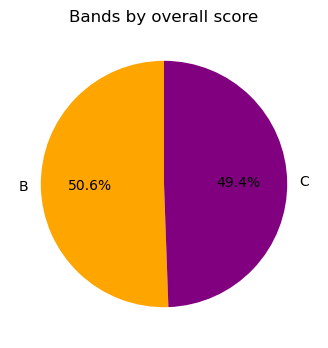

In [7]:
labels = ['B','C']
# Diplaying the new distribution
plot_piechart(labels, df_band.groupby(['Overall_band']).size(),
             ['orange', 'purple'], 'Bands by overall score',
             (10,4))

The classes are balanced now and will enhance the quality of the classification. Let's compare two answers from different bands but on the same question.

In [7]:
df_band.iloc[3:5,:]

,Question,Essay,Overall_band
7,Some countries achieve international sports by...,"Sports is an essential part to most of us , so...",0
9,Some countries achieve international sports by...,International sports events require the most w...,1


In [23]:
# Defining a function to generate Word Cloud
def wordcloud_plot(figsize, bck_color, file_content, title):
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color=bck_color, collocations=False).generate(' '.join(file_content))

    # Display the generated word cloud
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontdict = {'fontsize' : 30})
    plt.axis('off')  # Remove axes
    plt.show()

First, the question is going to be plotted to check what is it about.

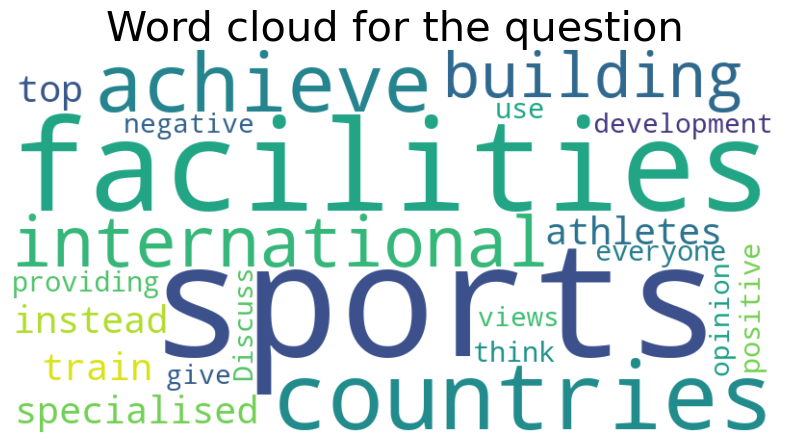

In [11]:
# Wordcloud for the question
data = df_band.iloc[3, 0]
data = data.split('.')

wordcloud_plot((10, 5), 'white', data, 'Word cloud for the question')

The words 'sports', 'facilities', and 'countries' are dominant. Lets see the word cloud for both answers.

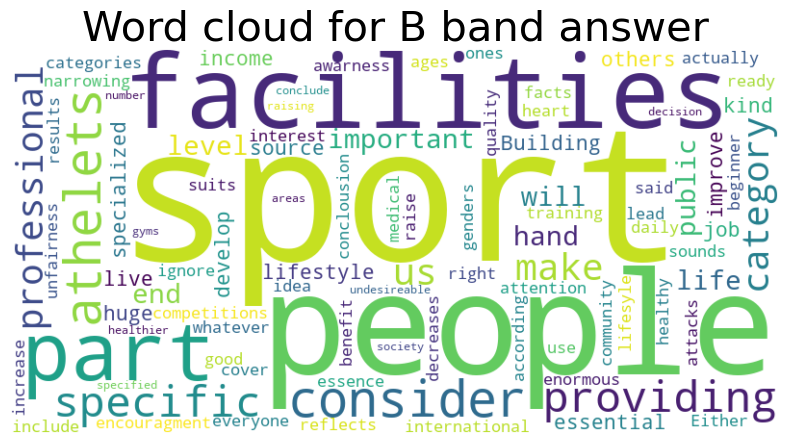

In [13]:
# Wordcloud for the answer in B band
data = df_band.iloc[3, 1]
data = data.split('.')

wordcloud_plot((10, 5), 'white', data, 'Word cloud for B band answer')

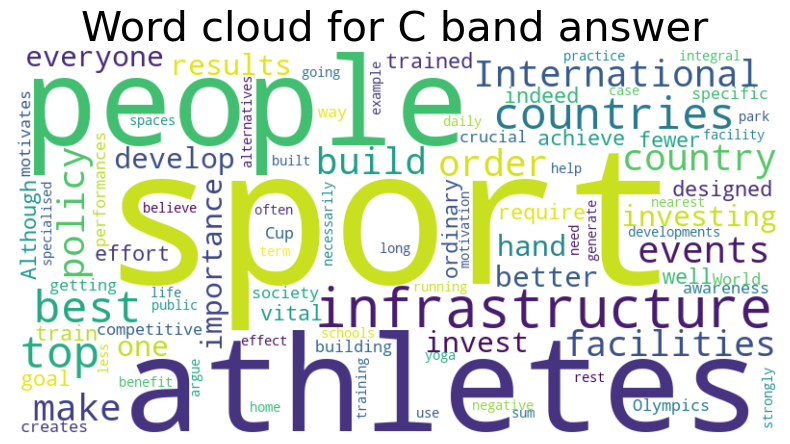

In [14]:
# Wordcloud for the answer in C band
data = df_band.iloc[4, 1]
data = data.split('.')

wordcloud_plot((10, 5), 'white', data, 'Word cloud for C band answer')

Word plot for C band looks consistent. It uses fewer words, but they have the same size throughout the plot. On the other hand, the answer in the B band uses many more words, but they show a decrease in size and are more spread over the cloud. In addition, skimming through the plot, the vocabulary in C cloud is more refined than in the B cloud.

## 3. Cleaning the Text Data with One Approach

To evaluate an answer in IELTS writing task, four parameters are considered:
1. Task Response 
2. Coherence & Cohesion 
3. Lexical Resource 
4. Grammatical Range & Accuracy

To completely leverage the text from the question and answer, no cleaning task will be performed. The regular pipeline with the reason is listed below:
- **Lowercasing:** Grammatically speaking, words with upper and lowercase must be considered in the analysis. For instance, 'apple' and 'Apple' are different and have an impact on all four parameters.
- **Punctuation:** This is part of correct writing. Correct punctuation in parameters 2 and 4.  
- **Numbers:** Use of numbers impacts the final score. The reviewers consider the correct use of 'four' and '4'.
- **Special characters:** Correct use of special characters makes the difference between bands. The correct use of colons and semicolons in compound sentences makes the difference between a B and C levels.



All the questions and essays will be joined to form the input data. After this, the input is tokenized and the vocabulary was gotten from the input.

In [8]:
# Combine task and answer
texts = (df_band['Question'] + " " + df_band['Essay']).tolist()

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# Calculate vocabulary size (add 1 for padding token at index 0)
vocab_size = len(word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Pad the sequences
X = pad_sequences(sequences, maxlen=20, padding='post')
y = df_band['Overall_band']

Vocabulary size: 11674


Then, the data must be splitted into training and test sets.

In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

At this point, the input is processed and ready to be input to the neural networks.

## 4. Implementation of Three Different Neural Networks

### Method 1 - FFNN

The first network is a classic Feed Forward Neural Network. This is going to be the benchmark for the project. The process to build the network is the following:
- An embedding layer process and gets the data representation for the FFNN model
- The output layer is sigmoid for binary classification (0 for B and 1 for C)
- A custom training method is created to track the gradient change.

In [10]:
# Subclassed that defines an FFNN model
class CustomFFNNModel(Model):
    # Constructor
    def __init__(self, vocab_size, max_length=20, penalty_d1=0.01, penalty_d2=0.01, dropout_d1=0.3, dropout_d2=0.3):
        super(CustomFFNNModel, self).__init__()
        # Embedding layer        
        self.embedding = Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length)
        # Flatten layer to convert 3D to 2D for dense layers
        self.flatten = tf.keras.layers.Flatten()
        # Layers definition
        self.dense1 = Dense(32, activation='relu', kernel_regularizer=l2(penalty_d1))
        self.drop1 = Dropout(dropout_d1)
        self.dense2 = Dense(16, activation='relu', kernel_regularizer=l2(penalty_d2))
        self.drop2 = Dropout(dropout_d2)
        self.output_layer = Dense(1, activation='sigmoid')
        # Gradient norms list
        self.gradient_norms = []
        self.current_step = tf.Variable(0, trainable=False, dtype=tf.int64)

    # Builder of the model
    def call(self, inputs, training=None):
        x = self.embedding(inputs)
        x = self.flatten(x)
        x = self.drop1(self.dense1(x), training=training)
        x = self.drop2(self.dense2(x), training=training)
        return self.output_layer(x)

    # Method to train the mdoel
    def train_step(self, data):
        # Split the input and label
        x, y = data

        # Calculates the gradients
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
    
        gradients = tape.gradient(loss, self.trainable_variables)
        non_none_gradients = [g for g in gradients if g is not None]

        # Calculate gradient norm but don't store it during graph execution
        # Callback will be used to track this instead
        if non_none_gradients:
            norm = tf.linalg.global_norm(non_none_gradients)
            # Just increment step counter during training
            self.current_step.assign_add(1)
        
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
    
        return {m.name: m.result() for m in self.metrics}

In [11]:
# Custom callback to track gradient norms
class GradientNormCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.gradient_norms = []
        
    def on_train_batch_end(self, batch, logs=None):
        # Calculate gradient norms in eager mode
        if hasattr(self.model, 'current_step'):
            # Simple approximation: use loss as gradient indicator
            if logs and 'loss' in logs:
                # Store loss as a proxy for gradient behavior
                self.gradient_norms.append(logs['loss'])
    
    def plot_norms(self, model_text):
        if self.gradient_norms:
            plt.figure(figsize=(6, 4))
            plt.plot(self.gradient_norms)
            plt.xlabel('Batch')
            plt.ylabel('Loss (Gradient Proxy)')
            plt.title(f'{model_text} training Loss over Batches')
            plt.grid(True, alpha=0.3)
            plt.show()
        else:
            print("No gradient data recorded.")

A function to add optimizers to the models is going to be created. The three chosen are the following:
- **Adam:** The default choice optimizer for neural networks with classification tasks.
- **AdamW:** Ideal for the present project, in which a custom BERT model and better generalization are current goals.
- **SGD with momentum:** Momentum accelerates learning in consistent directions and reduces noise in updates for text tasks.

In [12]:
# Function to create the optimizers
def get_optimizer(optimizer, hyperprm):
    if optimizer == 'AdamW':
        return AdamW(learning_rate=hyperprm[0], weight_decay=hyperprm[1], beta_1=hyperprm[2], 
                     beta_2=hyperprm[3], epsilon=hyperprm[4], clipvalue=hyperprm[5])
    elif optimizer == 'SGDM':
        return SGD(learning_rate=hyperprm[0], momentum=hyperprm[1], nesterov=hyperprm[2],
                   clipvalue=hyperprm[3])
    else: # return Adam by default
        return Adam(learning_rate=hyperprm[0], beta_1=hyperprm[1], beta_2=hyperprm[2], 
                    epsilon=hyperprm[3])

#### Method 1 - FFNN - Optimizer 1 - Adam

Adam is the first choice optimizer. The parameters are the mostly used for this kind of tasks. To get the Norm of the Gradient over time, it is necessary to define the callback function to save and plot them.

In [ ]:
# Instantiate the model
model_ffnn_adm = CustomFFNNModel(vocab_size=vocab_size, max_length=20)
# Create the optimizer
optimizer_ffnn_adm = get_optimizer('Adam', [1e-3, 0.9, 0.999, 1e-8])
# Compile the model
model_ffnn_adm.compile(optimizer=optimizer_ffnn_adm,
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

The next step is to train the model. The callback is defined to add the model an early stopping and adjust the learning rate if this stops from improving. The gradient callback tracks the magnitude of gradients over the epochs.

In [ ]:
# CPU-friendly callbacks with gradient tracking
gradient_callback = GradientNormCallback()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    gradient_callback
]

# Train the model with CPU-optimized settings
print("Starting training...")
history_ffnn_adm = model_ffnn_adm.fit(
    X_train, y_train,
    epochs=30,  
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1,
    workers=1,  
    use_multiprocessing=False 
)

Starting training...
Epoch 1/30
16/16 [==============================] - 1s 23ms/step - loss: 1.3618 - accuracy: 0.4970 - val_loss: 1.1962 - val_accuracy: 0.6063 - lr: 0.0010
Epoch 2/30
16/16 [==============================] - 0s 7ms/step - loss: 1.0871 - accuracy: 0.6950 - val_loss: 0.9966 - val_accuracy: 0.6063 - lr: 0.0010
Epoch 3/30
16/16 [==============================] - 0s 10ms/step - loss: 0.9262 - accuracy: 0.8139 - val_loss: 0.8912 - val_accuracy: 0.5827 - lr: 0.0010
Epoch 4/30
16/16 [==============================] - 0s 8ms/step - loss: 0.8275 - accuracy: 0.8851 - val_loss: 0.8394 - val_accuracy: 0.5591 - lr: 0.0010
Epoch 5/30
16/16 [==============================] - 0s 7ms/step - loss: 0.7311 - accuracy: 0.9703 - val_loss: 0.8126 - val_accuracy: 0.5669 - lr: 0.0010
Epoch 6/30
16/16 [==============================] - 0s 7ms/step - loss: 0.5955 - accuracy: 0.9960 - val_loss: 0.7997 - val_accuracy: 0.5669 - lr: 0.0010
Epoch 7/30
16/16 [==============================] - 0s 8ms/

In [53]:
# Show the summary of the model
model_ffnn_adm.summary()

Model: "custom_ffnn_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  747136    
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  40992     
                                                                 
 dropout_6 (Dropout)         multiple                  0         
                                                                 
 dense_10 (Dense)            multiple                  528       
                                                                 
 dropout_7 (Dropout)         multiple                  0         
                                                                 
 dense_11 (Dense)            multiple          

Finally, the metrics of the model are displayed. First, the performance metrics for classification (including confusion matrix):

In [13]:
# Function to print the metrics of a classifier
def get_metrics(model, data_test, labels_test, model_text, show_metrics = True):
    # Evaluating the model
    test_predictions = model.predict(data_test, verbose=1)
    test_predictions_binary = (test_predictions > 0.5).astype(int).flatten()
    
    # Calculate metrics
    accuracy = accuracy_score(labels_test, test_predictions_binary)
    precision = precision_score(labels_test, test_predictions_binary)
    recall = recall_score(labels_test, test_predictions_binary)
    f1 = f1_score(labels_test, test_predictions_binary)

    if show_metrics:
        print(f"\nMetrics for {model_text}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

    return test_predictions_binary, [accuracy, precision, recall, f1]

In [62]:
# Print the metrics of the model using the previous function
y_pred_ffnn_adm, metrics_ffnn_adm = get_metrics(model_ffnn_adm, X_test, y_test,
                                                  'FFNN with Adam Optimizer')

5/5 [==============================] - 0s 7ms/step

Metrics for FFNN with Adam Optimizer:
Accuracy: 0.6352
Precision: 0.6528
Recall: 0.5875
F1 Score: 0.6184


In [14]:
# Function to plot the confusion matrix
def plot_confusion_matrix(target_names, cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

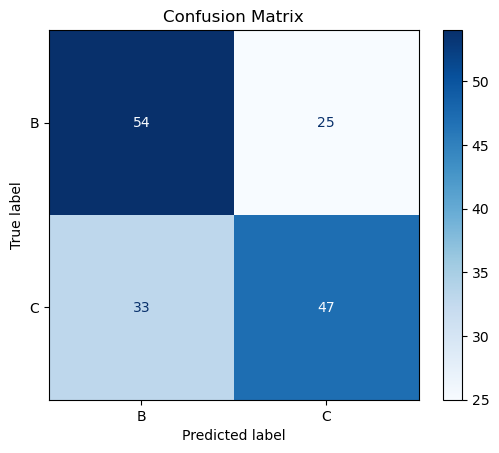

In [63]:
labels = ['B','C']
# Calculate the confusion matrix
cm_ffnn_adm = confusion_matrix(y_test, y_pred_ffnn_adm)
# Plot the confusion matrix using the defined function
plot_confusion_matrix(labels, cm_ffnn_adm)

The second information to get of the model is the plot of the loss and the gradient tracking:

In [15]:
# Plot training history
def plot_training_history(history, model_text):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title(f'{model_text} Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax2.set_title(f'{model_text} Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

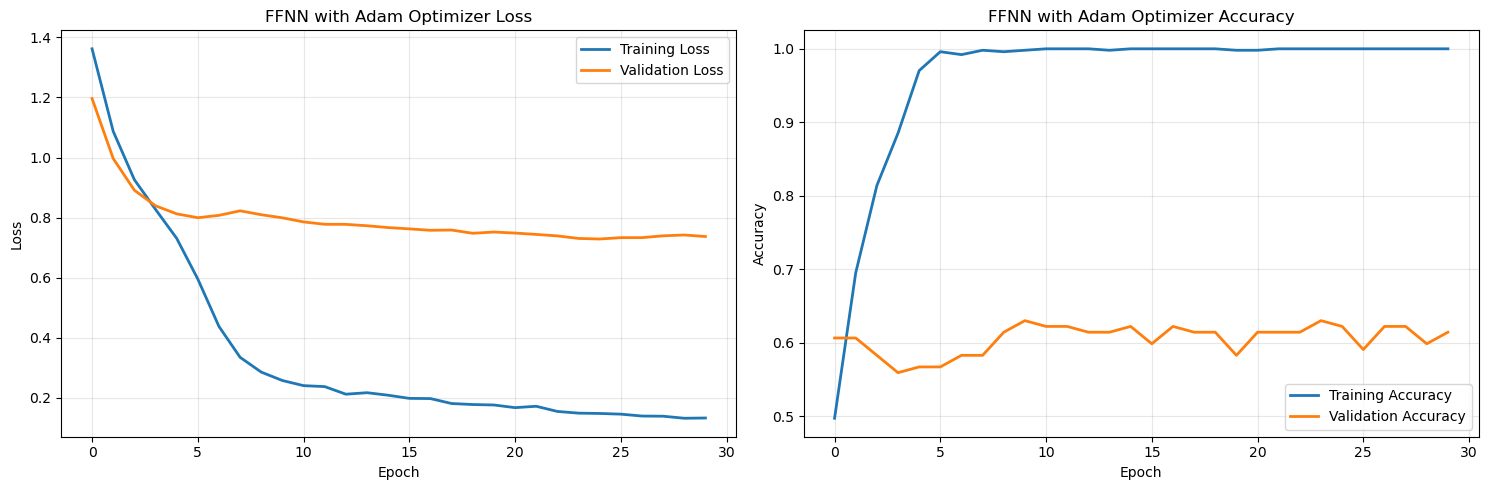

In [64]:
# Plot training history
plot_training_history(history_ffnn_adm, 'FFNN with Adam Optimizer')

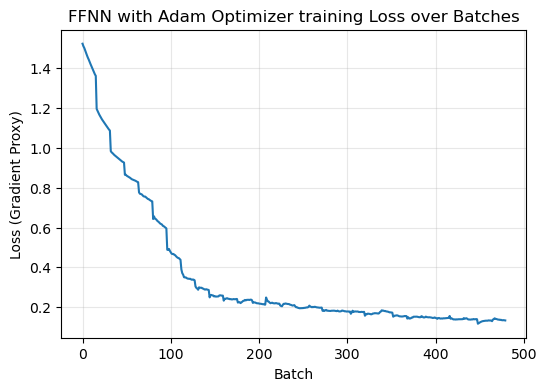

In [65]:
# Plot gradient norms using the callback
gradient_callback.plot_norms('FFNN with Adam Optimizer')

#### Method 1 - FFNN - Optimizer 2 - AdamW

The same process from the previous network is followed in this case. The only change is the optimizer. The Adam with weight decay will be used in this section:

In [59]:
# Instantiate the model
model_ffnn_admw = CustomFFNNModel(vocab_size=vocab_size, max_length=20)
# Create the optimizer
optimizer_ffnn_admw = get_optimizer('AdamW', [1e-4, 0.01, 0.9, 0.999, 1e-8, 0.5])
# Compile the model
model_ffnn_admw.compile(optimizer=optimizer_ffnn_admw,
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [66]:
# CPU-friendly callbacks with gradient tracking
gradient_callback_ffnn_admw = GradientNormCallback()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    gradient_callback_ffnn_admw
]

# Train the model with CPU-optimized settings
print("Starting training...")
history_ffnn_admw = model_ffnn_admw.fit(
    X_train, y_train,
    epochs=30,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1,
    workers=1,  
    use_multiprocessing=False 
)

Starting training...
Epoch 1/30
16/16 [==============================] - 2s 25ms/step - loss: 1.5181 - accuracy: 0.5030 - val_loss: 1.4976 - val_accuracy: 0.4961 - lr: 1.0000e-04
Epoch 2/30
16/16 [==============================] - 0s 9ms/step - loss: 1.4773 - accuracy: 0.5485 - val_loss: 1.4601 - val_accuracy: 0.4961 - lr: 1.0000e-04
Epoch 3/30
16/16 [==============================] - 0s 7ms/step - loss: 1.4402 - accuracy: 0.5327 - val_loss: 1.4243 - val_accuracy: 0.5039 - lr: 1.0000e-04
Epoch 4/30
16/16 [==============================] - 0s 7ms/step - loss: 1.4032 - accuracy: 0.5584 - val_loss: 1.3903 - val_accuracy: 0.5118 - lr: 1.0000e-04
Epoch 5/30
16/16 [==============================] - 0s 7ms/step - loss: 1.3687 - accuracy: 0.5921 - val_loss: 1.3581 - val_accuracy: 0.5276 - lr: 1.0000e-04
Epoch 6/30
16/16 [==============================] - 0s 7ms/step - loss: 1.3371 - accuracy: 0.5743 - val_loss: 1.3275 - val_accuracy: 0.5276 - lr: 1.0000e-04
Epoch 7/30
16/16 [==================

In [67]:
# Show the summary of the model
model_ffnn_admw.summary()

Model: "custom_ffnn_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     multiple                  747136    
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_12 (Dense)            multiple                  40992     
                                                                 
 dropout_8 (Dropout)         multiple                  0         
                                                                 
 dense_13 (Dense)            multiple                  528       
                                                                 
 dropout_9 (Dropout)         multiple                  0         
                                                                 
 dense_14 (Dense)            multiple          

In [69]:
# Print the metrics of the model using the previous function
y_pred_ffnn_admw, metrics_ffnn_admw = get_metrics(model_ffnn_admw, X_test, y_test,
                                                  'FFNN with AdamW Optimizer')

5/5 [==============================] - 0s 1ms/step

Metrics for FFNN with AdamW Optimizer:
Accuracy: 0.5786
Precision: 0.8421
Recall: 0.2000
F1 Score: 0.3232


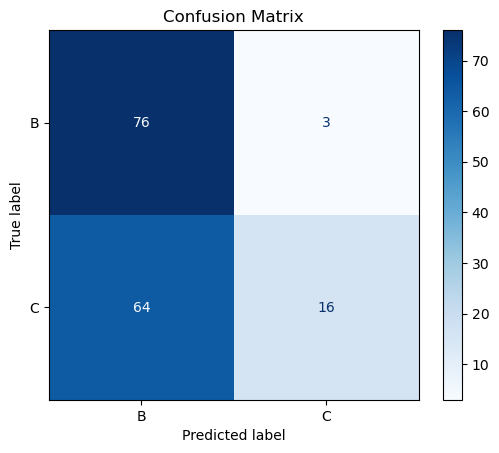

In [71]:
# Calculate the confusion matrix
cm_ffnn_admw = confusion_matrix(y_test, y_pred_ffnn_admw)
# Plot the confusion matrix using the defined function
plot_confusion_matrix(labels, cm_ffnn_admw)

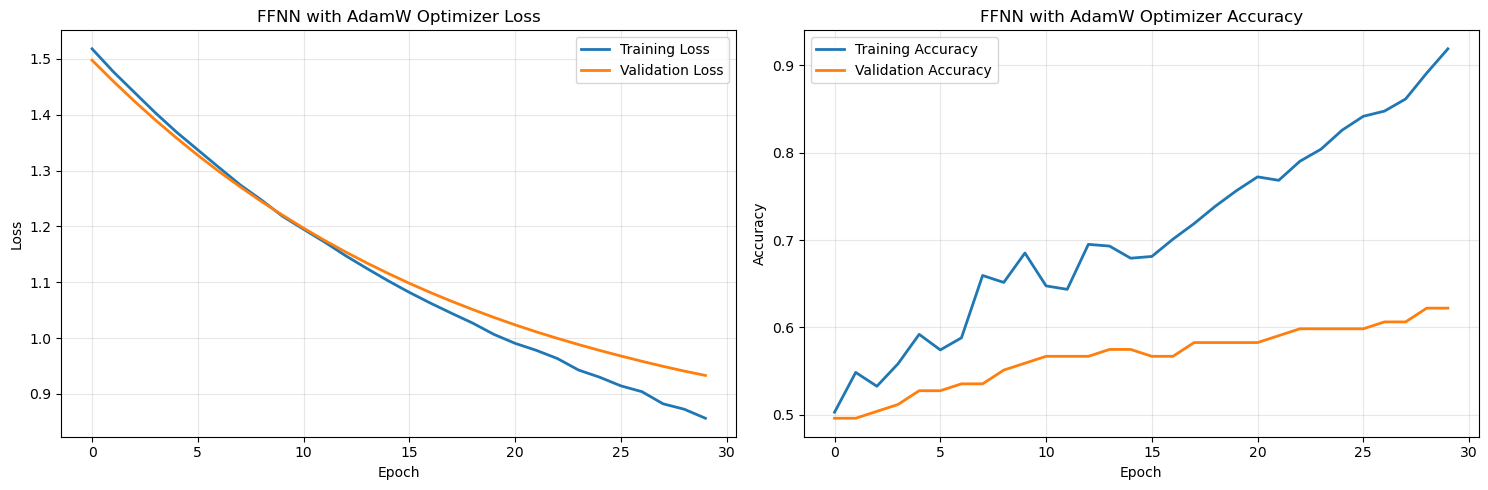

In [72]:
# Plot training history
plot_training_history(history_ffnn_admw, 'FFNN with AdamW Optimizer')

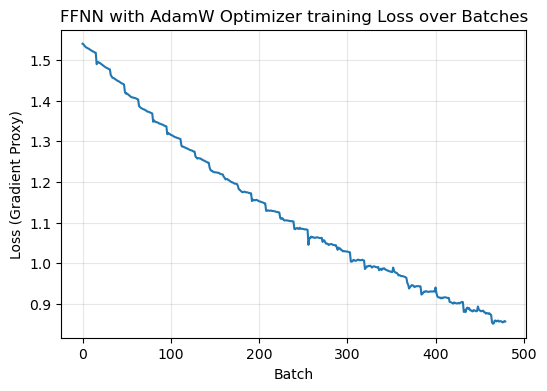

In [73]:
# Plot gradient norms using the callback
gradient_callback_ffnn_admw.plot_norms('FFNN with AdamW Optimizer')

#### Method 1 - FFNN - Optimizer 3 - SGD with momentum

The last optimizer, SGD with momentum, is implemented in the FFNN model following the same process before.

In [74]:
# Instantiate the model
model_ffnn_sgdm = CustomFFNNModel(vocab_size=vocab_size, max_length=20)
# Create the optimizer
optimizer_ffnn_sgdm = get_optimizer('SGDM', [0.01, 0.9, True, 1.0]) # Error with precision
# optimizer_ffnn_sgdm = get_optimizer('SGDM', [0.001, 0.95, False, 0.5])
# Compile the model
model_ffnn_sgdm.compile(optimizer=optimizer_ffnn_sgdm,
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [75]:
# CPU-friendly callbacks with gradient tracking
gradient_callback_ffnn_sgdm = GradientNormCallback()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    gradient_callback_ffnn_sgdm
]

# Train the model with CPU-optimized settings
print("Starting training...")
history_ffnn_sgdm = model_ffnn_sgdm.fit(
    X_train, y_train,
    epochs=30,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1,
    workers=1,  
    use_multiprocessing=False 
)

Starting training...
Epoch 1/30
16/16 [==============================] - 1s 17ms/step - loss: 1.5245 - accuracy: 0.4911 - val_loss: 1.5036 - val_accuracy: 0.5118 - lr: 0.0100
Epoch 2/30
16/16 [==============================] - 0s 7ms/step - loss: 1.4832 - accuracy: 0.4891 - val_loss: 1.4563 - val_accuracy: 0.5433 - lr: 0.0100
Epoch 3/30
16/16 [==============================] - 0s 5ms/step - loss: 1.4336 - accuracy: 0.5287 - val_loss: 1.4088 - val_accuracy: 0.5433 - lr: 0.0100
Epoch 4/30
16/16 [==============================] - 0s 4ms/step - loss: 1.3867 - accuracy: 0.5228 - val_loss: 1.3639 - val_accuracy: 0.5354 - lr: 0.0100
Epoch 5/30
16/16 [==============================] - 0s 5ms/step - loss: 1.3411 - accuracy: 0.5842 - val_loss: 1.3220 - val_accuracy: 0.5433 - lr: 0.0100
Epoch 6/30
16/16 [==============================] - 0s 7ms/step - loss: 1.3003 - accuracy: 0.5683 - val_loss: 1.2816 - val_accuracy: 0.5512 - lr: 0.0100
Epoch 7/30
16/16 [==============================] - 0s 4ms/s

In [76]:
# Show the summary of the model
model_ffnn_sgdm.summary()

Model: "custom_ffnn_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     multiple                  747136    
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_18 (Dense)            multiple                  40992     
                                                                 
 dropout_12 (Dropout)        multiple                  0         
                                                                 
 dense_19 (Dense)            multiple                  528       
                                                                 
 dropout_13 (Dropout)        multiple                  0         
                                                                 
 dense_20 (Dense)            multiple          

In [78]:
# Print the metrics of the model using the previous function
y_pred_ffnn_sgdm, metrics_ffnn_sgdm = get_metrics(model_ffnn_sgdm, X_test, y_test,
                                                  'FFNN with SGD with Momentum')

5/5 [==============================] - 0s 1ms/step

Metrics for FFNN with SGD with Momentum:
Accuracy: 0.6289
Precision: 0.6842
Recall: 0.4875
F1 Score: 0.5693


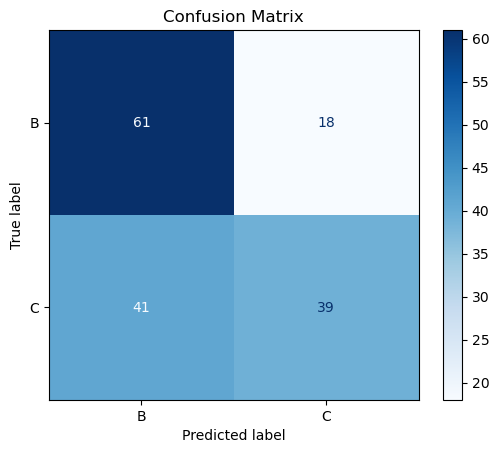

In [79]:
# Calculate the confusion matrix
cm_ffnn_sgdm = confusion_matrix(y_test, y_pred_ffnn_sgdm)
# Plot the confusion matrix using the defined function
plot_confusion_matrix(labels, cm_ffnn_sgdm)

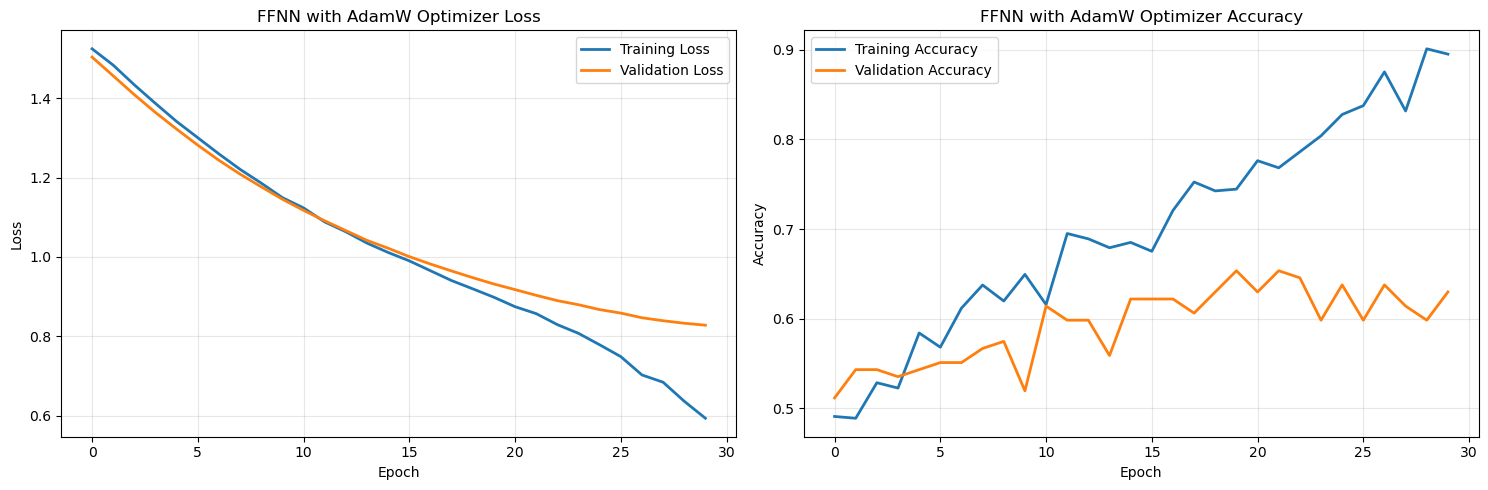

In [80]:
# Plot training history
plot_training_history(history_ffnn_sgdm, 'FFNN with AdamW Optimizer')

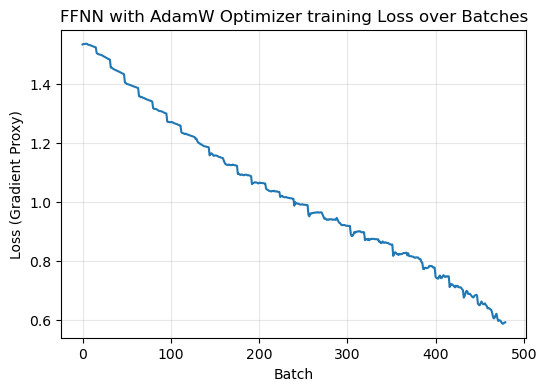

In [81]:
# Plot gradient norms using the callback
gradient_callback_ffnn_sgdm.plot_norms('FFNN with AdamW Optimizer')

### Method 2 - LSTM

The second model is the LSTM. The main advantage of this model is learning long term dependencies in text. Considering the nature of the IELTS writing 2 answers, the model is a suitable option to analyze the questions + answers. For the architecture of the model, 2 LSTM layers are stacked. The main goal is to better generalize the result of the task. In addition, the combination can identify different kind of patterns in data to improve the classifier. At the end, 3 layers are added to improve the classifier.

In [16]:
# Class wrapping the LSTM Model
class LSTMModel(Model):
    def __init__(self, vocab_size, max_length=20, lstm_units=64, 
                 dropout_rate_lstm1=0.3, dropout_rate_lstm2=0.3, dropout_rec_lstm1 = 0.3, dropout_rec_lstm2 = 0.3,
                 l2_reg_ker_lstm1=0.01, l2_reg_ker_lstm2=0.01, l2_reg_rec_lstm1=0.01, l2_reg_rec_lstm2=0.01,
                 dropout_rate_dl1=0.3, dropout_rate_dl2=0.3, l2_reg_dl1=0.01, l2_reg_dl2=0.01):
        super(LSTMModel, self).__init__()
        
        # Embedding layer        
        self.embedding = Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length)
        
        # LSTM architecture optimized for CPU training
        self.lstm_units = lstm_units
        
        # First LSTM layer - returns sequences for stacking
        self.lstm1 = LSTM(lstm_units,
                         return_sequences=True,
                         dropout=dropout_rate_lstm1,
                         recurrent_dropout=dropout_rec_lstm1,
                         kernel_regularizer=l2(l2_reg_ker_lstm1),
                         recurrent_regularizer=l2(l2_reg_rec_lstm1),
                         name='lstm1')
        
        # Second LSTM layer - final representation
        self.lstm2 = LSTM(lstm_units // 2,
                         return_sequences=False,
                         dropout=dropout_rate_lstm2,
                         recurrent_dropout=dropout_rec_lstm2,
                         kernel_regularizer=l2(l2_reg_ker_lstm2),
                         recurrent_regularizer=l2(l2_reg_rec_lstm2),
                         name='lstm2')

        # Dense layers for final classificatione layers for final classification
        self.dense1 = Dense(32, activation='relu', kernel_regularizer=l2(l2_reg_dl1), name='dense1')
        self.drop1 = Dropout(dropout_rate_dl1, name='dropout1')
        self.dense2 = Dense(16, activation='relu', kernel_regularizer=l2(l2_reg_dl2), name='dense2')
        self.drop2 = Dropout(dropout_rate_dl2, name='dropout2')
        self.output_layer = Dense(1, activation='sigmoid', name='output')
        
        # Store gradient norms as TensorFlow variable for graph compatibility
        self.gradient_norms = []
        self.current_step = tf.Variable(0, trainable=False, dtype=tf.int64)
    
    def call(self, inputs, training=None):
        # Start with embedding layer (same as FFNN)
        x = self.embedding(inputs)  # Shape: (batch_size, max_length, embedding_dim)
        # Pass through LSTM layers
        x = self.lstm1(x, training=training)  # Shape: (batch_size, 8, lstm_units*2)
        x = self.lstm2(x, training=training)  # Shape: (batch_size, lstm_units)
        # Pass through dense layers
        x = self.drop1(self.dense1(x), training=training)
        x = self.drop2(self.dense2(x), training=training)
        
        return self.output_layer(x)
    
    def train_step(self, data):
        x, y = data
        
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
    
        gradients = tape.gradient(loss, self.trainable_variables)
        non_none_gradients = [g for g in gradients if g is not None]
        
        # Calculate gradient norm but don't store it during graph execution
        if non_none_gradients:
            norm = tf.linalg.global_norm(non_none_gradients)
            # Just increment step counter during training
            self.current_step.assign_add(1)
        
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
    
        return {m.name: m.result() for m in self.metrics}

#### Method 2 - LSTM - Optimizer 1 - Adam

This section begins the processes with the LSTM model using different optimizers. The first one is the Adam optimizer.

In [21]:
# Instantiate the model
model_lstm_adm = LSTMModel(vocab_size=vocab_size, max_length=20, lstm_units=64, dropout_rate=0.3, l2_reg=0.01)

# Create the optimizer
optimizer_lstm_adm = get_optimizer('Adam', [1e-3, 0.9, 0.999, 1e-8])
# Compile the model
model_lstm_adm.compile(optimizer=optimizer_lstm_adm,
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [22]:
# CPU-friendly callbacks with gradient tracking
gradient_callback_lstm_adm = GradientNormCallback()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    gradient_callback_lstm_adm
]

# Train the model with CPU-optimized settings
print("Starting training...")
history_lstm_adm = model_lstm_adm.fit(
    X_train, y_train,
    epochs=30,
    validation_split=0.2,  
    callbacks=callbacks,
    verbose=1,
    workers=1,  
    use_multiprocessing=False 
)

Starting training...
Epoch 1/30
16/16 [==============================] - 6s 100ms/step - loss: 3.6100 - accuracy: 0.5208 - val_loss: 3.1481 - val_accuracy: 0.4724 - lr: 0.0010
Epoch 2/30
16/16 [==============================] - 1s 52ms/step - loss: 2.8219 - accuracy: 0.5050 - val_loss: 2.4792 - val_accuracy: 0.5512 - lr: 0.0010
Epoch 3/30
16/16 [==============================] - 1s 73ms/step - loss: 2.2418 - accuracy: 0.5287 - val_loss: 1.9950 - val_accuracy: 0.4724 - lr: 0.0010
Epoch 4/30
16/16 [==============================] - 1s 52ms/step - loss: 1.8236 - accuracy: 0.5050 - val_loss: 1.6458 - val_accuracy: 0.4803 - lr: 0.0010
Epoch 5/30
16/16 [==============================] - 1s 57ms/step - loss: 1.5225 - accuracy: 0.5347 - val_loss: 1.3945 - val_accuracy: 0.5276 - lr: 0.0010
Epoch 6/30
16/16 [==============================] - 1s 53ms/step - loss: 1.3062 - accuracy: 0.4931 - val_loss: 1.2132 - val_accuracy: 0.5512 - lr: 0.0010
Epoch 7/30
16/16 [==============================] - 1s

In [23]:
# Show the summary of the model
model_lstm_adm.summary()

Model: "lstm_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  747136    
                                                                 
 lstm1 (LSTM)                multiple                  33024     
                                                                 
 lstm2 (LSTM)                multiple                  12416     
                                                                 
 dense1 (Dense)              multiple                  1056      
                                                                 
 dropout1 (Dropout)          multiple                  0         
                                                                 
 dense2 (Dense)              multiple                  528       
                                                                 
 dropout2 (Dropout)          multiple                 

In [25]:
# Print the metrics of the model using the previous function
y_pred_lstm_adm, metrics_lstm_adm = get_metrics(model_lstm_adm, X_test, y_test,
                                                  'LSTM with Adam')

5/5 [==============================] - 0s 8ms/step

Metrics for LSTM with Adam:
Accuracy: 0.4969
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


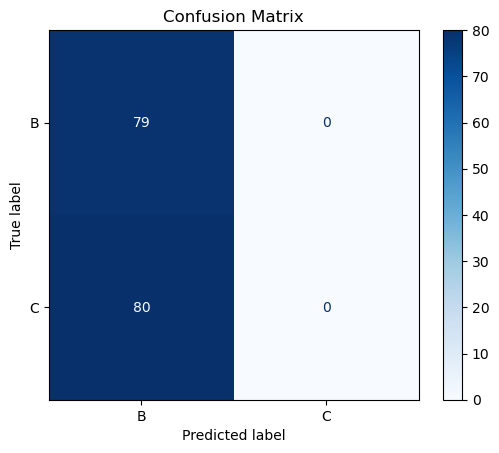

In [26]:
labels = ['B', 'C']
# Calculate the confusion matrix
cm_lstm_adm = confusion_matrix(y_test, y_pred_lstm_adm)
# Plot the confusion matrix using the defined function
plot_confusion_matrix(labels, cm_lstm_adm)

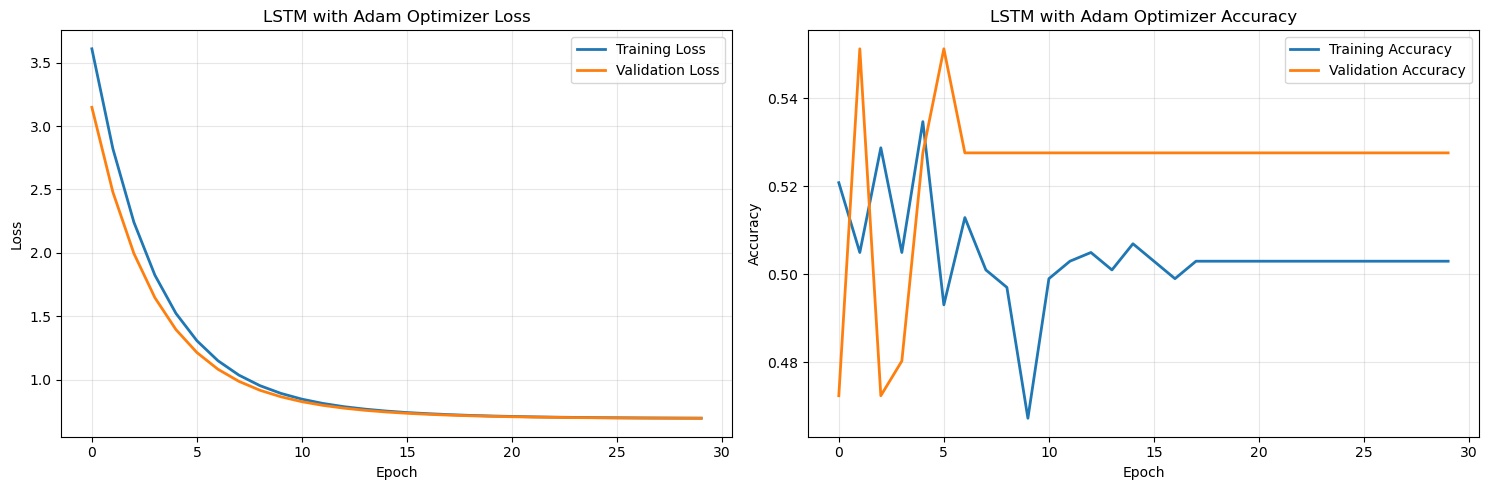

In [27]:
# Plot training history
plot_training_history(history_lstm_adm, 'LSTM with Adam Optimizer')

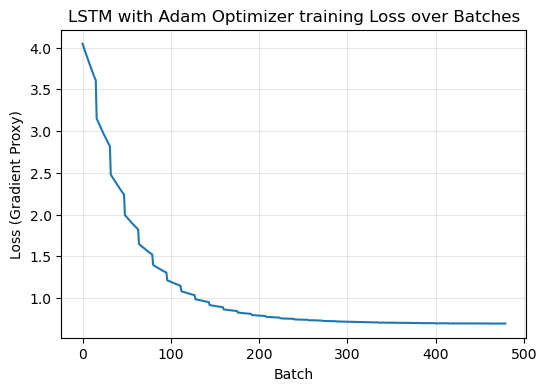

In [28]:
# Plot gradient norms using the callback
gradient_callback_lstm_adm.plot_norms('LSTM with Adam Optimizer')

#### Method 2 - LSTM - Optimizer 2 - AdamW

The second optimizer to use is AdamW (using the same previous process).

In [29]:
# Instantiate the model
model_lstm_admw = LSTMModel(vocab_size=vocab_size, max_length=20, lstm_units=64, dropout_rate=0.3, l2_reg=0.01)

# Create the optimizer
optimizer_lstm_admw = get_optimizer('AdamW', [2e-4, 0.001, 0.9, 0.999, 1e-8, 0.5])
# Compile the model
model_lstm_admw.compile(optimizer=optimizer_lstm_admw,
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [30]:
# CPU-friendly callbacks with gradient tracking
gradient_callback_lstm_admw = GradientNormCallback()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    gradient_callback_lstm_admw
]

# Train the model with CPU-optimized settings
print("Starting training...")
history_lstm_admw = model_lstm_admw.fit(
    X_train, y_train,
    epochs=30,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1,
    workers=1,  
    use_multiprocessing=False 
)

Starting training...
Epoch 1/30
16/16 [==============================] - 7s 94ms/step - loss: 3.9904 - accuracy: 0.5188 - val_loss: 3.8832 - val_accuracy: 0.5591 - lr: 2.0000e-04
Epoch 2/30
16/16 [==============================] - 1s 55ms/step - loss: 3.7949 - accuracy: 0.5525 - val_loss: 3.6942 - val_accuracy: 0.5906 - lr: 2.0000e-04
Epoch 3/30
16/16 [==============================] - 1s 53ms/step - loss: 3.6113 - accuracy: 0.5525 - val_loss: 3.5167 - val_accuracy: 0.5827 - lr: 2.0000e-04
Epoch 4/30
16/16 [==============================] - 1s 52ms/step - loss: 3.4390 - accuracy: 0.5485 - val_loss: 3.3503 - val_accuracy: 0.6142 - lr: 2.0000e-04
Epoch 5/30
16/16 [==============================] - 1s 65ms/step - loss: 3.2771 - accuracy: 0.5762 - val_loss: 3.1942 - val_accuracy: 0.5591 - lr: 2.0000e-04
Epoch 6/30
16/16 [==============================] - 1s 58ms/step - loss: 3.1259 - accuracy: 0.5683 - val_loss: 3.0479 - val_accuracy: 0.6693 - lr: 2.0000e-04
Epoch 7/30
16/16 [=============

In [31]:
# Show the summary of the model
model_lstm_admw.summary()

Model: "lstm_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  747136    
                                                                 
 lstm1 (LSTM)                multiple                  33024     
                                                                 
 lstm2 (LSTM)                multiple                  12416     
                                                                 
 dense1 (Dense)              multiple                  1056      
                                                                 
 dropout1 (Dropout)          multiple                  0         
                                                                 
 dense2 (Dense)              multiple                  528       
                                                                 
 dropout2 (Dropout)          multiple                 

In [33]:
# Print the metrics of the model using the previous function
y_pred_lstm_admw, metrics_lstm_admw = get_metrics(model_lstm_admw, X_test, y_test,
                                                      'LSTM with AdamW')

5/5 [==============================] - 0s 19ms/step

Metrics for LSTM with AdamW:
Accuracy: 0.5660
Precision: 0.5591
Recall: 0.6500
F1 Score: 0.6012


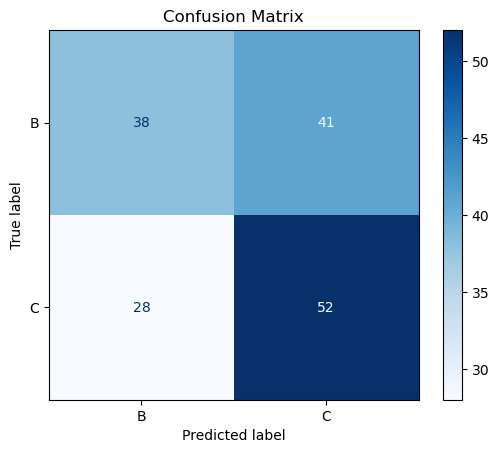

In [34]:
# Calculate the confusion matrix
cm_lstm_admw = confusion_matrix(y_test, y_pred_lstm_admw)
# Plot the confusion matrix using the defined function
plot_confusion_matrix(labels, cm_lstm_admw)

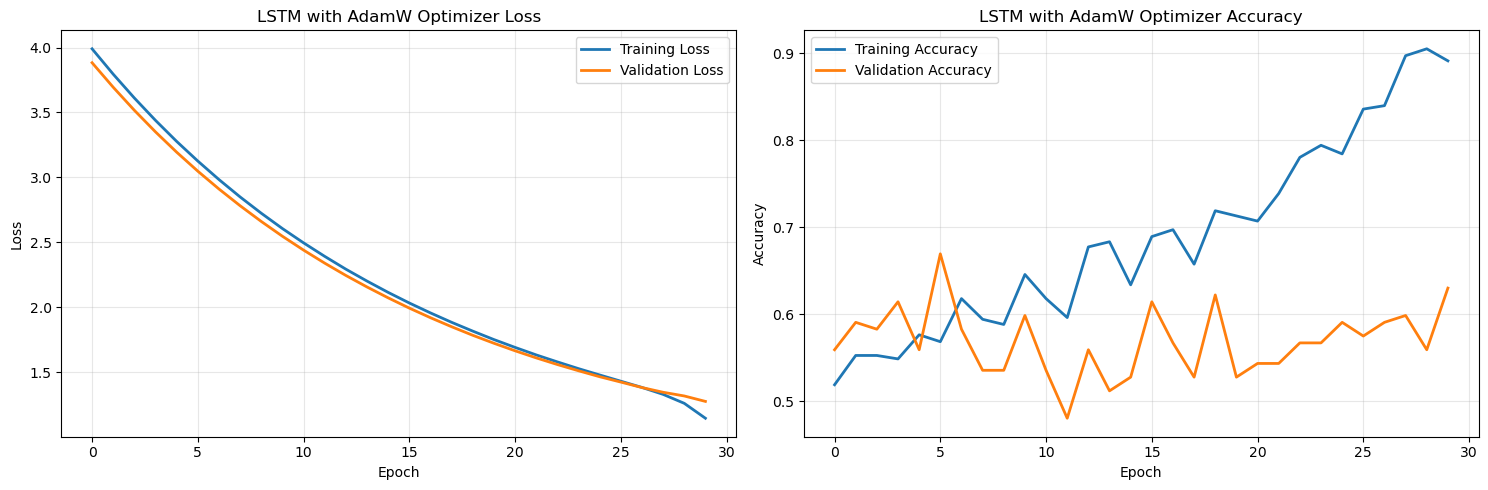

In [35]:
# Plot training history
plot_training_history(history_lstm_admw, 'LSTM with AdamW Optimizer')

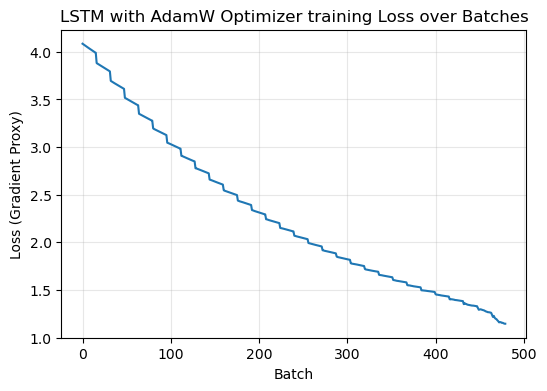

In [36]:
# Plot gradient norms using the callback
gradient_callback_lstm_admw.plot_norms('LSTM with AdamW Optimizer')

#### Method 2 - LSTM - Optimizer 3 - SGD with momentum

Finally, SGD with momentum is implemented as optimizer.

In [37]:
# Instantiate the model
model_lstm_sgdm = LSTMModel(vocab_size=vocab_size, max_length=20, lstm_units=64, dropout_rate=0.3, l2_reg=0.01)

# Create the optimizer
optimizer_lstm_sgdm = get_optimizer('SGDM', [0.01, 0.9, True, 1.0])
# optimizer_lstm_sgdm = get_optimizer('SGDM', [0.01, 0.95, False, 1.0])
# Compile the model
model_lstm_sgdm.compile(optimizer=optimizer_lstm_sgdm,
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [38]:
# CPU-friendly callbacks with gradient tracking
gradient_callback_lstm_sgdm = GradientNormCallback()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    gradient_callback_lstm_sgdm
]

# Train the model with CPU-optimized settings
print("Starting training...")
history_lstm_sgdm = model_lstm_sgdm.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,  
    callbacks=callbacks,
    verbose=1,
    workers=1,  
    use_multiprocessing=False 
)

Starting training...
Epoch 1/30
16/16 [==============================] - 6s 84ms/step - loss: 3.9776 - accuracy: 0.4693 - val_loss: 3.9001 - val_accuracy: 0.4724 - lr: 0.0100
Epoch 2/30
16/16 [==============================] - 1s 50ms/step - loss: 3.8159 - accuracy: 0.4713 - val_loss: 3.7133 - val_accuracy: 0.5276 - lr: 0.0100
Epoch 3/30
16/16 [==============================] - 1s 49ms/step - loss: 3.6267 - accuracy: 0.4713 - val_loss: 3.5259 - val_accuracy: 0.5276 - lr: 0.0100
Epoch 4/30
16/16 [==============================] - 1s 49ms/step - loss: 3.4433 - accuracy: 0.5010 - val_loss: 3.3475 - val_accuracy: 0.5276 - lr: 0.0100
Epoch 5/30
16/16 [==============================] - 1s 51ms/step - loss: 3.2701 - accuracy: 0.4931 - val_loss: 3.1803 - val_accuracy: 0.5276 - lr: 0.0100
Epoch 6/30
16/16 [==============================] - 1s 49ms/step - loss: 3.1079 - accuracy: 0.4495 - val_loss: 3.0239 - val_accuracy: 0.4724 - lr: 0.0100
Epoch 7/30
16/16 [==============================] - 1s 

In [39]:
# Show the summary of the model
model_lstm_sgdm.summary()

Model: "lstm_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  747136    
                                                                 
 lstm1 (LSTM)                multiple                  33024     
                                                                 
 lstm2 (LSTM)                multiple                  12416     
                                                                 
 dense1 (Dense)              multiple                  1056      
                                                                 
 dropout1 (Dropout)          multiple                  0         
                                                                 
 dense2 (Dense)              multiple                  528       
                                                                 
 dropout2 (Dropout)          multiple                 

In [41]:
# Print the metrics of the model using the previous function
y_pred_lstm_sgdm, metrics_lstm_sgdm = get_metrics(model_lstm_sgdm, X_test, y_test,
                                                      'LSTM with SGD with Momentum')

5/5 [==============================] - 0s 9ms/step

Metrics for LSTM with SGD with Momentum:
Accuracy: 0.4969
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


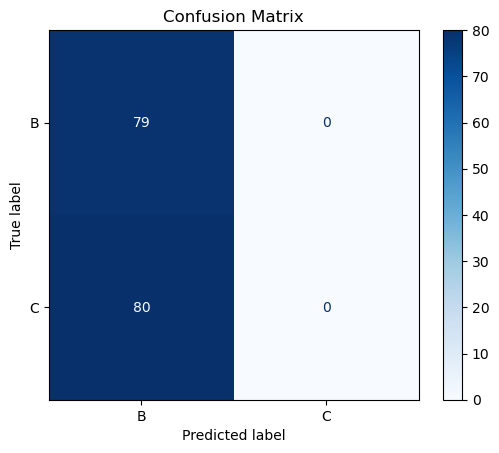

In [43]:
# Calculate the confusion matrix
cm_lstm_sgdm = confusion_matrix(y_test, y_pred_lstm_sgdm)
# Plot the confusion matrix using the defined function
plot_confusion_matrix(labels, cm_lstm_sgdm)

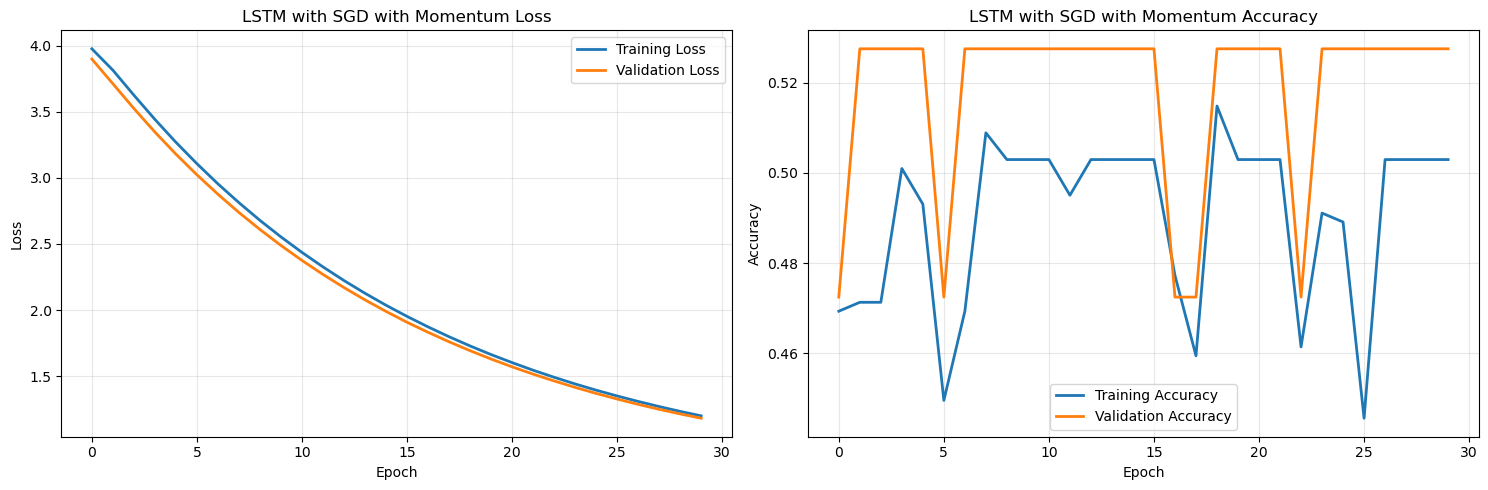

In [44]:
# Plot training history
plot_training_history(history_lstm_sgdm, 'LSTM with SGD with Momentum')

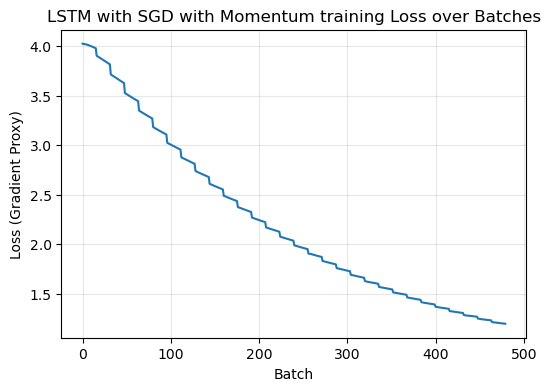

In [45]:
# Plot gradient norms using the callback
gradient_callback_lstm_sgdm.plot_norms('LSTM with SGD with Momentum')

### Method 3 - Transformer BERT Classifier

The last model to be implemented is BERT. It is a transformers-based model designed to understand human language. The main advantage of BERT is its bidirectional approach to understand better left and right context in a text. This approach presents a robust framework to deeply understand texts moe complex as essays for IELTS tasks.
The architecture for the present model begins with BERT as first input layer. It leverages all the elements from this pretrained model and freezes it to avoid any modification in the training phase. After BERT layer, a regular 4-layered dense architecture is implemented to improve the classifier performance. 
To create the instance of the model, inputs and attention data is needed. The builder method validates the parameter to fulfill with this requirement. Similar to the previous models, a custom train step method is impleented to track gradients. This tracking is complemeted by methods that manages the gradients using the transformers approach.

In [17]:
# Wrapper cLass for BERT classifier from tensorflow
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name='bert-base-uncased', 
                 dropout_rate_bert=0.3, dropout_rate_cd1=0.3, dropout_rate_cd2=0.3, dropout_rate_cd3=0.3, dropout_rate_cd4=0.3,
                 l2_reg_bert=0.01, l2_reg_cd1=0.01, l2_reg_cd2=0.01, l2_reg_cd3=0.01, 
                 freeze_bert=True, num_labels=1, **kwargs):
        super(TFBertClassifier, self).__init__(**kwargs)
        
        # Initialize base BERT model (using TFBertModel for better control)
        self.bert_model = TFBertModel.from_pretrained(
            model_name,
            output_attentions=False,
            output_hidden_states=False
        )
        
        # Freeze BERT layers but keep them accessible for fine-tuning
        if freeze_bert:
            self.bert_model.trainable = False
        
        # Store configuration parameters
        self.model_name = model_name
        self.dropout_rate = dropout_rate_bert
        self.l2_reg = l2_reg_bert
        self.freeze_bert = freeze_bert
        self.num_labels = num_labels
        
        # Get BERT hidden size (768 for bert-base)
        self.bert_hidden_size = self.bert_model.config.hidden_size
        
        # Custom classification layers for enhanced performance
        self.dropout1 = Dropout(dropout_rate_cd1, name='custom_dropout1')
        self.dense1 = Dense(
            512, 
            activation='relu', 
            kernel_regularizer=l2(l2_reg_cd1),
            name='custom_dense1'
        )
        
        self.dropout2 = Dropout(dropout_rate_cd2, name='custom_dropout2')
        self.dense2 = Dense(
            256, 
            activation='relu', 
            kernel_regularizer=l2(l2_reg_cd2),
            name='custom_dense2'
        )
        
        self.dropout3 = Dropout(dropout_rate_cd3, name='custom_dropout3')
        self.dense3 = Dense(
            128, 
            activation='relu', 
            kernel_regularizer=l2(l2_reg_cd3),
            name='custom_dense3'
        )
        
        self.dropout4 = Dropout(dropout_rate_cd4 * 0.5, name='custom_dropout4')  # Less dropout before output
        
        # Classification
        self.output_layer = Dense(num_labels, activation='sigmoid', name='binary_output')
        
        # Gradient tracking variables (compatible with TensorFlow graph mode)
        self.gradient_norms = []
        self.current_step = tf.Variable(0, trainable=False, dtype=tf.int64, name='step_counter')
        
        # Flag to track if we're in training mode (for gradient collection)
        self.collect_gradients = True
    
    def call(self, inputs, training=None):
        # Handle different input formats
        if isinstance(inputs, dict):
            input_ids = inputs.get('input_ids')
            attention_mask = inputs.get('attention_mask', None)
        else:
            input_ids = inputs
            attention_mask = None
        
        # Get BERT outputs
        bert_outputs = self.bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            training=training
        )
        
        # Use pooled output (CLS token representation)
        pooled_output = bert_outputs.pooler_output  # Shape: (batch_size, 768)
        
        # Pass through custom classification layers
        x = self.dropout1(pooled_output, training=training)
        x = self.dense1(x)
        
        x = self.dropout2(x, training=training)  
        x = self.dense2(x)
        
        x = self.dropout3(x, training=training)
        x = self.dense3(x)
        
        x = self.dropout4(x, training=training)
        
        # Final output
        return self.output_layer(x)
    
    def train_step(self, data):
        x, y = data
        
        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = self(x, training=True)
            # Calculate loss including regularization
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        
        # Calculate gradients
        gradients = tape.gradient(loss, self.trainable_variables)
        non_none_gradients = [g for g in gradients if g is not None]
        
        # Track gradient norms (only during training)
        if non_none_gradients and self.collect_gradients:
            grad_norm = tf.linalg.global_norm(non_none_gradients)
            
            # Store gradient norm (using py_function to execute eagerly)
            tf.py_function(
                func=lambda norm: self.gradient_norms.append(float(norm.numpy())),
                inp=[grad_norm],
                Tout=[]
            )
            
            # Increment step counter
            self.current_step.assign_add(1)
        
        # Apply gradients
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)
        
        # Return metrics
        return {m.name: m.result() for m in self.metrics}

    # Custom test step (no gradient tracking during validation)
    def test_step(self, data):
        x, y = data
        
        # Forward pass
        y_pred = self(x, training=False)
        
        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)
        
        return {m.name: m.result() for m in self.metrics}

    # Return collected gradient norms
    def get_gradient_norms(self):
        return self.gradient_norms.copy()

    # Reset gradient norm collection
    def reset_gradient_tracking(self):
        self.gradient_norms = []
        self.current_step.assign(0)

    # Enable/disable gradient collection
    def set_gradient_collection(self, collect=True):
        self.collect_gradients = collect
    
    def get_config(self):
        """Return model configuration"""
        config = super().get_config()
        config.update({
            'model_name': self.model_name,
            'dropout_rate': self.dropout_rate,
            'l2_reg': self.l2_reg,
            'freeze_bert': self.freeze_bert,
            'num_labels': self.num_labels,
        })
        return config

Because of the transformers nature, a new gradient callback function is created to track the values of the gradient over time. 

In [18]:
# Enhanced Gradient Callback that works with TFBertClassifier
class GradientNormCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.gradient_norms = []
        self.epochs = []
        self.batch_counts = []

    # Reset tracking at start of training
    def on_train_begin(self, logs=None):
        self.gradient_norms = []
        self.epochs = []
        self.batch_counts = []
        print("Gradient norm tracking started...")

    # Collect gradient norms at end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        if hasattr(self.model, 'get_gradient_norms'):
            current_norms = self.model.get_gradient_norms()
            
            if len(current_norms) > len(self.gradient_norms):
                # Add new gradient norms from this epoch
                new_norms = current_norms[len(self.gradient_norms):]
                self.gradient_norms.extend(new_norms)
                
                # Track epoch information
                for _ in new_norms:
                    self.epochs.append(epoch + 1)
                    self.batch_counts.append(len(self.gradient_norms))
                
                # Print epoch summary
                if new_norms:
                    avg_norm = np.mean(new_norms)
                    max_norm = np.max(new_norms)
                    min_norm = np.min(new_norms)
                    print(f"Epoch {epoch + 1} - Gradient Norms: "
                          f"Avg={avg_norm:.6f}, Max={max_norm:.6f}, Min={min_norm:.6f}")

    # Summary at end of training
    def on_train_end(self, logs=None):
        if self.gradient_norms:
            avg_norm = np.mean(self.gradient_norms)
            print(f"Training complete. Average gradient norm: {avg_norm:.6f}")
            print(f"Total gradient norm samples collected: {len(self.gradient_norms)}")
        else:
            print("No gradient norms were collected during training")
    
    def plot_norms(self, model_text):
        if not self.gradient_norms:
            print("No gradient norms to plot")
            return
        
        plt.figure(figsize=(10, 6))
        
        # Plot gradient norms
        # plt.subplot(2, 1, 1)
        plt.plot(self.gradient_norms, 'b-', alpha=0.7, linewidth=1)
        plt.title(f'{model_text} Gradient Norms During Training', fontsize=14, fontweight='bold')
        plt.xlabel('Training Step')
        plt.ylabel('Gradient Norm')
        plt.grid(True, alpha=0.3)
        
        plt.show()

The dataset must be converted into a BERT compatible format. The next functions generates the inputs and attention for training and test data.

In [19]:
# BERT Data Preprocessing Function
def create_bert_dataset(texts, labels, tokenizer, max_length=128, batch_size=32):
    def encode_texts(texts):
        input_ids = []
        attention_masks = []
        
        for text in texts:
            encoded = tokenizer(
                str(text),
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors='tf'
            )
            input_ids.append(encoded['input_ids'][0])
            attention_masks.append(encoded['attention_mask'][0])
        
        return {
            'input_ids': tf.stack(input_ids),
            'attention_mask': tf.stack(attention_masks)
        }
    
    # Encode the texts
    encoded_data = encode_texts(texts)
    
    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encoded_data['input_ids'],
            'attention_mask': encoded_data['attention_mask']
        },
        labels
    ))
    
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [20]:
# Create BERT test dataset for metrics evaluation
def create_bert_test_dataset(texts, tokenizer, max_length=128, batch_size=32):
    def encode_texts(texts):
        input_ids = []
        attention_masks = []
        
        for text in texts:
            encoded = tokenizer(
                str(text),
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors='tf'
            )
            input_ids.append(encoded['input_ids'][0])
            attention_masks.append(encoded['attention_mask'][0])
        
        return {
            'input_ids': tf.stack(input_ids),
            'attention_mask': tf.stack(attention_masks)
        }
    
    # Encode the texts
    encoded_data = encode_texts(texts)
    
    # Create TensorFlow dataset (only features, no labels)
    dataset = tf.data.Dataset.from_tensor_slices({
        'input_ids': encoded_data['input_ids'],
        'attention_mask': encoded_data['attention_mask']
    })
    
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

Finally, a function to get metrics from BERT model, based in a defined previously, is implemented to show data and evaluate the model.

In [21]:
def get_metrics_bert(model, data_test, labels_test, model_text, show_metrics=True):
    # Evaluating the model
    print(f"Generating predictions for {model_text}...")
    test_predictions = model.predict(data_test, verbose=1)
    test_predictions_binary = (test_predictions > 0.5).astype(int).flatten()
    
    # Calculate metrics
    accuracy = accuracy_score(labels_test, test_predictions_binary)
    precision = precision_score(labels_test, test_predictions_binary)
    recall = recall_score(labels_test, test_predictions_binary)
    f1 = f1_score(labels_test, test_predictions_binary)

    if show_metrics:
        print(f"\nMetrics for {model_text}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

    return test_predictions_binary, [accuracy, precision, recall, f1]

At this point, it is time to crate the dataset to begin the processes with BERT.

In [136]:
print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_train_texts, X_test_texts, y_train, y_test = train_test_split(texts, y, test_size=0.2, random_state=42)

# Create BERT datasets
print("Creating BERT datasets...")
train_dataset = create_bert_dataset(X_train_texts, y_train, tokenizer, max_length=128, batch_size=16)
test_dataset = create_bert_dataset(X_test_texts, y_test, tokenizer, max_length=128, batch_size=16)

# Split training data for validation (20% of training data)
train_size = len(X_train)
val_size = int(0.2 * train_size)
train_texts_final = X_train[:-val_size]
val_texts = X_train[-val_size:]
y_train_final = y_train[:-val_size]
y_val = y_train[-val_size:]

# Create final datasets
train_dataset_final = create_bert_dataset(train_texts_final, y_train_final, tokenizer, max_length=128, batch_size=16)
val_dataset = create_bert_dataset(val_texts, y_val, tokenizer, max_length=128, batch_size=16)
print("Datasets created!")

Loading BERT tokenizer...
Creating BERT datasets...


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Datasets created!


#### Method 3 - Transformer BERT Classifier - Optimizer 1 - Adam

For the following three sections, a BERT model is defined using three different optimizers. Adam is the first one.

In [137]:
# Create and build BERT model
print("Creating BERT model...")
model_bert_adm = TFBertClassifier(
    model_name='bert-base-uncased', 
    dropout_rate=0.3, 
    l2_reg=0.01, 
    freeze_bert=True
)

# Build model with sample input
sample_text = "This is a sample text to build the model."
sample_encoded = tokenizer(
    sample_text, 
    max_length=128, 
    padding='max_length', 
    truncation=True, 
    return_tensors='tf'
)
_ = model_bert_adm(sample_encoded)

# Compile model
optimizer_bert_adm = get_optimizer('Adam', [2e-5, 0.9, 0.999, 1e-8])  # Lower learning rate for BERT
model_bert_adm.compile(
    optimizer=optimizer_bert_adm,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Creating BERT model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [138]:
# Setup callbacks
gradient_callback_bert_adm = GradientNormCallback()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    gradient_callback_bert_adm
]

# Step 8: Train the model
print("Starting BERT training...")
history_bert_adm = model_bert_adm.fit(
    train_dataset_final,  
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

Starting BERT training...
Gradient norm tracking started...
Epoch 1/10
32/32 [==============================] - 64s 2s/step - loss: 11.9277 - accuracy: 0.4881 - val_loss: 0.0000e+00 - val_accuracy: 0.4683 - lr: 2.0000e-05
Epoch 2/10
32/32 [==============================] - 48s 2s/step - loss: 11.8128 - accuracy: 0.4743 - val_loss: 0.0000e+00 - val_accuracy: 0.4603 - lr: 2.0000e-05
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 11.6881 - accuracy: 0.5020
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 3 - Gradient Norms: Avg=3.324152, Max=4.163280, Min=2.670834
32/32 [==============================] - 49s 2s/step - loss: 11.6881 - accuracy: 0.5020 - val_loss: 0.0000e+00 - val_accuracy: 0.4683 - lr: 2.0000e-05
Epoch 4/10
32/32 [==============================] - ETA: 0s - loss: 11.5788 - accuracy: 0.5158Restoring model weights from the end of the best epoch: 1.
Epoch 4 - Gradient Norms: Avg=3.192272, Max=3.958709, Min=2.737683
32/32 [

In [139]:
# Show the summary of the model
model_bert_adm.summary()

Model: "tf_bert_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_1 (TFBertMode  multiple                 109482240 
 l)                                                              
                                                                 
 custom_dropout1 (Dropout)   multiple                  0         
                                                                 
 custom_dense1 (Dense)       multiple                  393728    
                                                                 
 custom_dropout2 (Dropout)   multiple                  0         
                                                                 
 custom_dense2 (Dense)       multiple                  131328    
                                                                 
 custom_dropout3 (Dropout)   multiple                  0         
                                              

In [ ]:
# Create BERT test dataset (without labels for prediction)
bert_test_dataset = create_bert_test_dataset(
    X_test, 
    tokenizer, 
    max_length=128, 
    batch_size=16  # Use same batch size as training
)

# Use the adapted metrics function
y_pred_bert_adm, metrics_bert_adm = get_metrics_bert(
    model_bert_adm, 
    bert_test_dataset, 
    y_test, 
    "BERT Classifier with Adam optimizer:",
    show_metrics=True
)

Generating predictions for BERT Classifier with Adam optimizer:...
10/10 [==============================] - 12s 1s/step

Metrics for BERT Classifier with Adam optimizer::
Accuracy: 0.4906
Precision: 0.4966
Recall: 0.9125
F1 Score: 0.6432


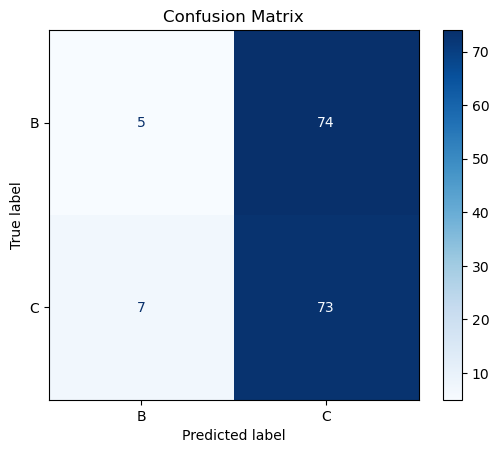

In [144]:
labels = ['B', 'C']
# Calculate the confusion matrix
cm_bert_adm = confusion_matrix(y_test, y_pred_bert_adm)
# Plot the confusion matrix using the defined function
plot_confusion_matrix(labels, cm_bert_adm)

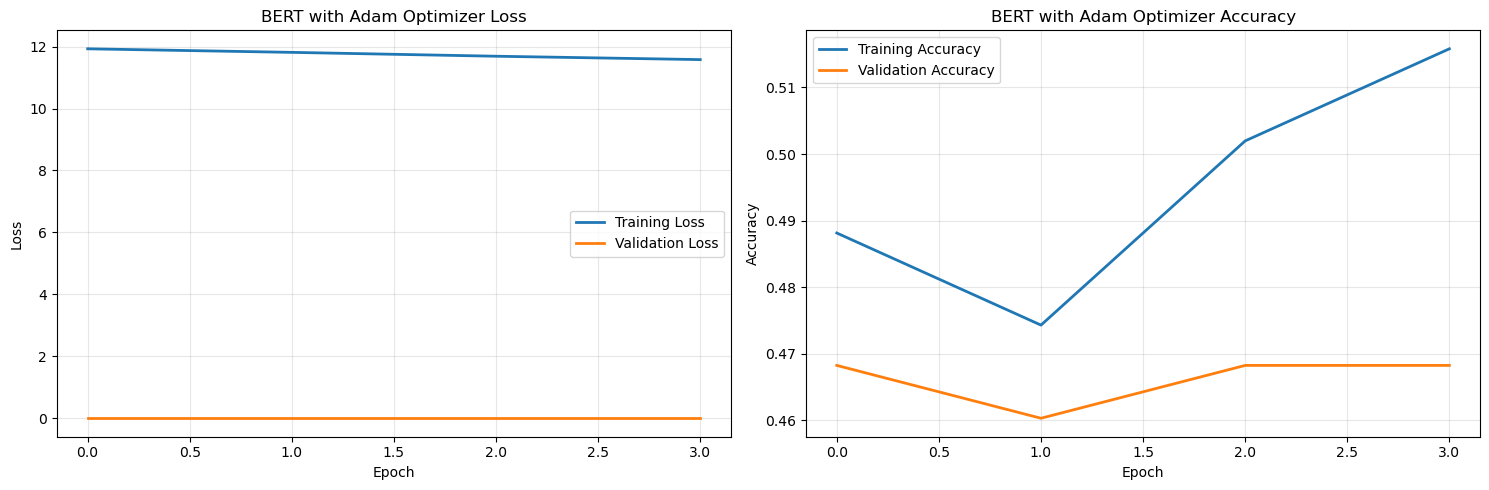

In [145]:
# Plot training history
plot_training_history(history_bert_adm, 'BERT with Adam Optimizer')

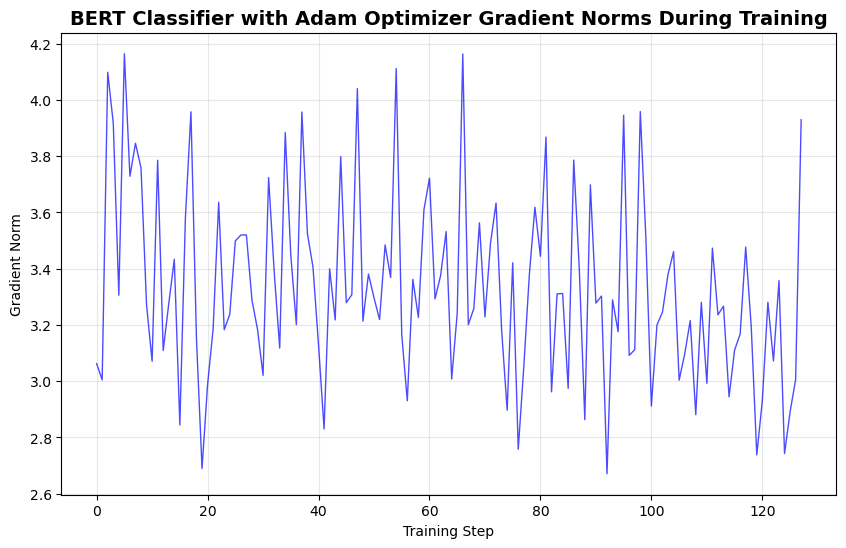

In [158]:
# Plot gradient norms using the callback
gradient_callback_bert_adm.plot_norms("BERT Classifier with Adam Optimizer")

#### Method 3 - Transformer BERT Classifier - Optimizer 2 - AdamW

This section implements the AdamW optimizer.

In [149]:
# Create and build BERT model
print("Creating BERT model...")
model_bert_admw = TFBertClassifier(
    model_name='bert-base-uncased', 
    dropout_rate=0.3, 
    l2_reg=0.01, 
    freeze_bert=True
)

# Build model with sample input
_ = model_bert_admw(sample_encoded)

# Create the optimizer
optimizer_bert_admw = get_optimizer('AdamW', [1e-4, 0.01, 0.9, 0.999, 1e-8, 1.0])
# Compile the model
model_bert_admw.compile(optimizer=optimizer_bert_admw,
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

Creating BERT model...


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

In [150]:
# CPU-friendly callbacks with gradient tracking
gradient_callback_bert_admw = GradientNormCallback()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    gradient_callback_bert_admw
]

# Train the model with CPU-optimized settings
print("Starting training...")
history_bert_admw = model_bert_admw.fit(
    train_dataset_final,  
    validation_data=val_dataset,
    epochs=10,  
    callbacks=callbacks,
    verbose=1,
    workers=1,
    use_multiprocessing=False
)

Starting training...
Gradient norm tracking started...
Epoch 1/10


32/32 [==============================] - 63s 2s/step - loss: 11.7580 - accuracy: 0.4921 - val_loss: 0.0000e+00 - val_accuracy: 0.4683 - lr: 1.0000e-04
Epoch 2/10
32/32 [==============================] - 47s 1s/step - loss: 11.1732 - accuracy: 0.4881 - val_loss: 0.0000e+00 - val_accuracy: 0.5317 - lr: 1.0000e-04
Epoch 3/10
32/32 [==============================] - 48s 1s/step - loss: 10.6409 - accuracy: 0.4447 - val_loss: 0.0000e+00 - val_accuracy: 0.5556 - lr: 1.0000e-04
Epoch 4/10
32/32 [==============================] - ETA: 0s - loss: 10.0972 - accuracy: 0.5158
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 4 - Gradient Norms: Avg=2.931396, Max=3.716482, Min=2.322207
32/32 [==============================] - 48s 2s/step - loss: 10.0972 - accuracy: 0.5158 - val_loss: 0.0000e+00 - val_accuracy: 0.5635 - lr: 1.0000e-04
Epoch 5/10
32/32 [==============================] - 50s 2s/step - loss: 9.7300 - accuracy: 0.5040 - val_loss: 0.0000e+00 - val_accuracy:

In [151]:
# Show the summary of the model
model_bert_admw.summary()

Model: "tf_bert_classifier_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_2 (TFBertMode  multiple                 109482240 
 l)                                                              
                                                                 
 custom_dropout1 (Dropout)   multiple                  0         
                                                                 
 custom_dense1 (Dense)       multiple                  393728    
                                                                 
 custom_dropout2 (Dropout)   multiple                  0         
                                                                 
 custom_dense2 (Dense)       multiple                  131328    
                                                                 
 custom_dropout3 (Dropout)   multiple                  0         
                                              

In [164]:
# Print the metrics of the model using the previous function
y_pred_bert_admw, metrics_bert_admw = get_metrics_bert(model_bert_admw, bert_test_dataset, y_test,
                                                       'BERT with AdamW Optimizer', show_metrics=True)

Generating predictions for BERT with AdamW Optimizer...
10/10 [==============================] - 10s 986ms/step

Metrics for BERT with AdamW Optimizer:
Accuracy: 0.5220
Precision: 0.5133
Recall: 0.9625
F1 Score: 0.6696


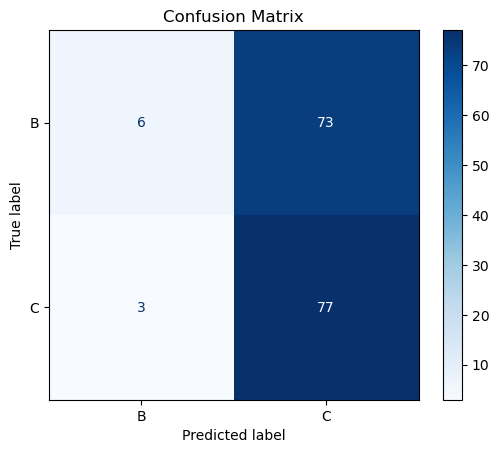

In [156]:
# Calculate the confusion matrix
cm_bert_admw = confusion_matrix(y_test, y_pred_bert_admw)
# Plot the confusion matrix using the defined function
plot_confusion_matrix(labels, cm_bert_admw)

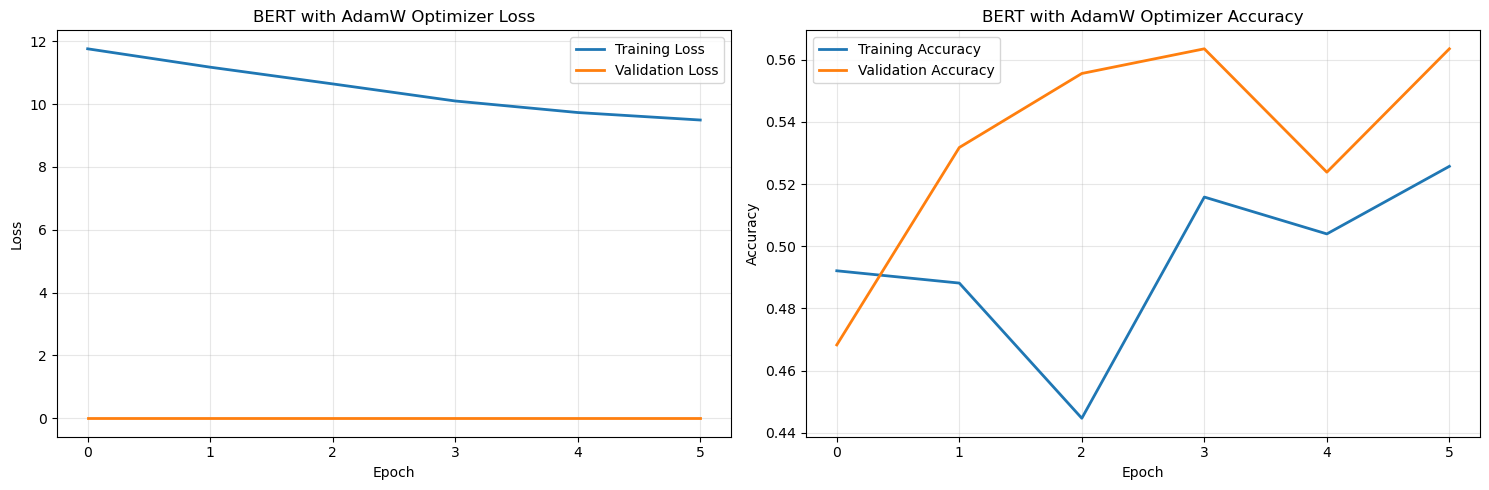

In [157]:
# Plot training history
plot_training_history(history_bert_admw, 'BERT with AdamW Optimizer')

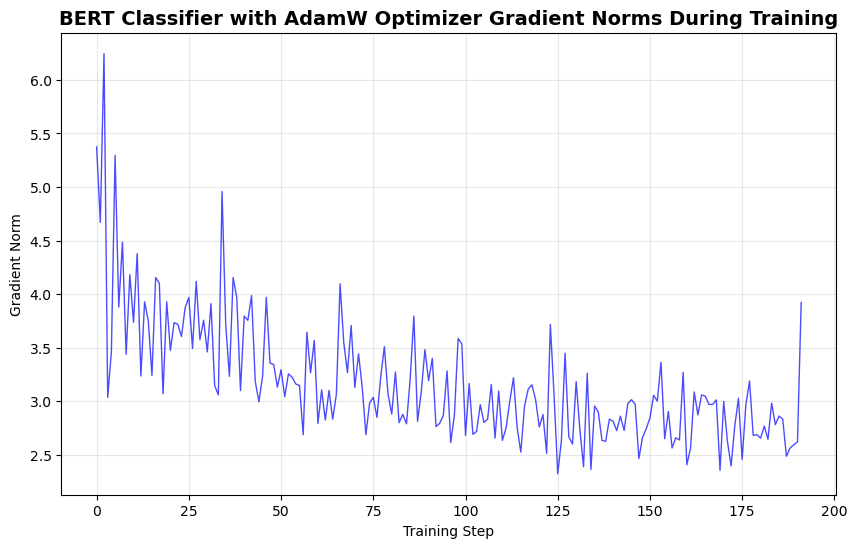

In [159]:
# Plot gradient norms using the callback
gradient_callback_bert_admw.plot_norms('BERT Classifier with AdamW Optimizer')

#### Method 3 - Transformer BERT Classifier - Optimizer 3 - SGD with Momentum

Finally, the SGD with momentum optimizsr is implemented.

In [160]:
# Create and build BERT model
model_bert_sgdm = TFBertClassifier(
    model_name='bert-base-uncased', 
    dropout_rate=0.3, 
    l2_reg=0.01, 
    freeze_bert=True
)

_ = model_bert_sgdm(sample_encoded)

# Create the optimizer
optimizer_bert_sgdm = get_optimizer('SGDM', [0.001, 0.9, True, 1.0])
# Compile the model
model_bert_sgdm.compile(optimizer=optimizer_bert_sgdm,
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

In [161]:
gradient_callback_bert_sgdm = GradientNormCallback()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    gradient_callback_bert_sgdm
]

# Train the model with CPU-optimized settings
print("Starting training...")
history_bert_sgdm = model_bert_sgdm.fit(
    train_dataset_final,  
    validation_data=val_dataset,
    epochs=10,  
    callbacks=callbacks,
    verbose=1,
    workers=1,
    use_multiprocessing=False
)

Starting training...
Gradient norm tracking started...
Epoch 1/10
32/32 [==============================] - 69s 2s/step - loss: 11.9777 - accuracy: 0.4960 - val_loss: 0.0000e+00 - val_accuracy: 0.4683 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 52s 2s/step - loss: 11.8280 - accuracy: 0.4862 - val_loss: 0.0000e+00 - val_accuracy: 0.4683 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 55s 2s/step - loss: 11.6679 - accuracy: 0.5336 - val_loss: 0.0000e+00 - val_accuracy: 0.4683 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - ETA: 0s - loss: 11.5318 - accuracy: 0.4960
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4 - Gradient Norms: Avg=2.596027, Max=3.367087, Min=2.197162
32/32 [==============================] - 54s 2s/step - loss: 11.5318 - accuracy: 0.4960 - val_loss: 0.0000e+00 - val_accuracy: 0.4683 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 54s 2s/step - loss: 11.4121 - accu

In [162]:
# Show the summary of the model
model_bert_sgdm.summary()

Model: "tf_bert_classifier_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_3 (TFBertMode  multiple                 109482240 
 l)                                                              
                                                                 
 custom_dropout1 (Dropout)   multiple                  0         
                                                                 
 custom_dense1 (Dense)       multiple                  393728    
                                                                 
 custom_dropout2 (Dropout)   multiple                  0         
                                                                 
 custom_dense2 (Dense)       multiple                  131328    
                                                                 
 custom_dropout3 (Dropout)   multiple                  0         
                                              

In [165]:
# Print the metrics of the model using the previous function
y_pred_bert_sgdm, metrics_bert_sgdm = get_metrics_bert(model_bert_sgdm, bert_test_dataset, y_test,
                                                  'BERT with SGD with Momentum Optimizer', show_metrics=True)

Generating predictions for BERT with SGD with Momentum Optimizer...
10/10 [==============================] - 14s 1s/step

Metrics for BERT with SGD with Momentum Optimizer:
Accuracy: 0.5031
Precision: 0.5031
Recall: 1.0000
F1 Score: 0.6695


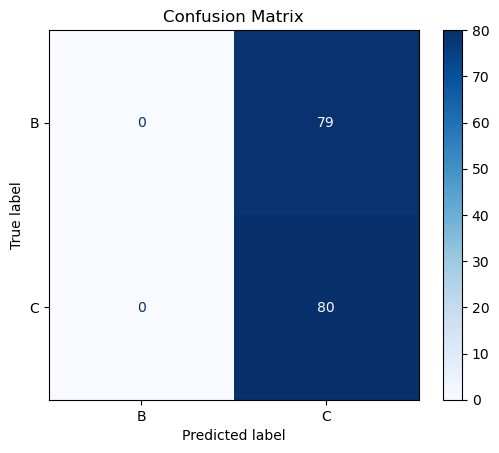

In [166]:
# Calculate the confusion matrix
cm_bert_sgdm = confusion_matrix(y_test, y_pred_bert_sgdm)
# Plot the confusion matrix using the defined function
plot_confusion_matrix(labels, cm_bert_sgdm)

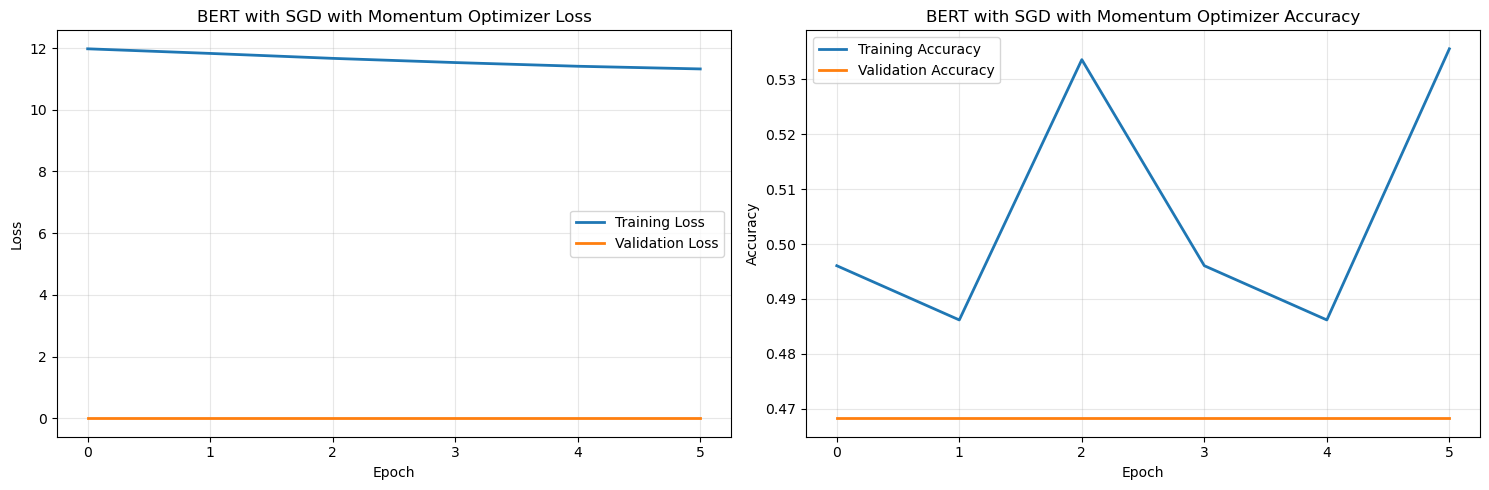

In [167]:
# Plot training history
plot_training_history(history_bert_sgdm, 'BERT with SGD with Momentum Optimizer')

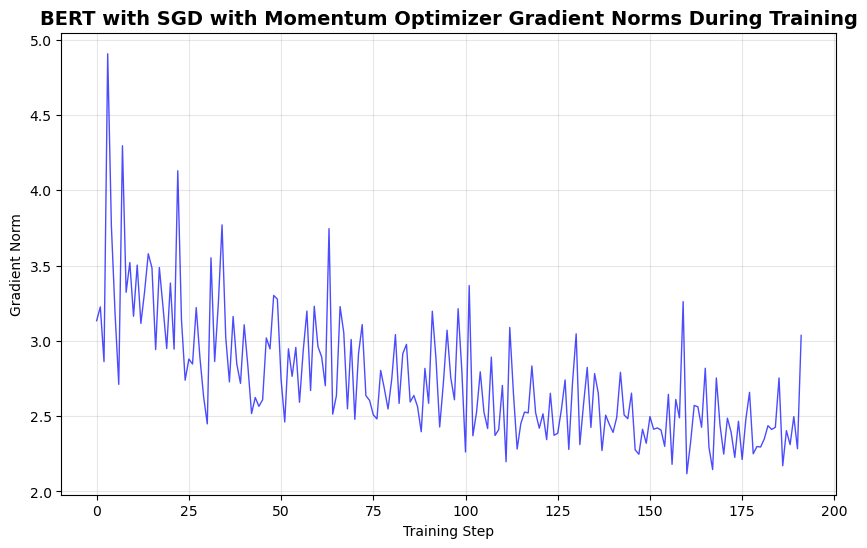

In [168]:
# Plot gradient norms using the callback
gradient_callback_bert_sgdm.plot_norms('BERT with SGD with Momentum Optimizer')

### Hyperparameter tuning

As it can be seen in the previous models, metrics from them are not good. Hyperparameter tuning is necesary to get the best from each one. The optuna library is implemented to get the best hyperparameters for each approach and then, get the metrics from the best moel using the test sets.

#### Optuna strategy definition

The models were training splitting X_test inside the training. For tuning, they are splitted from the beginning.

In [22]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)

A hyperparamter tuning function with optuna is defined. It is going to be a multimodel and multioptimizer function. Depending on the parameters, the model and optimizer will be defined and tuned using optuna. After the tuning process, the hyperparametrs and metrics of the best model are showed.

In [23]:
# Function to tune the defined models using Optuna
def objective_multi_model(trial, X_train, y_train, X_val, y_val, vocab_size, model='FFNN', optimizer='Adam'):    
    try:
        # Common hyperparameters
        max_length = trial.suggest_int("max_length", 10, 100)
        dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
        # l2_reg = trial.suggest_loguniform("l2_reg", 1e-5, 1e-1)
        l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-1, log=True)
        
        # Model-specific hyperparameters and instantiation
        if model == 'FFNN':
            # FFNN-specific hyperparameters
            penalty_d1 = trial.suggest_float("penalty_d1", 1e-5, 1e-1, log=True)
            penalty_d2 = trial.suggest_float("penalty_d2", 1e-5, 1e-1, log=True)
            dropout_d1 = trial.suggest_float("dropout_d1", 0.1, 0.5)
            dropout_d2 = trial.suggest_float("dropout_d2", 0.1, 0.5)
            
            clf = CustomFFNNModel(vocab_size=vocab_size, 
                                max_length=max_length, 
                                penalty_d1=penalty_d1, 
                                penalty_d2=penalty_d2, 
                                dropout_d1=dropout_d1, 
                                dropout_d2=dropout_d2)
        
        elif model == 'LSTM':
            # LSTM-specific hyperparameters
            lstm_units = trial.suggest_int("lstm_units", 32, 128, step=16)
            dropout_rate_lstm1 = trial.suggest_float("dropout_rate_lstm1", 0.1, 0.5)
            dropout_rate_lstm2 = trial.suggest_float("dropout_rate_lstm2", 0.1, 0.5)
            dropout_rec_lstm1 = trial.suggest_float("dropout_rec_lstm1", 0.1, 0.5)
            dropout_rec_lstm2 = trial.suggest_float("dropout_rec_lstm2", 0.1, 0.5)
            l2_reg_ker_lstm1 = trial.suggest_float("l2_reg_ker_lstm1", 1e-5, 1e-1, log=True)
            l2_reg_ker_lstm2 = trial.suggest_float("l2_reg_ker_lstm2", 1e-5, 1e-1, log=True)
            l2_reg_rec_lstm1 = trial.suggest_float("l2_reg_rec_lstm1", 1e-5, 1e-1, log=True)
            l2_reg_rec_lstm2 = trial.suggest_float("l2_reg_rec_lstm2", 1e-5, 1e-1, log=True)
            dropout_rate_dl1 = trial.suggest_float("dropout_rate_dl1", 0.1, 0.5)
            dropout_rate_dl2 = trial.suggest_float("dropout_rate_dl2", 0.1, 0.5)
            l2_reg_dl1 = trial.suggest_float("l2_reg_dl1", 1e-5, 1e-1, log=True)
            l2_reg_dl2 = trial.suggest_float("l2_reg_dl2", 1e-5, 1e-1, log=True)
            
            clf = LSTMModel(vocab_size=vocab_size, max_length=max_length, lstm_units=lstm_units, 
                            dropout_rate_lstm1=dropout_rate_lstm1, 
                            dropout_rate_lstm2=dropout_rate_lstm2, 
                            dropout_rec_lstm1=dropout_rec_lstm1, 
                            dropout_rec_lstm2=dropout_rec_lstm2,
                            l2_reg_ker_lstm1=l2_reg_ker_lstm1, 
                            l2_reg_ker_lstm2=l2_reg_ker_lstm2, 
                            l2_reg_rec_lstm1=l2_reg_rec_lstm1, 
                            l2_reg_rec_lstm2=l2_reg_rec_lstm2,
                            dropout_rate_dl1=dropout_rate_dl1, 
                            dropout_rate_dl2=dropout_rate_dl2, 
                            l2_reg_dl1=l2_reg_dl1, 
                            l2_reg_dl2=l2_reg_dl2)

        elif model == 'BERT':
            # BERT-specific hyperparameters
            # lstm_units = trial.suggest_int("lstm_units", 32, 128, step=16)
            dropout_rate_bert = trial.suggest_float("dropout_rate_bert", 0.1, 0.5)
            dropout_rate_cd1 = trial.suggest_float("dropout_rate_cd1", 0.1, 0.5)
            dropout_rate_cd2 = trial.suggest_float("dropout_rate_cd2", 0.1, 0.5)
            dropout_rate_cd3 = trial.suggest_float("dropout_rate_cd3", 0.1, 0.5)
            dropout_rate_cd4 = trial.suggest_float("dropout_rate_cd4", 0.1, 0.5)
            l2_reg_bert = trial.suggest_float("l2_reg_bert", 1e-5, 1e-1, log=True)
            l2_reg_cd1 = trial.suggest_float("l2_reg_cd1", 1e-5, 1e-1, log=True)
            l2_reg_cd2 = trial.suggest_float("l2_reg_cd2", 1e-5, 1e-1, log=True)
            l2_reg_cd3 = trial.suggest_float("l2_reg_cd3", 1e-5, 1e-1, log=True)

            clf = TFBertClassifier(dropout_rate_bert=dropout_rate_bert, 
                                dropout_rate_cd1=dropout_rate_cd1, 
                                dropout_rate_cd2=dropout_rate_cd2, 
                                dropout_rate_cd3=dropout_rate_cd3, 
                                dropout_rate_cd4=dropout_rate_cd4,
                                l2_reg_bert=l2_reg_bert, 
                                l2_reg_cd1=l2_reg_cd1, 
                                l2_reg_cd2=l2_reg_cd2, 
                                l2_reg_cd3=l2_reg_cd3)

        else:
            raise ValueError(f"Unsupported model type: {model}")
        
        # Optimizer hyperparameters and instantiation
        if optimizer == 'Adam':
            learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
            beta_1 = trial.suggest_float("beta_1", 0.8, 0.95)
            beta_2 = trial.suggest_float("beta_2", 0.9, 0.999)
            epsilon = trial.suggest_float("epsilon", 1e-10, 1e-6, log=True)
            
            optimizer_obj = get_optimizer('Adam', [learning_rate, beta_1, beta_2, epsilon])
        
        elif optimizer == 'AdamW':
            learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
            weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
            beta_1 = trial.suggest_float("beta_1", 0.8, 0.95)
            beta_2 = trial.suggest_float("beta_2", 0.9, 0.999)
            epsilon = trial.suggest_float("epsilon", 1e-10, 1e-6, log=True)
            clipvalue = trial.suggest_float("clipvalue", 0.5, 2.0)
            
            optimizer_obj = get_optimizer('AdamW', [learning_rate, weight_decay, beta_1, beta_2, epsilon, clipvalue])
        
        elif optimizer == 'SGDM':
            learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)
            momentum = trial.suggest_float("momentum", 0.8, 0.99)
            nesterov = trial.suggest_categorical("nesterov", [True, False])
            clipvalue = trial.suggest_float("clipvalue", 0.5, 2.0)
            
            optimizer_obj = get_optimizer('SGDM', [learning_rate, momentum, nesterov, clipvalue])
        
        else:
            raise ValueError(f"Unsupported optimizer type: {optimizer}")
        
        # Compile the model
        clf.compile(optimizer=optimizer_obj,
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
        
        # Training hyperparameters
        epochs = trial.suggest_int("epochs", 5, 30)
        batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
        
        # Early stopping parameters
        patience = trial.suggest_int("patience", 3, 8)
        
        # Create callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', 
                         patience=patience, 
                         restore_best_weights=True, 
                         verbose=0),
            ReduceLROnPlateau(monitor='val_loss', 
                            factor=0.5, 
                            patience=max(2, patience//2), 
                            min_lr=1e-7, 
                            verbose=0)
        ]
        
        # Train the model
        history = clf.fit(X_train, y_train, 
                         validation_data=(X_val, y_val),
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         verbose=0,
                         workers=1,
                         use_multiprocessing=False)
        
        # Make predictions
        y_pred_proba = clf.predict(X_val, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        
        # Calculate metrics
        accuracy = accuracy_score(y_val, y_pred)
        
        # Handle edge cases for precision and recall
        try:
            precision = precision_score(y_val, y_pred, zero_division=0)
            recall = recall_score(y_val, y_pred, zero_division=0)
        except:
            precision = 0.0
            recall = 0.0
        
        # Calculate F1 score as well
        try:
            f1 = f1_score(y_val, y_pred, zero_division=0)
        except:
            f1 = 0.0

        # Calculate confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # Store additional metrics for analysis
        trial.set_user_attr("accuracy", accuracy)
        trial.set_user_attr("precision", precision)
        trial.set_user_attr("recall", recall)
        trial.set_user_attr("f1_score", f1)
        trial.set_user_attr("final_train_loss", min(history.history['loss']))
        trial.set_user_attr("final_val_loss", min(history.history['val_loss']))
        trial.set_user_attr("confusion_matrix", cm.tolist())
        trial.set_user_attr("true_negatives", int(tn))
        trial.set_user_attr("false_positives", int(fp))
        trial.set_user_attr("false_negatives", int(fn))
        trial.set_user_attr("true_positives", int(tp))
        
        # Clear session to prevent memory leaks
        tf.keras.backend.clear_session()
        del clf
        
        # Combined objective: weighted average of accuracy, precision, and recall
        # You can adjust these weights based on your priorities
        weight_accuracy = 0.4
        weight_precision = 0.3
        weight_recall = 0.3
        
        combined_score = (weight_accuracy * accuracy + 
                         weight_precision * precision + 
                         weight_recall * recall)
        
        return combined_score
    
    except Exception as e:
        print(f"Trial failed with error: {str(e)}")
        # Clear session in case of error
        tf.keras.backend.clear_session()
        return 0.0  # Return worst possible score for failed trials


To manage the optimization process, a second function is created. This function is going to create the optuna study and execute the previous process. Finally presents the best metrics.

In [24]:
def run_hyperparameter_optimization(X_train, y_train, X_val, y_val, vocab_size, 
                                   model='FFNN', optimizer='Adam', n_trials=100, 
                                   study_name=None, direction='maximize'):
    if study_name is None:
        study_name = f"{model}_{optimizer}_optimization"
    
    # Create study
    study = optuna.create_study(direction=direction, study_name=study_name)
    
    # Create objective function with fixed parameters
    objective_func = lambda trial: objective_multi_model(
        trial, X_train, y_train, X_val, y_val, vocab_size, model, optimizer
    )
    
    # Run optimization
    print(f"Starting hyperparameter optimization for {model} with {optimizer}")
    print(f"Running {n_trials} trials...")
    
    study.optimize(objective_func, n_trials=n_trials, show_progress_bar=True)
    
    # Print results
    print(f"\nOptimization completed!")
    print(f"Best trial: {study.best_trial.number}")
    print(f"Best combined score: {study.best_value:.4f}")
    print(f"Best parameters: {study.best_params}")
    
    # Print best metrics
    best_trial = study.best_trial
    if hasattr(best_trial, 'user_attrs'):
        print(f"\nBest trial metrics:")
        print(f"Accuracy: {best_trial.user_attrs.get('accuracy', 'N/A'):.4f}")
        print(f"Precision: {best_trial.user_attrs.get('precision', 'N/A'):.4f}")
        print(f"Recall: {best_trial.user_attrs.get('recall', 'N/A'):.4f}")
        print(f"F1-Score: {best_trial.user_attrs.get('f1_score', 'N/A'):.4f}")
        print(f"Confusion Matrix:\n{best_trial.user_attrs.get('confusion_matrix', 'N/A')}")
    
    return study

To automate the process, two additional functions are created. These functions will create the model with the best hyperparameters and present the metrics using the training dataset.

In [25]:
def create_model(study, model_name = 'FFNN', optimizer_name = 'Adam'):
    
    if model_name == 'FFNN':
        # Instantiate the model
        model = CustomFFNNModel(vocab_size=vocab_size, max_length=study.best_params['max_length'],                                    
                                        penalty_d1=study.best_params['penalty_d1'],
                                        penalty_d2=study.best_params['penalty_d2'],
                                        dropout_d1=study.best_params['dropout_d1'],
                                        dropout_d2=study.best_params['dropout_d2'])
    elif model_name == 'LSTM':
        # Instantiate the model
        model = LSTMModel(vocab_size=vocab_size, max_length=study.best_params['max_length'], 
                                        lstm_units=study.best_params['lstm_units'],
                                        dropout_rate_lstm1=study.best_params['dropout_rate_lstm1'],
                                        dropout_rate_lstm2=study.best_params['dropout_rate_lstm2'],
                                        dropout_rec_lstm1=study.best_params['dropout_rec_lstm1'],
                                        dropout_rec_lstm2=study.best_params['dropout_rec_lstm2'],
                                        l2_reg_ker_lstm1=study.best_params['l2_reg_ker_lstm1'],
                                        l2_reg_ker_lstm2=study.best_params['l2_reg_ker_lstm2'],
                                        l2_reg_rec_lstm1=study.best_params['l2_reg_rec_lstm1'],
                                        l2_reg_rec_lstm2=study.best_params['l2_reg_rec_lstm2'],
                                        dropout_rate_dl1=study.best_params['dropout_rate_dl1'],
                                        dropout_rate_dl2=study.best_params['dropout_rate_dl2'],
                                        l2_reg_dl1=study.best_params['l2_reg_dl1'],
                                        l2_reg_dl2=study.best_params['l2_reg_dl2'])
    elif model_name == 'BERT':
        # Instantiate the model
        model = TFBertClassifier(dropout_rate_bert=study.best_params['dropout_rate_bert'], 
                                        dropout_rate_cd1=study.best_params['dropout_rate_cd1'], 
                                        dropout_rate_cd2=study.best_params['dropout_rate_cd2'], 
                                        dropout_rate_cd3=study.best_params['dropout_rate_cd3'], 
                                        dropout_rate_cd4=study.best_params['dropout_rate_cd4'],
                                        l2_reg_bert=study.best_params['l2_reg_bert'], 
                                        l2_reg_cd1=study.best_params['l2_reg_cd1'], 
                                        l2_reg_cd2=study.best_params['l2_reg_cd2'], 
                                        l2_reg_cd3=study.best_params['l2_reg_cd3'])
        
    if optimizer_name == 'Adam':
        # Create the optimizer
        optimizer = get_optimizer('Adam', [study.best_params['learning_rate'], 
                                                    study.best_params['beta_1'], 
                                                    study.best_params['beta_2'], 
                                                    study.best_params['epsilon']])
    elif optimizer_name == 'AdamW':
        # Create the optimizer
        optimizer = get_optimizer('AdamW', [study.best_params['learning_rate'], 
                                                    study.best_params['weight_decay'], 
                                                    study.best_params['beta_1'], 
                                                    study.best_params['beta_2'], 
                                                    study.best_params['epsilon'], 
                                                    study.best_params['clipvalue']])
    elif optimizer_name == 'SGDM':
        # Create the optimizer
        optimizer = get_optimizer('SGDM', [study.best_params['learning_rate'], 
                                                    study.best_params['momentum'], 
                                                    study.best_params['nesterov'], 
                                                    study.best_params['clipvalue']])

    # Compile the model
    model.compile(optimizer=optimizer,
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=study.best_params['patience'], restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=max(2, study.best_params['patience']//2), min_lr=1e-6, verbose=1),
    ]

    # Train the model with CPU-optimized settings
    print("Starting training...")
    history = model.fit(
        X_train, y_train,
        epochs=study.best_params['epochs'],
        batch_size=study.best_params['batch_size'],  
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1,
        workers=1,  
        use_multiprocessing=False 
    )

    return model, history

In [26]:
def show_ht_metrics(model, X_test, y_test, model_text):
    # Print the metrics of the model using the previous function
    y_pred_ffnn_adm_ht, metrics_ffnn_adm_ht = get_metrics(model, X_test, y_test,
                                                    'FFNN with Adam Optimizer')

    labels = ['B','C']
    # Calculate the confusion matrix
    cm_ffnn_adm_ht = confusion_matrix(y_test, y_pred_ffnn_adm_ht)
    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(labels, cm_ffnn_adm_ht)

#### Method 1 - FFNN - Optimizer 1 - Adam

Similar as the previous process, the models and created with the corresponding optimizers. First, FFNN with Adam are created with the best parameters and present the metrics at the end.

In [ ]:
labels = ['B','C']
# Run optimization for FFNN with Adam
study_ffnn_adam = run_hyperparameter_optimization(
    X_train, y_train, X_val, y_val, vocab_size,
    model='FFNN', optimizer='Adam', n_trials=50
)

[I 2025-06-12 11:12:43,178] A new study created in memory with name: FFNN_Adam_optimization


Starting hyperparameter optimization for FFNN with Adam
Running 2 trials...


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2025-06-12 11:12:44,811] Trial 0 finished with value: 0.5807688011913626 and parameters: {'max_length': 90, 'dropout_rate': 0.26872478157796154, 'l2_reg': 0.057241229048068096, 'penalty_d1': 0.006192784577075955, 'penalty_d2': 4.789281052516107e-05, 'dropout_d1': 0.18535109509327322, 'dropout_d2': 0.128119329124988, 'learning_rate': 0.0017596263025742636, 'beta_1': 0.9214497695040871, 'beta_2': 0.9233736644998775, 'epsilon': 1.0579383797487632e-08, 'epochs': 13, 'batch_size': 128, 'patience': 7}. Best is trial 0 with value: 0.5807688011913626.
[I 2025-06-12 11:12:47,147] Trial 1 finished with value: 0.5575541037158024 and parameters: {'max_length': 87, 'dropout_rate': 0.2955469709469073, 'l2_reg': 1.7229197725888787e-05, 'penalty_d1': 1.22512419192238e-05, 'penalty_d2': 0.025351567902815852, 'dropout_d1': 0.12455648747165632, 'dropout_d2': 0.41103255605631384, 'learning_rate': 1.1119599553453228e-05, 'beta_1': 0.8204439456216368, 'beta_2': 0.9564447022216318, 'epsilon': 7.4186334026

In [42]:
model_ffnn_adm_ht, history_ffnn_adm_ht = create_model(study_ffnn_adam, 'FFNN', 'Adam')

Starting training...
Epoch 1/13
5/5 [==============================] - 1s 68ms/step - loss: 1.0420 - accuracy: 0.5099 - val_loss: 0.9617 - val_accuracy: 0.4810 - lr: 0.0018
Epoch 2/13
5/5 [==============================] - 0s 14ms/step - loss: 0.9145 - accuracy: 0.8409 - val_loss: 0.8681 - val_accuracy: 0.4810 - lr: 0.0018
Epoch 3/13
5/5 [==============================] - 0s 14ms/step - loss: 0.8190 - accuracy: 0.9005 - val_loss: 0.8010 - val_accuracy: 0.4684 - lr: 0.0018
Epoch 4/13
5/5 [==============================] - 0s 13ms/step - loss: 0.7459 - accuracy: 0.9367 - val_loss: 0.7573 - val_accuracy: 0.4810 - lr: 0.0018
Epoch 5/13
5/5 [==============================] - 0s 14ms/step - loss: 0.6798 - accuracy: 0.9711 - val_loss: 0.7306 - val_accuracy: 0.4684 - lr: 0.0018
Epoch 6/13
5/5 [==============================] - 0s 13ms/step - loss: 0.6130 - accuracy: 0.9873 - val_loss: 0.7167 - val_accuracy: 0.4937 - lr: 0.0018
Epoch 7/13
5/5 [==============================] - 0s 14ms/step - lo

5/5 [==============================] - 0s 1ms/step

Metrics for FFNN with Adam Optimizer:
Accuracy: 0.6226
Precision: 0.6250
Recall: 0.6250
F1 Score: 0.6250


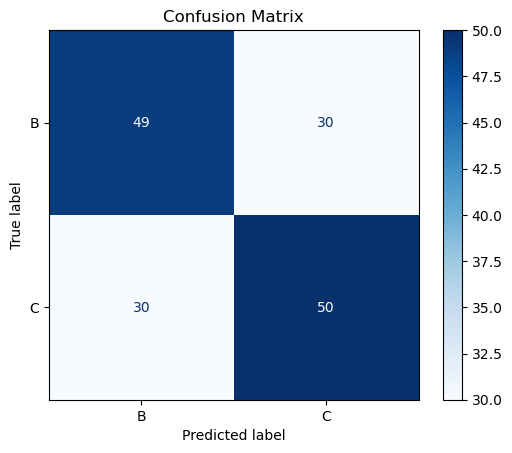

In [ ]:
show_ht_metrics(model_ffnn_adm_ht, X_test, y_test, 'FFNN with Adam Optimizer')

#### Method 1 - FFNN - Optimizer 2 - AdamW

This section creates FFNN with AdamW optimizer and show the results at the end.

In [40]:
labels = ['B','C']
# Run optimization for FFNN with Adam
study_ffnn_adamw = run_hyperparameter_optimization(
    X_train, y_train, X_val, y_val, vocab_size,
    model='FFNN', optimizer='AdamW', n_trials=50
)

[I 2025-06-12 12:04:29,606] A new study created in memory with name: FFNN_AdamW_optimization


Starting hyperparameter optimization for FFNN with AdamW
Running 50 trials...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-12 12:04:32,331] Trial 0 finished with value: 0.6111635316089499 and parameters: {'max_length': 89, 'dropout_rate': 0.3822040625917196, 'l2_reg': 0.03389116281206317, 'penalty_d1': 0.004129783886579619, 'penalty_d2': 0.0038293599100159277, 'dropout_d1': 0.1283083421023232, 'dropout_d2': 0.22812676464877707, 'learning_rate': 0.001298630687119192, 'weight_decay': 0.003792125049870807, 'beta_1': 0.8957078157325111, 'beta_2': 0.9600190176805387, 'epsilon': 8.097134490862541e-07, 'clipvalue': 0.6913826643661555, 'epochs': 22, 'batch_size': 32, 'patience': 7}. Best is trial 0 with value: 0.6111635316089499.
[I 2025-06-12 12:04:35,107] Trial 1 finished with value: 0.6087289448793545 and parameters: {'max_length': 27, 'dropout_rate': 0.30076494927946706, 'l2_reg': 1.0245704009427623e-05, 'penalty_d1': 3.733734077770639e-05, 'penalty_d2': 0.0006172959570094101, 'dropout_d1': 0.41264259421919547, 'dropout_d2': 0.4286696242225002, 'learning_rate': 0.0033907172628199864, 'weight_decay':

In [48]:
model_ffnn_admw_ht, history_ffnn_admw_ht = create_model(study_ffnn_adamw, 'FFNN', 'AdamW')


Starting training...
Epoch 1/10
5/5 [==============================] - 1s 63ms/step - loss: 3.7484 - accuracy: 0.4991 - val_loss: 3.5145 - val_accuracy: 0.4177 - lr: 5.6021e-04
Epoch 2/10
5/5 [==============================] - 0s 14ms/step - loss: 3.3960 - accuracy: 0.5298 - val_loss: 3.1867 - val_accuracy: 0.4304 - lr: 5.6021e-04
Epoch 3/10
5/5 [==============================] - 0s 14ms/step - loss: 3.0758 - accuracy: 0.5787 - val_loss: 2.8905 - val_accuracy: 0.4304 - lr: 5.6021e-04
Epoch 4/10
5/5 [==============================] - 0s 14ms/step - loss: 2.7877 - accuracy: 0.6275 - val_loss: 2.6242 - val_accuracy: 0.4430 - lr: 5.6021e-04
Epoch 5/10
5/5 [==============================] - 0s 14ms/step - loss: 2.5291 - accuracy: 0.6854 - val_loss: 2.3862 - val_accuracy: 0.4684 - lr: 5.6021e-04
Epoch 6/10
5/5 [==============================] - 0s 15ms/step - loss: 2.2984 - accuracy: 0.7034 - val_loss: 2.1740 - val_accuracy: 0.4684 - lr: 5.6021e-04
Epoch 7/10
5/5 [===========================

5/5 [==============================] - 0s 1ms/step

Metrics for FFNN with Adam Optimizer:
Accuracy: 0.5472
Precision: 0.5294
Recall: 0.9000
F1 Score: 0.6667


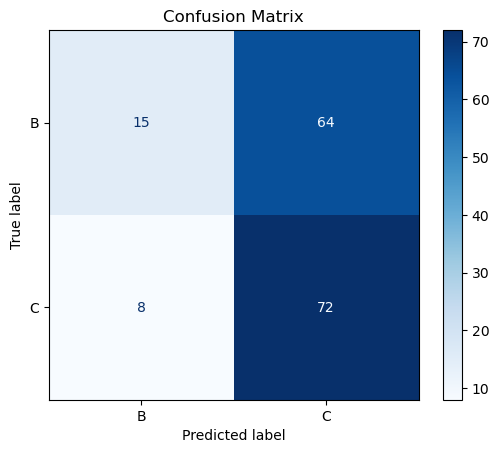

In [49]:
show_ht_metrics(model_ffnn_admw_ht, X_test, y_test, 'FFNN with AdamW Optimizer')

#### Method 1 - FFNN - Optimizer 3 - SGD with Momentum

This section creates FFNN with SGD with momentum optimizer and show the results at the end.

In [50]:
study_ffnn_sgdm = run_hyperparameter_optimization(
    X_train, y_train, X_val, y_val, vocab_size,
    model='FFNN', optimizer='SGDM', n_trials=50
)

[I 2025-06-12 12:22:43,540] A new study created in memory with name: FFNN_SGDM_optimization


Starting hyperparameter optimization for FFNN with SGDM
Running 50 trials...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-12 12:22:45,245] Trial 0 finished with value: 0.6012658227848102 and parameters: {'max_length': 97, 'dropout_rate': 0.35085497709266356, 'l2_reg': 0.00028144337970961253, 'penalty_d1': 0.09902315209882152, 'penalty_d2': 0.004031872818149473, 'dropout_d1': 0.29079779293013197, 'dropout_d2': 0.2926378426735453, 'learning_rate': 0.028651789687744754, 'momentum': 0.9205352759844978, 'nesterov': False, 'clipvalue': 1.9940776597466732, 'epochs': 15, 'batch_size': 64, 'patience': 7}. Best is trial 0 with value: 0.6012658227848102.
[I 2025-06-12 12:22:46,867] Trial 1 finished with value: 0.39795234549516006 and parameters: {'max_length': 77, 'dropout_rate': 0.2869085563146795, 'l2_reg': 0.0029101953916537276, 'penalty_d1': 3.3670431424413455e-05, 'penalty_d2': 1.77924565346543e-05, 'dropout_d1': 0.25132997219715525, 'dropout_d2': 0.4682956169920294, 'learning_rate': 0.020125781322850592, 'momentum': 0.9666013088027001, 'nesterov': False, 'clipvalue': 1.4084531929351887, 'epochs': 7,

In [51]:
model_ffnn_sgdm_ht, history_ffnn_sgdm_ht = create_model(study_ffnn_sgdm, 'FFNN', 'SGDM')

Starting training...
Epoch 1/14
9/9 [==============================] - 1s 31ms/step - loss: 0.9066 - accuracy: 0.5118 - val_loss: 0.9049 - val_accuracy: 0.5316 - lr: 0.0270
Epoch 2/14
9/9 [==============================] - 0s 6ms/step - loss: 0.9031 - accuracy: 0.4882 - val_loss: 0.8979 - val_accuracy: 0.6076 - lr: 0.0270
Epoch 3/14
9/9 [==============================] - 0s 6ms/step - loss: 0.8962 - accuracy: 0.5353 - val_loss: 0.8929 - val_accuracy: 0.5063 - lr: 0.0270
Epoch 4/14
9/9 [==============================] - 0s 6ms/step - loss: 0.8898 - accuracy: 0.5515 - val_loss: 0.8883 - val_accuracy: 0.4684 - lr: 0.0270
Epoch 5/14
9/9 [==============================] - 0s 6ms/step - loss: 0.8810 - accuracy: 0.6094 - val_loss: 0.8826 - val_accuracy: 0.5190 - lr: 0.0270
Epoch 6/14
9/9 [==============================] - 0s 6ms/step - loss: 0.8754 - accuracy: 0.5588 - val_loss: 0.8778 - val_accuracy: 0.4557 - lr: 0.0270
Epoch 7/14
9/9 [==============================] - 0s 6ms/step - loss: 0.

5/5 [==============================] - 0s 2ms/step

Metrics for FFNN with Adam Optimizer:
Accuracy: 0.5912
Precision: 0.5904
Recall: 0.6125
F1 Score: 0.6012


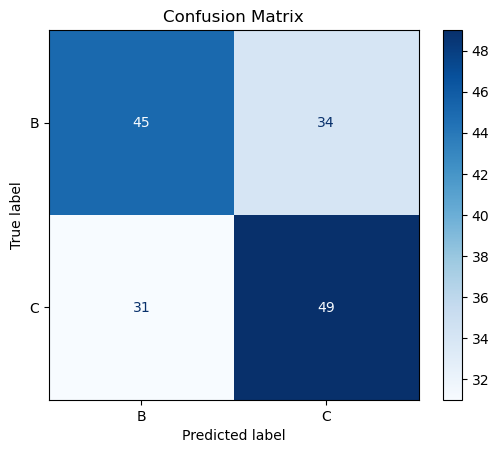

In [52]:
show_ht_metrics(model_ffnn_sgdm_ht, X_test, y_test, 'FFNN with SGDM Optimizer')

#### Method 2 - LSTM - Optimizer 1 - Adam

This section creates LSTM with Adam optimizer and show the results at the end.

In [59]:
study_lstm_adam = run_hyperparameter_optimization(
    X_train, y_train, X_val, y_val, vocab_size,
    model='LSTM', optimizer='Adam', n_trials=25
)

[I 2025-06-12 12:55:54,656] A new study created in memory with name: LSTM_Adam_optimization


Starting hyperparameter optimization for LSTM with Adam
Running 25 trials...


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-06-12 12:56:14,671] Trial 0 finished with value: 0.554318689501117 and parameters: {'max_length': 57, 'dropout_rate': 0.24935361725462857, 'l2_reg': 0.005604930163409136, 'lstm_units': 64, 'dropout_rate_lstm1': 0.2957302433550557, 'dropout_rate_lstm2': 0.4550316593860325, 'dropout_rec_lstm1': 0.4986091277563499, 'dropout_rec_lstm2': 0.1755611094757847, 'l2_reg_ker_lstm1': 0.000363025594083585, 'l2_reg_ker_lstm2': 0.0005938941254713527, 'l2_reg_rec_lstm1': 0.01924374442306985, 'l2_reg_rec_lstm2': 0.09651926461884411, 'dropout_rate_dl1': 0.3016278237851886, 'dropout_rate_dl2': 0.48190649431303767, 'l2_reg_dl1': 0.007327998365535932, 'l2_reg_dl2': 2.7931244789947692e-05, 'learning_rate': 0.0006398096677450803, 'beta_1': 0.8129023769399673, 'beta_2': 0.9486640301208243, 'epsilon': 5.31369437764838e-09, 'epochs': 15, 'batch_size': 32, 'patience': 7}. Best is trial 0 with value: 0.554318689501117.
[I 2025-06-12 12:56:57,967] Trial 1 finished with value: 0.6389426656738646 and paramet

In [60]:
model_lstm_adm_ht, history_lstm_adm_ht = create_model(study_lstm_adam, 'LSTM', 'Adam')

Starting training...
Epoch 1/25
9/9 [==============================] - 6s 142ms/step - loss: 6.6808 - accuracy: 0.5136 - val_loss: 6.6268 - val_accuracy: 0.5696 - lr: 1.0053e-04
Epoch 2/25
9/9 [==============================] - 1s 75ms/step - loss: 6.5875 - accuracy: 0.5009 - val_loss: 6.5342 - val_accuracy: 0.6076 - lr: 1.0053e-04
Epoch 3/25
9/9 [==============================] - 1s 75ms/step - loss: 6.4955 - accuracy: 0.5009 - val_loss: 6.4428 - val_accuracy: 0.5316 - lr: 1.0053e-04
Epoch 4/25
9/9 [==============================] - 1s 75ms/step - loss: 6.4046 - accuracy: 0.4901 - val_loss: 6.3526 - val_accuracy: 0.5570 - lr: 1.0053e-04
Epoch 5/25
9/9 [==============================] - 1s 80ms/step - loss: 6.3150 - accuracy: 0.5027 - val_loss: 6.2634 - val_accuracy: 0.5696 - lr: 1.0053e-04
Epoch 6/25
9/9 [==============================] - 1s 77ms/step - loss: 6.2261 - accuracy: 0.5552 - val_loss: 6.1756 - val_accuracy: 0.5316 - lr: 1.0053e-04
Epoch 7/25
9/9 [==========================

5/5 [==============================] - 0s 9ms/step

Metrics for FFNN with Adam Optimizer:
Accuracy: 0.5660
Precision: 0.5932
Recall: 0.4375
F1 Score: 0.5036


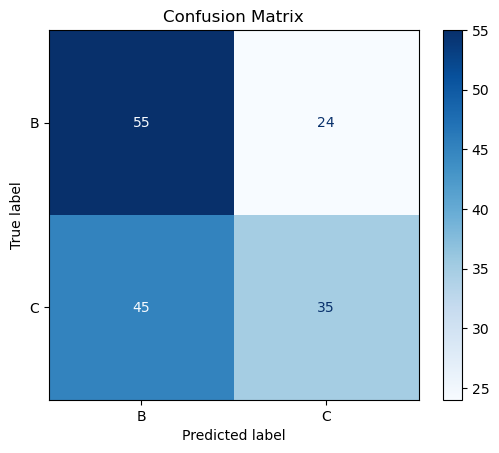

In [61]:
show_ht_metrics(model_lstm_adm_ht, X_test, y_test, 'LSTM with Adam Optimizer')

#### Method 2 - LSTM - Optimizer 2 - AdamW

This section creates LSTM with AdamW optimizer and show the results at the end.

In [62]:
study_lstm_adamw = run_hyperparameter_optimization(
    X_train, y_train, X_val, y_val, vocab_size,
    model='LSTM', optimizer='AdamW', n_trials=25
)

[I 2025-06-12 13:08:59,201] A new study created in memory with name: LSTM_AdamW_optimization


Starting hyperparameter optimization for LSTM with AdamW
Running 25 trials...


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-06-12 13:09:17,686] Trial 0 finished with value: 0.6185219657483246 and parameters: {'max_length': 23, 'dropout_rate': 0.40829981754506117, 'l2_reg': 0.009229364604656745, 'lstm_units': 64, 'dropout_rate_lstm1': 0.3916702570395366, 'dropout_rate_lstm2': 0.43376094765528606, 'dropout_rec_lstm1': 0.37585304619967563, 'dropout_rec_lstm2': 0.2408147728795155, 'l2_reg_ker_lstm1': 0.09170390193913326, 'l2_reg_ker_lstm2': 0.00040411930984229026, 'l2_reg_rec_lstm1': 0.03958530289993192, 'l2_reg_rec_lstm2': 0.0034293937919102372, 'dropout_rate_dl1': 0.3522756155570669, 'dropout_rate_dl2': 0.11279220086554771, 'l2_reg_dl1': 5.8114796283514196e-05, 'l2_reg_dl2': 0.00024028566734441632, 'learning_rate': 0.0006136588999741995, 'weight_decay': 5.447601091574487e-05, 'beta_1': 0.84050449182001, 'beta_2': 0.9202395373673807, 'epsilon': 4.937192761244999e-10, 'clipvalue': 1.0586459173993044, 'epochs': 18, 'batch_size': 64, 'patience': 7}. Best is trial 0 with value: 0.6185219657483246.
[I 2025-

In [63]:
model_lstm_admw_ht, history_lstm_admw_ht = create_model(study_lstm_adamw, 'LSTM', 'AdamW')

Starting training...
Epoch 1/15
5/5 [==============================] - 7s 236ms/step - loss: 2.3295 - accuracy: 0.5063 - val_loss: 2.1860 - val_accuracy: 0.5696 - lr: 0.0012
Epoch 2/15
5/5 [==============================] - 0s 98ms/step - loss: 2.1177 - accuracy: 0.4973 - val_loss: 1.9890 - val_accuracy: 0.5190 - lr: 0.0012
Epoch 3/15
5/5 [==============================] - 1s 121ms/step - loss: 1.9272 - accuracy: 0.5588 - val_loss: 1.8119 - val_accuracy: 0.6076 - lr: 0.0012
Epoch 4/15
5/5 [==============================] - 1s 101ms/step - loss: 1.7575 - accuracy: 0.5515 - val_loss: 1.6565 - val_accuracy: 0.5823 - lr: 0.0012
Epoch 5/15
5/5 [==============================] - 1s 129ms/step - loss: 1.6043 - accuracy: 0.6166 - val_loss: 1.5177 - val_accuracy: 0.5949 - lr: 0.0012
Epoch 6/15
5/5 [==============================] - 1s 114ms/step - loss: 1.4642 - accuracy: 0.6691 - val_loss: 1.3957 - val_accuracy: 0.5443 - lr: 0.0012
Epoch 7/15
5/5 [==============================] - 1s 124ms/ste

5/5 [==============================] - 0s 10ms/step

Metrics for FFNN with Adam Optimizer:
Accuracy: 0.5786
Precision: 0.5844
Recall: 0.5625
F1 Score: 0.5732


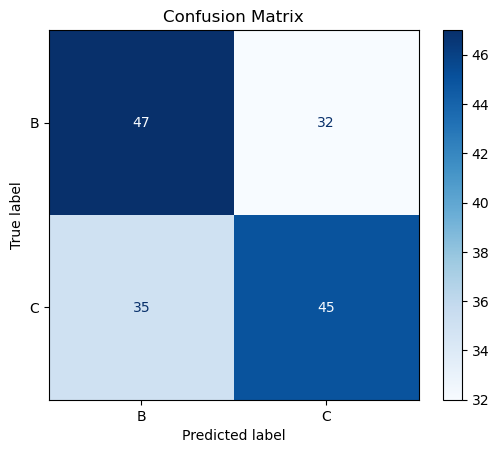

In [64]:
show_ht_metrics(model_lstm_admw_ht, X_test, y_test, 'LSTM with AdamW Optimizer')

#### Method 2 - LSTM - Optimizer 3 - SGD with Momentum

This section creates LSTM with SGD with momentum optimizer and show the results at the end.

In [65]:
study_lstm_sgdm = run_hyperparameter_optimization(
    X_train, y_train, X_val, y_val, vocab_size,
    model='LSTM', optimizer='SGDM', n_trials=25
)

[I 2025-06-12 13:19:37,816] A new study created in memory with name: LSTM_SGDM_optimization


Starting hyperparameter optimization for LSTM with SGDM
Running 25 trials...


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-06-12 13:20:09,402] Trial 0 finished with value: 0.5417349218168279 and parameters: {'max_length': 94, 'dropout_rate': 0.3356775238471024, 'l2_reg': 3.308094347563962e-05, 'lstm_units': 48, 'dropout_rate_lstm1': 0.10318533800408632, 'dropout_rate_lstm2': 0.1745735577693005, 'dropout_rec_lstm1': 0.41937211700490473, 'dropout_rec_lstm2': 0.1760709458881542, 'l2_reg_ker_lstm1': 0.00015327369233261132, 'l2_reg_ker_lstm2': 0.02257483487435616, 'l2_reg_rec_lstm1': 0.028867370073054517, 'l2_reg_rec_lstm2': 0.0017313757961273403, 'dropout_rate_dl1': 0.13219427081997323, 'dropout_rate_dl2': 0.16941009854080852, 'l2_reg_dl1': 0.05711404295920251, 'l2_reg_dl2': 0.008425116694245595, 'learning_rate': 0.0001084843515535566, 'momentum': 0.9047048941498748, 'nesterov': False, 'clipvalue': 1.5676152864845807, 'epochs': 21, 'batch_size': 16, 'patience': 7}. Best is trial 0 with value: 0.5417349218168279.
[I 2025-06-12 13:20:24,633] Trial 1 finished with value: 0.6012658227848102 and parameters:

In [66]:
model_lstm_sgdm_ht, history_lstm_sgdm_ht = create_model(study_lstm_sgdm, 'LSTM', 'SGDM')

Starting training...
Epoch 1/13
5/5 [==============================] - 6s 260ms/step - loss: 5.1740 - accuracy: 0.5154 - val_loss: 5.1693 - val_accuracy: 0.4430 - lr: 9.5893e-04
Epoch 2/13
5/5 [==============================] - 1s 126ms/step - loss: 5.1650 - accuracy: 0.5136 - val_loss: 5.1566 - val_accuracy: 0.4430 - lr: 9.5893e-04
Epoch 3/13
5/5 [==============================] - 1s 124ms/step - loss: 5.1512 - accuracy: 0.4810 - val_loss: 5.1408 - val_accuracy: 0.4177 - lr: 9.5893e-04
Epoch 4/13
5/5 [==============================] - 1s 128ms/step - loss: 5.1349 - accuracy: 0.5063 - val_loss: 5.1236 - val_accuracy: 0.3924 - lr: 9.5893e-04
Epoch 5/13
5/5 [==============================] - 1s 127ms/step - loss: 5.1175 - accuracy: 0.4919 - val_loss: 5.1057 - val_accuracy: 0.4557 - lr: 9.5893e-04
Epoch 6/13
5/5 [==============================] - 1s 127ms/step - loss: 5.0994 - accuracy: 0.5172 - val_loss: 5.0875 - val_accuracy: 0.4810 - lr: 9.5893e-04
Epoch 7/13
5/5 [=====================

5/5 [==============================] - 0s 19ms/step

Metrics for FFNN with Adam Optimizer:
Accuracy: 0.5031
Precision: 0.5039
Recall: 0.8125
F1 Score: 0.6220


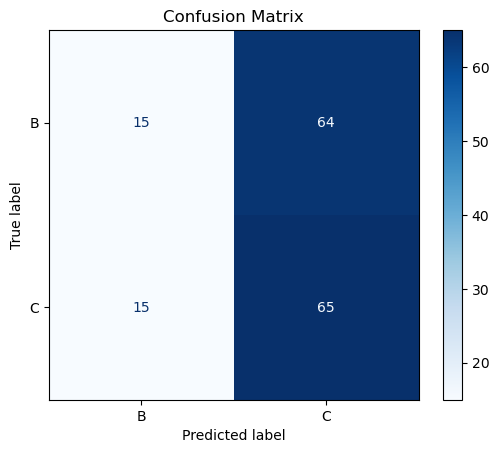

In [67]:
show_ht_metrics(model_lstm_sgdm_ht, X_test, y_test, 'LSTM with SGDM Optimizer')

#### Method 3 - Transformer BERT Classifier - Optimizer 1 - Adam

This section creates BERT with Adam optimizer and show the results at the end.

In [27]:
study_bert_adam = run_hyperparameter_optimization(
    X_train, y_train, X_val, y_val, vocab_size,
    model='BERT', optimizer='Adam', n_trials=20
)

[I 2025-06-12 18:19:48,802] A new study created in memory with name: BERT_Adam_optimization


Starting hyperparameter optimization for BERT with Adam
Running 20 trials...


  0%|          | 0/20 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:21:03,401] Trial 0 finished with value: 0.2278481012658228 and parameters: {'max_length': 89, 'dropout_rate': 0.16949485524677976, 'l2_reg': 8.679143061017483e-05, 'dropout_rate_bert': 0.4126067198202017, 'dropout_rate_cd1': 0.24730948928127813, 'dropout_rate_cd2': 0.1293271489213193, 'dropout_rate_cd3': 0.1295061599209093, 'dropout_rate_cd4': 0.173297251530374, 'l2_reg_bert': 0.0077819564580094884, 'l2_reg_cd1': 0.01755090599449656, 'l2_reg_cd2': 0.014351644259691407, 'l2_reg_cd3': 0.0036791260961551277, 'learning_rate': 0.0004921014236212167, 'beta_1': 0.8396694583200154, 'beta_2': 0.980163602540164, 'epsilon': 3.279962867298297e-08, 'epochs': 9, 'batch_size': 64, 'patience': 5}. Best is trial 0 with value: 0.2278481012658228.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:22:59,386] Trial 1 finished with value: 0.6012658227848102 and parameters: {'max_length': 89, 'dropout_rate': 0.3053504845603177, 'l2_reg': 0.028089126783392687, 'dropout_rate_bert': 0.46925993892930873, 'dropout_rate_cd1': 0.16070303854244428, 'dropout_rate_cd2': 0.13026475867419088, 'dropout_rate_cd3': 0.2600097880599501, 'dropout_rate_cd4': 0.11403597699889954, 'l2_reg_bert': 9.80306066186464e-05, 'l2_reg_cd1': 0.0011713783056463956, 'l2_reg_cd2': 0.00021657811282561524, 'l2_reg_cd3': 0.011304602469004207, 'learning_rate': 0.0015650981892977812, 'beta_1': 0.879086945309014, 'beta_2': 0.9591314869237952, 'epsilon': 5.42507658056783e-09, 'epochs': 7, 'batch_size': 16, 'patience': 7}. Best is trial 1 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:25:04,876] Trial 2 finished with value: 0.3739620509923743 and parameters: {'max_length': 85, 'dropout_rate': 0.28498238891631167, 'l2_reg': 3.491451171690597e-05, 'dropout_rate_bert': 0.4656200501269919, 'dropout_rate_cd1': 0.3077686819160905, 'dropout_rate_cd2': 0.42684627352734106, 'dropout_rate_cd3': 0.1646333576423401, 'dropout_rate_cd4': 0.24413638284076247, 'l2_reg_bert': 0.0006120640766733204, 'l2_reg_cd1': 3.8576709520975384e-05, 'l2_reg_cd2': 0.0002069394603625725, 'l2_reg_cd3': 0.01777244132874744, 'learning_rate': 4.3416708858976473e-05, 'beta_1': 0.9321872273844708, 'beta_2': 0.9924035245867009, 'epsilon': 6.383338141564683e-09, 'epochs': 7, 'batch_size': 32, 'patience': 7}. Best is trial 1 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:26:59,638] Trial 3 finished with value: 0.26459757666012323 and parameters: {'max_length': 33, 'dropout_rate': 0.4828371839412895, 'l2_reg': 0.00012317250255259438, 'dropout_rate_bert': 0.1813162578217168, 'dropout_rate_cd1': 0.2774276277157056, 'dropout_rate_cd2': 0.30929755807438136, 'dropout_rate_cd3': 0.22137477910997394, 'dropout_rate_cd4': 0.17669315282632236, 'l2_reg_bert': 0.07834276486684721, 'l2_reg_cd1': 0.0038715304380602627, 'l2_reg_cd2': 0.06768473816871817, 'l2_reg_cd3': 0.008183050609624466, 'learning_rate': 6.301726786571694e-05, 'beta_1': 0.9142428527704536, 'beta_2': 0.9562766526070343, 'epsilon': 5.126190104769863e-07, 'epochs': 7, 'batch_size': 16, 'patience': 5}. Best is trial 1 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:28:51,736] Trial 4 finished with value: 0.315372172439469 and parameters: {'max_length': 71, 'dropout_rate': 0.22345267747802808, 'l2_reg': 0.00012831568367868197, 'dropout_rate_bert': 0.3036150701676832, 'dropout_rate_cd1': 0.20840413285210266, 'dropout_rate_cd2': 0.4852887740018633, 'dropout_rate_cd3': 0.3290664321311131, 'dropout_rate_cd4': 0.2749507252330906, 'l2_reg_bert': 0.00024556039641817815, 'l2_reg_cd1': 0.0010269734170431154, 'l2_reg_cd2': 5.9408286859214704e-05, 'l2_reg_cd3': 1.0977066228430036e-05, 'learning_rate': 0.0016113168700248805, 'beta_1': 0.9465981893707327, 'beta_2': 0.954502918215952, 'epsilon': 9.188332288063298e-07, 'epochs': 20, 'batch_size': 128, 'patience': 6}. Best is trial 1 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:31:10,535] Trial 5 finished with value: 0.2278481012658228 and parameters: {'max_length': 90, 'dropout_rate': 0.15979551953347212, 'l2_reg': 0.0038800754197320297, 'dropout_rate_bert': 0.10844694655675191, 'dropout_rate_cd1': 0.3928523254721631, 'dropout_rate_cd2': 0.410906159899986, 'dropout_rate_cd3': 0.24176218029055696, 'dropout_rate_cd4': 0.38788411141114365, 'l2_reg_bert': 0.09590349204568777, 'l2_reg_cd1': 0.008767469940186073, 'l2_reg_cd2': 0.0018674994950810173, 'l2_reg_cd3': 0.0009965798253765488, 'learning_rate': 0.00010017240585213093, 'beta_1': 0.8649763040364364, 'beta_2': 0.9536087777464816, 'epsilon': 6.81174180331604e-10, 'epochs': 23, 'batch_size': 16, 'patience': 5}. Best is trial 1 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:33:23,690] Trial 6 finished with value: 0.4245495160089352 and parameters: {'max_length': 23, 'dropout_rate': 0.15302860906573273, 'l2_reg': 0.00010630001726946053, 'dropout_rate_bert': 0.25344084765264285, 'dropout_rate_cd1': 0.2983554926079113, 'dropout_rate_cd2': 0.30545941118038306, 'dropout_rate_cd3': 0.21746263776342847, 'dropout_rate_cd4': 0.16975775845135677, 'l2_reg_bert': 0.00029815978626906357, 'l2_reg_cd1': 0.00353233470914268, 'l2_reg_cd2': 0.002415001480999745, 'l2_reg_cd3': 0.0002652737313983837, 'learning_rate': 2.0892104280465288e-05, 'beta_1': 0.8748442673042202, 'beta_2': 0.9399654735154424, 'epsilon': 1.8096855753791897e-10, 'epochs': 16, 'batch_size': 16, 'patience': 4}. Best is trial 1 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:35:09,303] Trial 7 finished with value: 0.6012658227848102 and parameters: {'max_length': 41, 'dropout_rate': 0.15315405617593336, 'l2_reg': 0.007696883241488925, 'dropout_rate_bert': 0.4665379686093426, 'dropout_rate_cd1': 0.2234899886530021, 'dropout_rate_cd2': 0.1557893002465488, 'dropout_rate_cd3': 0.1207350028166657, 'dropout_rate_cd4': 0.3162744138356939, 'l2_reg_bert': 0.002535416114181036, 'l2_reg_cd1': 0.0005901664590731672, 'l2_reg_cd2': 0.0003795727510181016, 'l2_reg_cd3': 0.0010397148780679176, 'learning_rate': 1.2429372572624925e-05, 'beta_1': 0.9259001762046057, 'beta_2': 0.9329981712230911, 'epsilon': 2.9303050975105954e-08, 'epochs': 12, 'batch_size': 128, 'patience': 5}. Best is trial 1 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:37:48,759] Trial 8 finished with value: 0.5535311300761784 and parameters: {'max_length': 51, 'dropout_rate': 0.20195325000913905, 'l2_reg': 0.0018965083387906417, 'dropout_rate_bert': 0.2743562277158702, 'dropout_rate_cd1': 0.2781900948734469, 'dropout_rate_cd2': 0.2475936945834384, 'dropout_rate_cd3': 0.2165351226897074, 'dropout_rate_cd4': 0.47166337732592545, 'l2_reg_bert': 0.0002253173005854536, 'l2_reg_cd1': 0.018699647630137817, 'l2_reg_cd2': 3.093211823474108e-05, 'l2_reg_cd3': 1.2487335709476906e-05, 'learning_rate': 2.3107208754890426e-05, 'beta_1': 0.8537567277472253, 'beta_2': 0.9544849021269914, 'epsilon': 1.8236283717869713e-07, 'epochs': 26, 'batch_size': 32, 'patience': 7}. Best is trial 1 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:39:45,380] Trial 9 finished with value: 0.5413998510796724 and parameters: {'max_length': 72, 'dropout_rate': 0.33644895724911855, 'l2_reg': 0.00017609387098306762, 'dropout_rate_bert': 0.4106904161428061, 'dropout_rate_cd1': 0.31754235354595545, 'dropout_rate_cd2': 0.12201503206538732, 'dropout_rate_cd3': 0.3262690497450872, 'dropout_rate_cd4': 0.48407664271964734, 'l2_reg_bert': 0.001918315832180664, 'l2_reg_cd1': 0.0001450250188778155, 'l2_reg_cd2': 0.025743679118016696, 'l2_reg_cd3': 0.004587350060655391, 'learning_rate': 0.0017708292543845328, 'beta_1': 0.9468458775151353, 'beta_2': 0.9202422509294962, 'epsilon': 5.19362080455736e-09, 'epochs': 10, 'batch_size': 64, 'patience': 5}. Best is trial 1 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:43:19,970] Trial 10 finished with value: 0.6012658227848102 and parameters: {'max_length': 100, 'dropout_rate': 0.4155424538304502, 'l2_reg': 0.08084147393525315, 'dropout_rate_bert': 0.3486930091716041, 'dropout_rate_cd1': 0.11083342873215618, 'dropout_rate_cd2': 0.20705111584045183, 'dropout_rate_cd3': 0.4588607221929143, 'dropout_rate_cd4': 0.1039578266316113, 'l2_reg_bert': 1.5654347697843173e-05, 'l2_reg_cd1': 0.05692102365241577, 'l2_reg_cd2': 1.6867106278824543e-05, 'l2_reg_cd3': 0.09660548077963663, 'learning_rate': 0.006498966624884907, 'beta_1': 0.8103433082139967, 'beta_2': 0.9037395232768671, 'epsilon': 1.0415449255957988e-09, 'epochs': 15, 'batch_size': 16, 'patience': 8}. Best is trial 1 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:44:48,468] Trial 11 finished with value: 0.6079844206426486 and parameters: {'max_length': 44, 'dropout_rate': 0.3137208760168183, 'l2_reg': 0.0331890699907619, 'dropout_rate_bert': 0.4951102710076642, 'dropout_rate_cd1': 0.14830238463399129, 'dropout_rate_cd2': 0.18158192346191213, 'dropout_rate_cd3': 0.10430482334333507, 'dropout_rate_cd4': 0.3559660516917275, 'l2_reg_bert': 2.4811125979901824e-05, 'l2_reg_cd1': 0.00025261784730499603, 'l2_reg_cd2': 0.00034536114296470835, 'l2_reg_cd3': 0.00023997157215456164, 'learning_rate': 0.0003070279499143417, 'beta_1': 0.9018282635253946, 'beta_2': 0.9312363199099457, 'epsilon': 3.8614204075947624e-08, 'epochs': 13, 'batch_size': 128, 'patience': 3}. Best is trial 11 with value: 0.6079844206426486.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:45:50,424] Trial 12 finished with value: 0.2278481012658228 and parameters: {'max_length': 62, 'dropout_rate': 0.3321064102659953, 'l2_reg': 0.06175022537819843, 'dropout_rate_bert': 0.49663216507326224, 'dropout_rate_cd1': 0.10356184193551679, 'dropout_rate_cd2': 0.207594159694342, 'dropout_rate_cd3': 0.4050165916362632, 'dropout_rate_cd4': 0.3672310358561495, 'l2_reg_bert': 2.201055886335697e-05, 'l2_reg_cd1': 0.00015854079686999865, 'l2_reg_cd2': 0.0001893949476071203, 'l2_reg_cd3': 8.879400701298996e-05, 'learning_rate': 0.0003629289837987537, 'beta_1': 0.8986463192585138, 'beta_2': 0.9228114054119194, 'epsilon': 5.364211379083509e-08, 'epochs': 14, 'batch_size': 128, 'patience': 3}. Best is trial 11 with value: 0.6079844206426486.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:46:52,707] Trial 13 finished with value: 0.619197972235539 and parameters: {'max_length': 49, 'dropout_rate': 0.2684535977088203, 'l2_reg': 0.017626559798377635, 'dropout_rate_bert': 0.39502014234852706, 'dropout_rate_cd1': 0.16623737645472086, 'dropout_rate_cd2': 0.10106932967240442, 'dropout_rate_cd3': 0.28479166543206014, 'dropout_rate_cd4': 0.4014843112380084, 'l2_reg_bert': 5.2159934890537625e-05, 'l2_reg_cd1': 2.0417416697149372e-05, 'l2_reg_cd2': 0.0006924282123619156, 'l2_reg_cd3': 0.00012460524410757914, 'learning_rate': 0.0010642020825243346, 'beta_1': 0.8995753485221198, 'beta_2': 0.9701385356117479, 'epsilon': 2.6312595259125764e-09, 'epochs': 6, 'batch_size': 128, 'patience': 3}. Best is trial 13 with value: 0.619197972235539.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:47:54,669] Trial 14 finished with value: 0.6012658227848102 and parameters: {'max_length': 10, 'dropout_rate': 0.40183846247403665, 'l2_reg': 0.015555099308218315, 'dropout_rate_bert': 0.39018649324446175, 'dropout_rate_cd1': 0.48628836901749495, 'dropout_rate_cd2': 0.19508363398314418, 'dropout_rate_cd3': 0.3883530479669563, 'dropout_rate_cd4': 0.4147006395148855, 'l2_reg_bert': 7.059717687359776e-05, 'l2_reg_cd1': 1.3150990216157827e-05, 'l2_reg_cd2': 0.0009049725854202457, 'l2_reg_cd3': 7.667711931386742e-05, 'learning_rate': 0.00015568415163867442, 'beta_1': 0.8968020541257264, 'beta_2': 0.9743293950517868, 'epsilon': 6.965183346809946e-10, 'epochs': 5, 'batch_size': 128, 'patience': 3}. Best is trial 13 with value: 0.619197972235539.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:49:00,706] Trial 15 finished with value: 0.6012658227848102 and parameters: {'max_length': 48, 'dropout_rate': 0.2555176270257551, 'l2_reg': 0.0008787092969626002, 'dropout_rate_bert': 0.35590962356828604, 'dropout_rate_cd1': 0.17292076416436647, 'dropout_rate_cd2': 0.10295677411153352, 'dropout_rate_cd3': 0.1730647162765735, 'dropout_rate_cd4': 0.35353041613450786, 'l2_reg_bert': 1.0742609577640506e-05, 'l2_reg_cd1': 7.872393758070455e-05, 'l2_reg_cd2': 0.0032984623148804956, 'l2_reg_cd3': 7.257315272563082e-05, 'learning_rate': 0.0007049673439327662, 'beta_1': 0.90075679137364, 'beta_2': 0.9746804276133725, 'epsilon': 1.703365226807761e-08, 'epochs': 20, 'batch_size': 128, 'patience': 3}. Best is trial 13 with value: 0.619197972235539.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:50:20,763] Trial 16 finished with value: 0.2278481012658228 and parameters: {'max_length': 31, 'dropout_rate': 0.10012131881275538, 'l2_reg': 0.020638438647622305, 'dropout_rate_bert': 0.42158729164789355, 'dropout_rate_cd1': 0.16039990831238293, 'dropout_rate_cd2': 0.2573599679215378, 'dropout_rate_cd3': 0.293377385270062, 'dropout_rate_cd4': 0.42422766006495455, 'l2_reg_bert': 4.4109862254061026e-05, 'l2_reg_cd1': 1.6747442935545424e-05, 'l2_reg_cd2': 0.0006734912401841999, 'l2_reg_cd3': 0.00034997754359356904, 'learning_rate': 0.005855043994596413, 'beta_1': 0.8882939570793789, 'beta_2': 0.9019584394576502, 'epsilon': 9.582621950339514e-08, 'epochs': 29, 'batch_size': 128, 'patience': 4}. Best is trial 13 with value: 0.619197972235539.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:51:37,775] Trial 17 finished with value: 0.6012658227848102 and parameters: {'max_length': 63, 'dropout_rate': 0.37743072535688404, 'l2_reg': 0.0006978659143926552, 'dropout_rate_bert': 0.32021006967343474, 'dropout_rate_cd1': 0.14754245226130075, 'dropout_rate_cd2': 0.17429362834843148, 'dropout_rate_cd3': 0.4861468209576396, 'dropout_rate_cd4': 0.3307260326810108, 'l2_reg_bert': 4.464951541142201e-05, 'l2_reg_cd1': 0.00032093389822960726, 'l2_reg_cd2': 0.005611049982717322, 'l2_reg_cd3': 2.8116247610359594e-05, 'learning_rate': 0.00022292313912222243, 'beta_1': 0.9139524110300334, 'beta_2': 0.9986805010553615, 'epsilon': 3.239142830512043e-09, 'epochs': 12, 'batch_size': 128, 'patience': 4}. Best is trial 13 with value: 0.619197972235539.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:52:42,774] Trial 18 finished with value: 0.2278481012658228 and parameters: {'max_length': 41, 'dropout_rate': 0.24441427028533014, 'l2_reg': 1.0183815194926957e-05, 'dropout_rate_bert': 0.49893173579277905, 'dropout_rate_cd1': 0.37043187473188427, 'dropout_rate_cd2': 0.2415653101250208, 'dropout_rate_cd3': 0.36459923918861314, 'dropout_rate_cd4': 0.44281575055270017, 'l2_reg_bert': 0.014045479344800485, 'l2_reg_cd1': 3.637865096578486e-05, 'l2_reg_cd2': 9.610925290144264e-05, 'l2_reg_cd3': 0.0002766293335170747, 'learning_rate': 0.0009587764404693167, 'beta_1': 0.8404664094527332, 'beta_2': 0.9378668139083928, 'epsilon': 1.152832377027669e-10, 'epochs': 19, 'batch_size': 128, 'patience': 3}. Best is trial 13 with value: 0.619197972235539.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 18:54:15,670] Trial 19 finished with value: 0.6012658227848102 and parameters: {'max_length': 14, 'dropout_rate': 0.36071958814983446, 'l2_reg': 0.00568261653809391, 'dropout_rate_bert': 0.36728627024069904, 'dropout_rate_cd1': 0.19899303223568487, 'dropout_rate_cd2': 0.34391200532862437, 'dropout_rate_cd3': 0.10502586061269054, 'dropout_rate_cd4': 0.271437086863856, 'l2_reg_bert': 0.00011284029404454049, 'l2_reg_cd1': 4.529115048363296e-05, 'l2_reg_cd2': 0.008611095984745938, 'l2_reg_cd3': 0.001096319084295619, 'learning_rate': 0.0037875412781334123, 'beta_1': 0.8079167975158702, 'beta_2': 0.965021377455048, 'epsilon': 1.9585887014626997e-09, 'epochs': 12, 'batch_size': 32, 'patience': 4}. Best is trial 13 with value: 0.619197972235539.

Optimization completed!
Best trial: 13
Best combined score: 0.6192
Best parameters: {'max_length': 49, 'dropout_rate': 0.2684535977088203, 'l2_reg': 0.017626559798377635, 'dropout_rate_bert': 0.39502014234852706, 'dropout_rate_cd1': 0.16

In [28]:
model_bert_adm_ht, history_bert_adm_ht = create_model(study_bert_adam, 'BERT', 'Adam')

c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

Starting training...
Epoch 1/6
5/5 [==============================] - 26s 3s/step - loss: 1.0177 - accuracy: 0.4774 - val_loss: 0.0000e+00 - val_accuracy: 0.5696 - lr: 0.0011
Epoch 2/6
5/5 [==============================] - 10s 2s/step - loss: 0.9672 - accuracy: 0.5226 - val_loss: 0.0000e+00 - val_accuracy: 0.5316 - lr: 0.0011
Epoch 3/6
5/5 [==============================] - ETA: 0s - loss: 0.9845 - accuracy: 0.4991
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005321010248735547.
5/5 [==============================] - 10s 2s/step - loss: 0.9845 - accuracy: 0.4991 - val_loss: 0.0000e+00 - val_accuracy: 0.5696 - lr: 0.0011
Epoch 4/6
5/5 [==============================] - 10s 2s/step - loss: 0.9456 - accuracy: 0.4810 - val_loss: 0.0000e+00 - val_accuracy: 0.5696 - lr: 5.3210e-04
Epoch 4: early stopping


5/5 [==============================] - 6s 630ms/step

Metrics for FFNN with Adam Optimizer:
Accuracy: 0.4969
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


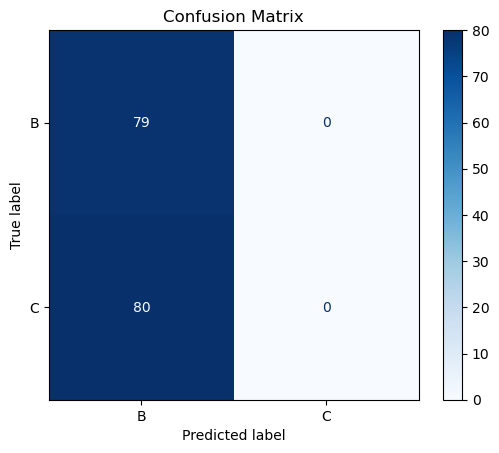

In [29]:
show_ht_metrics(model_bert_adm_ht, X_test, y_test, 'BERT with Adam Optimizer')

#### Method 3 - Transformer BERT Classifier - Optimizer 2 - AdamW

This section creates BERT with AdamW optimizer and show the results at the end.

In [30]:
study_bert_adamw = run_hyperparameter_optimization(
    X_train, y_train, X_val, y_val, vocab_size,
    model='BERT', optimizer='AdamW', n_trials=20
)

[I 2025-06-12 19:02:58,406] A new study created in memory with name: BERT_AdamW_optimization


Starting hyperparameter optimization for BERT with AdamW
Running 20 trials...


  0%|          | 0/20 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:05:50,642] Trial 0 finished with value: 0.6012658227848102 and parameters: {'max_length': 98, 'dropout_rate': 0.18594922918152706, 'l2_reg': 0.050742128138010524, 'dropout_rate_bert': 0.39263824676478076, 'dropout_rate_cd1': 0.2344394442751268, 'dropout_rate_cd2': 0.2441513481254985, 'dropout_rate_cd3': 0.49631111788980065, 'dropout_rate_cd4': 0.45113634216225307, 'l2_reg_bert': 0.043462676235971, 'l2_reg_cd1': 0.0001892180962683743, 'l2_reg_cd2': 0.013977469184249611, 'l2_reg_cd3': 0.021414033210810448, 'learning_rate': 0.009788040702713524, 'weight_decay': 5.349258163284348e-06, 'beta_1': 0.924481117778096, 'beta_2': 0.9018297596903202, 'epsilon': 4.373429127650299e-07, 'clipvalue': 0.9758324886665496, 'epochs': 15, 'batch_size': 16, 'patience': 6}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:07:17,959] Trial 1 finished with value: 0.2278481012658228 and parameters: {'max_length': 94, 'dropout_rate': 0.11657499094758382, 'l2_reg': 0.031183675407288246, 'dropout_rate_bert': 0.14886762804839515, 'dropout_rate_cd1': 0.21752373063521488, 'dropout_rate_cd2': 0.34113065833868067, 'dropout_rate_cd3': 0.10901429126339855, 'dropout_rate_cd4': 0.13269632308236892, 'l2_reg_bert': 0.0001484149837015451, 'l2_reg_cd1': 0.02372576657987717, 'l2_reg_cd2': 0.004119990402615585, 'l2_reg_cd3': 0.002487121093536236, 'learning_rate': 0.0002573229491880261, 'weight_decay': 1.829633990626462e-06, 'beta_1': 0.8048311102195349, 'beta_2': 0.9440275595129052, 'epsilon': 7.798329032220223e-07, 'clipvalue': 1.6113354557076338, 'epochs': 11, 'batch_size': 64, 'patience': 3}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:09:27,046] Trial 2 finished with value: 0.5762924157004574 and parameters: {'max_length': 40, 'dropout_rate': 0.47571289060391286, 'l2_reg': 0.09572082464601221, 'dropout_rate_bert': 0.49078975458387364, 'dropout_rate_cd1': 0.29051877129559284, 'dropout_rate_cd2': 0.318264046837179, 'dropout_rate_cd3': 0.2838822438476689, 'dropout_rate_cd4': 0.18478787265901203, 'l2_reg_bert': 0.0001891083252138201, 'l2_reg_cd1': 2.0435576395240622e-05, 'l2_reg_cd2': 0.0009235150899013346, 'l2_reg_cd3': 0.04050141340216392, 'learning_rate': 4.211505807037705e-05, 'weight_decay': 0.009989265416191658, 'beta_1': 0.8783340155637568, 'beta_2': 0.9650383036799045, 'epsilon': 3.707426907917715e-08, 'clipvalue': 1.2948124261445593, 'epochs': 17, 'batch_size': 64, 'patience': 3}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:13:11,058] Trial 3 finished with value: 0.5918997978938411 and parameters: {'max_length': 18, 'dropout_rate': 0.4679304768714131, 'l2_reg': 0.0015933254797623297, 'dropout_rate_bert': 0.23117925279909596, 'dropout_rate_cd1': 0.19600822411690513, 'dropout_rate_cd2': 0.16205301333953376, 'dropout_rate_cd3': 0.4674557723541134, 'dropout_rate_cd4': 0.47824958610437507, 'l2_reg_bert': 0.04864275867703806, 'l2_reg_cd1': 0.02683458304672695, 'l2_reg_cd2': 0.003980234845945667, 'l2_reg_cd3': 0.047653133339618375, 'learning_rate': 5.794819087963651e-05, 'weight_decay': 6.794223552777564e-06, 'beta_1': 0.928162957917841, 'beta_2': 0.906221973348493, 'epsilon': 2.704080496019192e-09, 'clipvalue': 1.3379916893390726, 'epochs': 10, 'batch_size': 32, 'patience': 8}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:15:36,139] Trial 4 finished with value: 0.4024824737633291 and parameters: {'max_length': 20, 'dropout_rate': 0.12446862446167617, 'l2_reg': 0.006000989704671254, 'dropout_rate_bert': 0.25581673376640146, 'dropout_rate_cd1': 0.3050416378988925, 'dropout_rate_cd2': 0.17480250695650879, 'dropout_rate_cd3': 0.20810092715225637, 'dropout_rate_cd4': 0.3418865034345938, 'l2_reg_bert': 0.013417316836486433, 'l2_reg_cd1': 0.0011201635796512525, 'l2_reg_cd2': 0.0019552169400152758, 'l2_reg_cd3': 0.0006295150858946156, 'learning_rate': 8.325262824369952e-05, 'weight_decay': 4.341691612525797e-05, 'beta_1': 0.9400030151838203, 'beta_2': 0.9308671454151664, 'epsilon': 1.1702810362753822e-09, 'clipvalue': 0.5949511839981962, 'epochs': 23, 'batch_size': 16, 'patience': 5}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:19:24,478] Trial 5 finished with value: 0.5799112683047902 and parameters: {'max_length': 96, 'dropout_rate': 0.48320397533769743, 'l2_reg': 0.0008806254817583826, 'dropout_rate_bert': 0.18075034545799173, 'dropout_rate_cd1': 0.45915068738953824, 'dropout_rate_cd2': 0.3990735115571482, 'dropout_rate_cd3': 0.4219054054228195, 'dropout_rate_cd4': 0.38939996425227863, 'l2_reg_bert': 1.7925747341171216e-05, 'l2_reg_cd1': 0.013140409898178907, 'l2_reg_cd2': 0.00011356632413011739, 'l2_reg_cd3': 0.0005380672222199401, 'learning_rate': 0.0019341013924083497, 'weight_decay': 0.0018134259715980932, 'beta_1': 0.9438997060259432, 'beta_2': 0.9585686646472137, 'epsilon': 3.3526394871263085e-09, 'clipvalue': 1.0768484821016118, 'epochs': 27, 'batch_size': 16, 'patience': 6}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:22:08,438] Trial 6 finished with value: 0.377014471170967 and parameters: {'max_length': 51, 'dropout_rate': 0.27695625109975236, 'l2_reg': 0.013510015464147275, 'dropout_rate_bert': 0.14161158958872347, 'dropout_rate_cd1': 0.22080328803150262, 'dropout_rate_cd2': 0.27418210299013845, 'dropout_rate_cd3': 0.45663106848514856, 'dropout_rate_cd4': 0.11966549154758642, 'l2_reg_bert': 0.00461342876770095, 'l2_reg_cd1': 1.0018927575443732e-05, 'l2_reg_cd2': 0.006243339283229176, 'l2_reg_cd3': 0.0001697064409790911, 'learning_rate': 9.777116160428923e-05, 'weight_decay': 0.00016177893338417234, 'beta_1': 0.8924388641360712, 'beta_2': 0.9677408996318985, 'epsilon': 2.449322090586755e-07, 'clipvalue': 1.5056472955094184, 'epochs': 22, 'batch_size': 128, 'patience': 8}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:24:19,716] Trial 7 finished with value: 0.6012658227848102 and parameters: {'max_length': 14, 'dropout_rate': 0.3069738444698352, 'l2_reg': 1.646950448229112e-05, 'dropout_rate_bert': 0.49393225072253066, 'dropout_rate_cd1': 0.40262826022025433, 'dropout_rate_cd2': 0.3610537458682286, 'dropout_rate_cd3': 0.472801366500082, 'dropout_rate_cd4': 0.2218263791134049, 'l2_reg_bert': 0.018260912947818373, 'l2_reg_cd1': 5.778997289442245e-05, 'l2_reg_cd2': 3.102105914143911e-05, 'l2_reg_cd3': 0.031380716022593395, 'learning_rate': 0.00010296412582589719, 'weight_decay': 1.7654805841668426e-06, 'beta_1': 0.9240966950499754, 'beta_2': 0.9326454140607556, 'epsilon': 2.386220156639905e-09, 'clipvalue': 0.6424202875715581, 'epochs': 12, 'batch_size': 16, 'patience': 5}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:27:00,940] Trial 8 finished with value: 0.6012658227848102 and parameters: {'max_length': 81, 'dropout_rate': 0.3622519219892746, 'l2_reg': 4.246527941982072e-05, 'dropout_rate_bert': 0.27652493840480563, 'dropout_rate_cd1': 0.20398609524326364, 'dropout_rate_cd2': 0.1038611053853876, 'dropout_rate_cd3': 0.22144470280755552, 'dropout_rate_cd4': 0.242431711393075, 'l2_reg_bert': 1.1720302176221333e-05, 'l2_reg_cd1': 0.0008907887404606446, 'l2_reg_cd2': 0.0007457723255063735, 'l2_reg_cd3': 0.0008715328305676986, 'learning_rate': 0.0008052764532950236, 'weight_decay': 0.0001797297609307014, 'beta_1': 0.8677888357524898, 'beta_2': 0.9225308826359225, 'epsilon': 2.1718001118476938e-10, 'clipvalue': 0.9746421760049045, 'epochs': 30, 'batch_size': 64, 'patience': 7}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:28:41,732] Trial 9 finished with value: 0.5757573382450915 and parameters: {'max_length': 46, 'dropout_rate': 0.25520645119676244, 'l2_reg': 0.0028397275566957926, 'dropout_rate_bert': 0.38112939243480626, 'dropout_rate_cd1': 0.34798379652355244, 'dropout_rate_cd2': 0.4613516044421875, 'dropout_rate_cd3': 0.13000398868421265, 'dropout_rate_cd4': 0.4565154231329064, 'l2_reg_bert': 0.00023494710626148233, 'l2_reg_cd1': 0.021853501525646586, 'l2_reg_cd2': 0.00016939477481119614, 'l2_reg_cd3': 0.06643775944247356, 'learning_rate': 0.00017190586669597294, 'weight_decay': 0.0015371823924708546, 'beta_1': 0.8324816472494634, 'beta_2': 0.9903121744741692, 'epsilon': 1.0329384862387245e-08, 'clipvalue': 0.8084678000384413, 'epochs': 13, 'batch_size': 128, 'patience': 5}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:31:00,293] Trial 10 finished with value: 0.5961382715041973 and parameters: {'max_length': 69, 'dropout_rate': 0.1934172531428477, 'l2_reg': 0.00014915792499368865, 'dropout_rate_bert': 0.3707802659216193, 'dropout_rate_cd1': 0.10721231783823953, 'dropout_rate_cd2': 0.24189557122431488, 'dropout_rate_cd3': 0.37653645415130016, 'dropout_rate_cd4': 0.3918789163629023, 'l2_reg_bert': 0.09846387211511816, 'l2_reg_cd1': 0.00024778545365545206, 'l2_reg_cd2': 0.05324606704696743, 'l2_reg_cd3': 0.004020346786264854, 'learning_rate': 0.009005277809844987, 'weight_decay': 1.4770010112957305e-05, 'beta_1': 0.9097498322635306, 'beta_2': 0.9070036077224045, 'epsilon': 8.587836285587271e-08, 'clipvalue': 1.8809351815445616, 'epochs': 7, 'batch_size': 32, 'patience': 6}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:33:05,022] Trial 11 finished with value: 0.589297860779618 and parameters: {'max_length': 68, 'dropout_rate': 0.3434025138148308, 'l2_reg': 2.1318728345075652e-05, 'dropout_rate_bert': 0.49170210471941245, 'dropout_rate_cd1': 0.4553722394526977, 'dropout_rate_cd2': 0.38756888114912125, 'dropout_rate_cd3': 0.4997291800609151, 'dropout_rate_cd4': 0.2892483847200966, 'l2_reg_bert': 0.0050411929165459345, 'l2_reg_cd1': 7.745774055843322e-05, 'l2_reg_cd2': 1.1268481012313667e-05, 'l2_reg_cd3': 1.4416730378579e-05, 'learning_rate': 1.2440328918564936e-05, 'weight_decay': 1.0229380363644763e-06, 'beta_1': 0.9104338169024419, 'beta_2': 0.9278554001392425, 'epsilon': 3.2739774861351003e-10, 'clipvalue': 0.5120468878443252, 'epochs': 16, 'batch_size': 16, 'patience': 4}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:35:27,522] Trial 12 finished with value: 0.4270929628120653 and parameters: {'max_length': 33, 'dropout_rate': 0.19471349982859534, 'l2_reg': 0.00036599417033813647, 'dropout_rate_bert': 0.4094277222359598, 'dropout_rate_cd1': 0.3897587582482893, 'dropout_rate_cd2': 0.2240984600334167, 'dropout_rate_cd3': 0.36665176938096294, 'dropout_rate_cd4': 0.2271875585864377, 'l2_reg_bert': 0.019546417423939064, 'l2_reg_cd1': 9.74419540475486e-05, 'l2_reg_cd2': 0.06114889329320287, 'l2_reg_cd3': 0.010311595393413635, 'learning_rate': 0.009151276082095651, 'weight_decay': 4.390654340284351e-06, 'beta_1': 0.9162789613967587, 'beta_2': 0.9002283777435673, 'epsilon': 1.4289695036745363e-08, 'clipvalue': 0.7979621565558448, 'epochs': 6, 'batch_size': 16, 'patience': 5}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:38:32,686] Trial 13 finished with value: 0.3617265677496686 and parameters: {'max_length': 11, 'dropout_rate': 0.3760562815609029, 'l2_reg': 6.329544104418561e-05, 'dropout_rate_bert': 0.4373690790664985, 'dropout_rate_cd1': 0.39935862626988755, 'dropout_rate_cd2': 0.48019390510061705, 'dropout_rate_cd3': 0.38841055862189944, 'dropout_rate_cd4': 0.2993902980222618, 'l2_reg_bert': 0.0013534998293389838, 'l2_reg_cd1': 0.0007669164867753794, 'l2_reg_cd2': 1.2073800089400775e-05, 'l2_reg_cd3': 0.012113438864132367, 'learning_rate': 0.0010132276088752215, 'weight_decay': 2.4705060899010567e-05, 'beta_1': 0.8494707428895762, 'beta_2': 0.9427951554776258, 'epsilon': 1.2252993383928677e-09, 'clipvalue': 0.7702429768147748, 'epochs': 14, 'batch_size': 16, 'patience': 7}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:40:35,925] Trial 14 finished with value: 0.6012658227848102 and parameters: {'max_length': 68, 'dropout_rate': 0.2127568428404691, 'l2_reg': 1.279530520904775e-05, 'dropout_rate_bert': 0.33244274779315147, 'dropout_rate_cd1': 0.2744202179917938, 'dropout_rate_cd2': 0.3711336799858994, 'dropout_rate_cd3': 0.3312300375334537, 'dropout_rate_cd4': 0.4225143306142127, 'l2_reg_bert': 0.02085528217239933, 'l2_reg_cd1': 5.6148479389250435e-05, 'l2_reg_cd2': 0.021366645175495125, 'l2_reg_cd3': 0.012974137660592196, 'learning_rate': 0.003278634274200512, 'weight_decay': 3.795020112543989e-06, 'beta_1': 0.9011409322182777, 'beta_2': 0.9175777704240535, 'epsilon': 9.750631656234782e-07, 'clipvalue': 0.9915660732565101, 'epochs': 20, 'batch_size': 16, 'patience': 4}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:43:18,642] Trial 15 finished with value: 0.5376768428890544 and parameters: {'max_length': 31, 'dropout_rate': 0.30625043145125014, 'l2_reg': 0.0002276293134543788, 'dropout_rate_bert': 0.45668706552684235, 'dropout_rate_cd1': 0.4956903743372321, 'dropout_rate_cd2': 0.289397308642695, 'dropout_rate_cd3': 0.43339834036898645, 'dropout_rate_cd4': 0.18774097124017455, 'l2_reg_bert': 0.003070340993463925, 'l2_reg_cd1': 0.004121282461613627, 'l2_reg_cd2': 6.728894955836809e-05, 'l2_reg_cd3': 0.09289310088926792, 'learning_rate': 1.887409331059248e-05, 'weight_decay': 1.0387600731044483e-06, 'beta_1': 0.929618124456956, 'beta_2': 0.9826432778569996, 'epsilon': 6.375942669818745e-08, 'clipvalue': 0.6831308664957095, 'epochs': 9, 'batch_size': 16, 'patience': 6}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:45:15,628] Trial 16 finished with value: 0.5143149664929263 and parameters: {'max_length': 58, 'dropout_rate': 0.15473788923219586, 'l2_reg': 0.09328417865558862, 'dropout_rate_bert': 0.36280092786350315, 'dropout_rate_cd1': 0.35896407626110644, 'dropout_rate_cd2': 0.42573746242687427, 'dropout_rate_cd3': 0.47531460185445845, 'dropout_rate_cd4': 0.33418757541778266, 'l2_reg_bert': 0.08692694036303425, 'l2_reg_cd1': 0.00026944684830765053, 'l2_reg_cd2': 0.014550343164764445, 'l2_reg_cd3': 0.021537690897164515, 'learning_rate': 0.0004004422868647614, 'weight_decay': 9.583070049752414e-06, 'beta_1': 0.8840514383429419, 'beta_2': 0.9348609722742723, 'epsilon': 1.9134820271632588e-07, 'clipvalue': 1.109431892096165, 'epochs': 19, 'batch_size': 16, 'patience': 4}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:47:16,387] Trial 17 finished with value: 0.2177215189873418 and parameters: {'max_length': 85, 'dropout_rate': 0.2411969980855006, 'l2_reg': 0.021056788299683684, 'dropout_rate_bert': 0.4346942565669223, 'dropout_rate_cd1': 0.10857647674274593, 'dropout_rate_cd2': 0.22766634337426989, 'dropout_rate_cd3': 0.2962955276584511, 'dropout_rate_cd4': 0.498953604304764, 'l2_reg_bert': 0.010312464673576842, 'l2_reg_cd1': 3.00237980313494e-05, 'l2_reg_cd2': 4.206065403674169e-05, 'l2_reg_cd3': 0.004050426500163452, 'learning_rate': 0.0033533832900501186, 'weight_decay': 6.439970314149404e-05, 'beta_1': 0.8586322276166384, 'beta_2': 0.9149839309296417, 'epsilon': 4.345680912137795e-09, 'clipvalue': 0.8921637764356475, 'epochs': 13, 'batch_size': 128, 'patience': 7}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:49:44,490] Trial 18 finished with value: 0.577419145974295 and parameters: {'max_length': 82, 'dropout_rate': 0.42644362298937066, 'l2_reg': 0.000643811629520657, 'dropout_rate_bert': 0.32871852976459437, 'dropout_rate_cd1': 0.15600689562043452, 'dropout_rate_cd2': 0.3370690085467693, 'dropout_rate_cd3': 0.4180877515234247, 'dropout_rate_cd4': 0.26396910315508837, 'l2_reg_bert': 0.0013502825199460003, 'l2_reg_cd1': 0.0002544265268880039, 'l2_reg_cd2': 0.000212753189943264, 'l2_reg_cd3': 0.00013825479205168317, 'learning_rate': 3.063308727224621e-05, 'weight_decay': 2.5109651217235196e-06, 'beta_1': 0.9270294373387227, 'beta_2': 0.9514723470185097, 'epsilon': 8.641469084761979e-10, 'clipvalue': 1.1686822808793298, 'epochs': 15, 'batch_size': 32, 'patience': 6}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 19:51:48,808] Trial 19 finished with value: 0.5137810087392719 and parameters: {'max_length': 60, 'dropout_rate': 0.32399872140946623, 'l2_reg': 0.005339918319955475, 'dropout_rate_bert': 0.46143318416165835, 'dropout_rate_cd1': 0.2601063579443361, 'dropout_rate_cd2': 0.17775893419696637, 'dropout_rate_cd3': 0.4944573975252033, 'dropout_rate_cd4': 0.1768857201276123, 'l2_reg_bert': 0.038699047270814954, 'l2_reg_cd1': 0.0045552856418052436, 'l2_reg_cd2': 0.00040548990284325614, 'l2_reg_cd3': 0.002110207147578137, 'learning_rate': 0.0006118783685759004, 'weight_decay': 1.9382348291297e-05, 'beta_1': 0.8948625974954783, 'beta_2': 0.914290319134456, 'epsilon': 1.0706681851501765e-10, 'clipvalue': 0.6413690911804555, 'epochs': 5, 'batch_size': 16, 'patience': 5}. Best is trial 0 with value: 0.6012658227848102.

Optimization completed!
Best trial: 0
Best combined score: 0.6013
Best parameters: {'max_length': 98, 'dropout_rate': 0.18594922918152706, 'l2_reg': 0.05074212813801052

In [31]:
model_bert_admw_ht, history_bert_admw_ht = create_model(study_bert_adamw, 'BERT', 'AdamW')

c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

Starting training...
Epoch 1/15
35/35 [==============================] - 37s 703ms/step - loss: 5.0119 - accuracy: 0.5099 - val_loss: 0.0000e+00 - val_accuracy: 0.4304 - lr: 0.0098
Epoch 2/15
35/35 [==============================] - 20s 578ms/step - loss: 1.9020 - accuracy: 0.4629 - val_loss: 0.0000e+00 - val_accuracy: 0.5316 - lr: 0.0098
Epoch 3/15
35/35 [==============================] - 20s 583ms/step - loss: 0.9498 - accuracy: 0.5190 - val_loss: 0.0000e+00 - val_accuracy: 0.4304 - lr: 0.0098
Epoch 4/15
35/35 [==============================] - ETA: 0s - loss: 0.8547 - accuracy: 0.4828
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00489402050152421.
35/35 [==============================] - 21s 594ms/step - loss: 0.8547 - accuracy: 0.4828 - val_loss: 0.0000e+00 - val_accuracy: 0.4304 - lr: 0.0098
Epoch 5/15
35/35 [==============================] - 21s 601ms/step - loss: 0.7384 - accuracy: 0.4955 - val_loss: 0.0000e+00 - val_accuracy: 0.4304 - lr: 0.0049
Epoch 6/15
35/35 [====

5/5 [==============================] - 7s 799ms/step

Metrics for FFNN with Adam Optimizer:
Accuracy: 0.5031
Precision: 0.5031
Recall: 1.0000
F1 Score: 0.6695


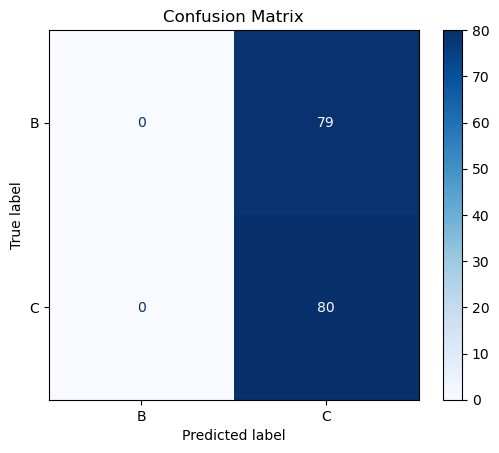

In [32]:
show_ht_metrics(model_bert_admw_ht, X_test, y_test, 'BERT with AdamW Optimizer')

#### Method 3 - Transformer BERT Classifier - Optimizer 3 - SGD with Momentum

This section creates BERT with SGD with momentum optimizer and show the results at the end.

In [33]:
study_bert_sgdm = run_hyperparameter_optimization(
    X_train, y_train, X_val, y_val, vocab_size,
    model='BERT', optimizer='SGDM', n_trials=20
)

[I 2025-06-12 20:42:49,440] A new study created in memory with name: BERT_SGDM_optimization


Starting hyperparameter optimization for BERT with SGDM
Running 20 trials...


  0%|          | 0/20 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 20:46:08,483] Trial 0 finished with value: 0.6012658227848102 and parameters: {'max_length': 78, 'dropout_rate': 0.11289712705419902, 'l2_reg': 0.0004159263968457398, 'dropout_rate_bert': 0.23844177036470504, 'dropout_rate_cd1': 0.38885356284039874, 'dropout_rate_cd2': 0.21462568705155302, 'dropout_rate_cd3': 0.3693958689890122, 'dropout_rate_cd4': 0.24037053275598394, 'l2_reg_bert': 0.007574445435855534, 'l2_reg_cd1': 2.386612550157962e-05, 'l2_reg_cd2': 0.002133141202493018, 'l2_reg_cd3': 0.00013461135314457112, 'learning_rate': 0.00025230212061521235, 'momentum': 0.9650457044423506, 'nesterov': True, 'clipvalue': 1.2054335634073203, 'epochs': 9, 'batch_size': 64, 'patience': 8}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 20:48:27,057] Trial 1 finished with value: 0.6012658227848102 and parameters: {'max_length': 71, 'dropout_rate': 0.3362696601344788, 'l2_reg': 0.0008116620692674805, 'dropout_rate_bert': 0.34854334448095364, 'dropout_rate_cd1': 0.4453845120439287, 'dropout_rate_cd2': 0.36858189977534506, 'dropout_rate_cd3': 0.17879574606812781, 'dropout_rate_cd4': 0.14944035010662998, 'l2_reg_bert': 2.7635282093132476e-05, 'l2_reg_cd1': 0.003669999992941383, 'l2_reg_cd2': 0.006390191607695244, 'l2_reg_cd3': 0.0007439265314679973, 'learning_rate': 0.00048610134689644534, 'momentum': 0.8322405066032089, 'nesterov': True, 'clipvalue': 1.819037414579795, 'epochs': 15, 'batch_size': 128, 'patience': 5}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 20:50:24,467] Trial 2 finished with value: 0.585485403240301 and parameters: {'max_length': 100, 'dropout_rate': 0.3047759016863335, 'l2_reg': 5.8494344362664035e-05, 'dropout_rate_bert': 0.331351129115945, 'dropout_rate_cd1': 0.23966052906378033, 'dropout_rate_cd2': 0.1138451142120081, 'dropout_rate_cd3': 0.3083610630320621, 'dropout_rate_cd4': 0.38930205486130276, 'l2_reg_bert': 8.677896926921987e-05, 'l2_reg_cd1': 0.00028735642865506907, 'l2_reg_cd2': 0.024969863466693616, 'l2_reg_cd3': 0.06471771522799034, 'learning_rate': 0.00028434378205749716, 'momentum': 0.8738879764554023, 'nesterov': True, 'clipvalue': 1.1029734095883568, 'epochs': 19, 'batch_size': 128, 'patience': 4}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 20:52:43,316] Trial 3 finished with value: 0.39226318649252384 and parameters: {'max_length': 83, 'dropout_rate': 0.4180336826471295, 'l2_reg': 0.02057477079745653, 'dropout_rate_bert': 0.4815529549480576, 'dropout_rate_cd1': 0.26527481346895077, 'dropout_rate_cd2': 0.4637083262118208, 'dropout_rate_cd3': 0.3349726132736928, 'dropout_rate_cd4': 0.15905880600311495, 'l2_reg_bert': 0.002062720512697134, 'l2_reg_cd1': 0.04100280764201069, 'l2_reg_cd2': 0.016142637673048525, 'l2_reg_cd3': 0.009736210633062554, 'learning_rate': 0.0004808721666499771, 'momentum': 0.9578676177464227, 'nesterov': True, 'clipvalue': 1.804199297044801, 'epochs': 23, 'batch_size': 128, 'patience': 5}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 20:55:38,282] Trial 4 finished with value: 0.5417349218168279 and parameters: {'max_length': 86, 'dropout_rate': 0.2427589411606098, 'l2_reg': 0.08076858646130344, 'dropout_rate_bert': 0.2380082415404531, 'dropout_rate_cd1': 0.392539489853463, 'dropout_rate_cd2': 0.2792943913796294, 'dropout_rate_cd3': 0.1840465280899724, 'dropout_rate_cd4': 0.23535056749857494, 'l2_reg_bert': 0.00010560348983738811, 'l2_reg_cd1': 4.221976447767104e-05, 'l2_reg_cd2': 0.009943779555655712, 'l2_reg_cd3': 0.03686931665307334, 'learning_rate': 0.00013533687639179687, 'momentum': 0.9707416887608482, 'nesterov': False, 'clipvalue': 1.5386746578856862, 'epochs': 13, 'batch_size': 16, 'patience': 4}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 20:57:57,850] Trial 5 finished with value: 0.6012658227848102 and parameters: {'max_length': 69, 'dropout_rate': 0.2716291452051075, 'l2_reg': 0.0014936681224543683, 'dropout_rate_bert': 0.46446538317956, 'dropout_rate_cd1': 0.4399025498772605, 'dropout_rate_cd2': 0.2856206077930713, 'dropout_rate_cd3': 0.24144211372264024, 'dropout_rate_cd4': 0.2095317270488214, 'l2_reg_bert': 0.0006056706895278182, 'l2_reg_cd1': 0.00014435025964577264, 'l2_reg_cd2': 0.0715284846219332, 'l2_reg_cd3': 0.00016870965197157234, 'learning_rate': 0.03973859525326934, 'momentum': 0.9482972511544085, 'nesterov': True, 'clipvalue': 1.4018924295521238, 'epochs': 19, 'batch_size': 16, 'patience': 3}. Best is trial 0 with value: 0.6012658227848102.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 21:00:23,096] Trial 6 finished with value: 0.6079844206426486 and parameters: {'max_length': 48, 'dropout_rate': 0.12861860510005926, 'l2_reg': 0.014334260904292353, 'dropout_rate_bert': 0.35893160373437216, 'dropout_rate_cd1': 0.16898957672573112, 'dropout_rate_cd2': 0.25981149276835486, 'dropout_rate_cd3': 0.1598382132181044, 'dropout_rate_cd4': 0.487927144333283, 'l2_reg_bert': 0.04577198003919621, 'l2_reg_cd1': 7.988735222662631e-05, 'l2_reg_cd2': 0.015534107566760167, 'l2_reg_cd3': 4.173935743597168e-05, 'learning_rate': 0.0005276482037987, 'momentum': 0.8897574399215803, 'nesterov': True, 'clipvalue': 1.1772553885848462, 'epochs': 8, 'batch_size': 16, 'patience': 3}. Best is trial 6 with value: 0.6079844206426486.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 21:03:09,120] Trial 7 finished with value: 0.2278481012658228 and parameters: {'max_length': 81, 'dropout_rate': 0.4051987613126229, 'l2_reg': 0.025258276888179058, 'dropout_rate_bert': 0.4630513109365033, 'dropout_rate_cd1': 0.3455432076903828, 'dropout_rate_cd2': 0.4167121919619359, 'dropout_rate_cd3': 0.10762408138419484, 'dropout_rate_cd4': 0.3755359725150864, 'l2_reg_bert': 0.004053407392054632, 'l2_reg_cd1': 3.334693072506462e-05, 'l2_reg_cd2': 0.0016279349390046407, 'l2_reg_cd3': 1.456288929412289e-05, 'learning_rate': 0.03784748866402022, 'momentum': 0.9588832578520718, 'nesterov': False, 'clipvalue': 1.486176953495024, 'epochs': 17, 'batch_size': 64, 'patience': 5}. Best is trial 6 with value: 0.6079844206426486.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 21:04:52,868] Trial 8 finished with value: 0.40108826393264224 and parameters: {'max_length': 16, 'dropout_rate': 0.29844408276482604, 'l2_reg': 0.07504562286381877, 'dropout_rate_bert': 0.23407064658400767, 'dropout_rate_cd1': 0.4264371012009365, 'dropout_rate_cd2': 0.20393628626509744, 'dropout_rate_cd3': 0.43514912476768886, 'dropout_rate_cd4': 0.4127039626858876, 'l2_reg_bert': 0.07352024098017396, 'l2_reg_cd1': 0.0005390541398363648, 'l2_reg_cd2': 0.00019422377660916572, 'l2_reg_cd3': 0.024119020679154373, 'learning_rate': 0.002223112917088795, 'momentum': 0.9743590576423335, 'nesterov': False, 'clipvalue': 0.8969471788660781, 'epochs': 8, 'batch_size': 128, 'patience': 3}. Best is trial 6 with value: 0.6079844206426486.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 21:08:19,017] Trial 9 finished with value: 0.6012658227848102 and parameters: {'max_length': 28, 'dropout_rate': 0.2895146350856681, 'l2_reg': 0.0015302124080394236, 'dropout_rate_bert': 0.4712082797804116, 'dropout_rate_cd1': 0.2032189001037178, 'dropout_rate_cd2': 0.1572291927921212, 'dropout_rate_cd3': 0.4747659314218188, 'dropout_rate_cd4': 0.43239409583405986, 'l2_reg_bert': 0.019506021810903853, 'l2_reg_cd1': 0.026594230459906498, 'l2_reg_cd2': 0.00010436036723892313, 'l2_reg_cd3': 0.0009278946549328206, 'learning_rate': 0.00011929780289241097, 'momentum': 0.8406840716644294, 'nesterov': True, 'clipvalue': 1.2673064696495704, 'epochs': 13, 'batch_size': 32, 'patience': 6}. Best is trial 6 with value: 0.6079844206426486.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 21:12:25,467] Trial 10 finished with value: 0.5961382715041973 and parameters: {'max_length': 45, 'dropout_rate': 0.1153432228474806, 'l2_reg': 1.0318597122407555e-05, 'dropout_rate_bert': 0.10304857478773066, 'dropout_rate_cd1': 0.13337750524488332, 'dropout_rate_cd2': 0.34574092470018153, 'dropout_rate_cd3': 0.10818729436123059, 'dropout_rate_cd4': 0.495448056940764, 'l2_reg_bert': 0.07061741388448399, 'l2_reg_cd1': 0.0032187948425148392, 'l2_reg_cd2': 0.0005342543399700345, 'l2_reg_cd3': 1.4119658578375772e-05, 'learning_rate': 0.0035429136008143327, 'momentum': 0.9034039505814533, 'nesterov': False, 'clipvalue': 0.5124354935114088, 'epochs': 30, 'batch_size': 16, 'patience': 7}. Best is trial 6 with value: 0.6079844206426486.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 21:14:40,324] Trial 11 finished with value: 0.38090780616043884 and parameters: {'max_length': 51, 'dropout_rate': 0.11471439819357104, 'l2_reg': 0.00018048857416385307, 'dropout_rate_bert': 0.2668489215460183, 'dropout_rate_cd1': 0.13479733405835262, 'dropout_rate_cd2': 0.22647049203432157, 'dropout_rate_cd3': 0.3817243943723623, 'dropout_rate_cd4': 0.29771079314255094, 'l2_reg_bert': 0.00947191227259837, 'l2_reg_cd1': 2.6849984590930718e-05, 'l2_reg_cd2': 0.001848067239304176, 'l2_reg_cd3': 0.00010781803197631705, 'learning_rate': 0.0017034161932904714, 'momentum': 0.9053616535989035, 'nesterov': True, 'clipvalue': 0.933679668368296, 'epochs': 5, 'batch_size': 64, 'patience': 8}. Best is trial 6 with value: 0.6079844206426486.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 21:18:05,950] Trial 12 finished with value: 0.5937283267737474 and parameters: {'max_length': 39, 'dropout_rate': 0.18921909795793343, 'l2_reg': 0.005728855718289247, 'dropout_rate_bert': 0.17242421603291969, 'dropout_rate_cd1': 0.3234472532888639, 'dropout_rate_cd2': 0.21671218696220576, 'dropout_rate_cd3': 0.37715048457809647, 'dropout_rate_cd4': 0.28501996477209274, 'l2_reg_bert': 0.019109849514869773, 'l2_reg_cd1': 1.2230574883943255e-05, 'l2_reg_cd2': 2.7355569682141526e-05, 'l2_reg_cd3': 8.158085920985786e-05, 'learning_rate': 0.0008054569640168239, 'momentum': 0.9275275730553103, 'nesterov': True, 'clipvalue': 0.7680741565674835, 'epochs': 8, 'batch_size': 64, 'patience': 8}. Best is trial 6 with value: 0.6079844206426486.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 21:21:53,507] Trial 13 finished with value: 0.5350025774672089 and parameters: {'max_length': 61, 'dropout_rate': 0.18210677009803655, 'l2_reg': 0.0002601369851748188, 'dropout_rate_bert': 0.39402047698900167, 'dropout_rate_cd1': 0.4954607668467168, 'dropout_rate_cd2': 0.27296313350769164, 'dropout_rate_cd3': 0.2660812125428829, 'dropout_rate_cd4': 0.10343087463312178, 'l2_reg_bert': 0.0007567379157925302, 'l2_reg_cd1': 0.00011033179656814368, 'l2_reg_cd2': 0.0032774936992105504, 'l2_reg_cd3': 4.765910674096735e-05, 'learning_rate': 0.009777649369106274, 'momentum': 0.8712135687142656, 'nesterov': True, 'clipvalue': 1.1530036559854404, 'epochs': 9, 'batch_size': 32, 'patience': 7}. Best is trial 6 with value: 0.6079844206426486.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 21:24:13,703] Trial 14 finished with value: 0.5730785707728556 and parameters: {'max_length': 59, 'dropout_rate': 0.1780378079333073, 'l2_reg': 0.005852037665353472, 'dropout_rate_bert': 0.4026189116693303, 'dropout_rate_cd1': 0.1809265548848605, 'dropout_rate_cd2': 0.1695586955217294, 'dropout_rate_cd3': 0.19227003066391346, 'dropout_rate_cd4': 0.33839481685237516, 'l2_reg_bert': 0.007403051051256938, 'l2_reg_cd1': 0.0017329913934280732, 'l2_reg_cd2': 0.09179160743720931, 'l2_reg_cd3': 0.0003005301789763075, 'learning_rate': 0.0008769357816221503, 'momentum': 0.9279121865107245, 'nesterov': True, 'clipvalue': 1.6100200652213394, 'epochs': 5, 'batch_size': 64, 'patience': 6}. Best is trial 6 with value: 0.6079844206426486.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 21:28:19,122] Trial 15 finished with value: 0.3952028643399186 and parameters: {'max_length': 31, 'dropout_rate': 0.49140340979768, 'l2_reg': 0.005319918155809252, 'dropout_rate_bert': 0.17954347601980647, 'dropout_rate_cd1': 0.36634598879323044, 'dropout_rate_cd2': 0.35187308087526475, 'dropout_rate_cd3': 0.38230972623393844, 'dropout_rate_cd4': 0.24544281108512944, 'l2_reg_bert': 0.0295480762434075, 'l2_reg_cd1': 1.2576785473399853e-05, 'l2_reg_cd2': 0.0005499255121496676, 'l2_reg_cd3': 0.004932077706052455, 'learning_rate': 0.0002427519342689464, 'momentum': 0.8686367204159019, 'nesterov': True, 'clipvalue': 1.2881814761212156, 'epochs': 10, 'batch_size': 16, 'patience': 7}. Best is trial 6 with value: 0.6079844206426486.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 21:31:01,030] Trial 16 finished with value: 0.2278481012658228 and parameters: {'max_length': 100, 'dropout_rate': 0.10031523692183288, 'l2_reg': 0.0004926396439059781, 'dropout_rate_bert': 0.30164265872241114, 'dropout_rate_cd1': 0.2794826483440986, 'dropout_rate_cd2': 0.24622496074773118, 'dropout_rate_cd3': 0.250155866443277, 'dropout_rate_cd4': 0.49492311328438254, 'l2_reg_bert': 0.002149301489289945, 'l2_reg_cd1': 9.800968405873478e-05, 'l2_reg_cd2': 0.024452688378165586, 'l2_reg_cd3': 0.00038139999487156896, 'learning_rate': 0.007130894203297985, 'momentum': 0.9250635843282176, 'nesterov': True, 'clipvalue': 0.9760365616432158, 'epochs': 23, 'batch_size': 16, 'patience': 4}. Best is trial 6 with value: 0.6079844206426486.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 21:34:47,998] Trial 17 finished with value: 0.369210722263589 and parameters: {'max_length': 73, 'dropout_rate': 0.15434208885837733, 'l2_reg': 2.867397468731505e-05, 'dropout_rate_bert': 0.3979963759223379, 'dropout_rate_cd1': 0.2038822427807058, 'dropout_rate_cd2': 0.3249326049015977, 'dropout_rate_cd3': 0.4347022091664422, 'dropout_rate_cd4': 0.34161479453232013, 'l2_reg_bert': 0.09888417804824717, 'l2_reg_cd1': 0.0006084731063862763, 'l2_reg_cd2': 0.004436099635878033, 'l2_reg_cd3': 3.490101488224828e-05, 'learning_rate': 0.09508654838420522, 'momentum': 0.8004390663008585, 'nesterov': True, 'clipvalue': 0.6843818381206564, 'epochs': 11, 'batch_size': 64, 'patience': 8}. Best is trial 6 with value: 0.6079844206426486.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 21:36:48,808] Trial 18 finished with value: 0.6012658227848102 and parameters: {'max_length': 13, 'dropout_rate': 0.23011414709882705, 'l2_reg': 0.00010617899478279356, 'dropout_rate_bert': 0.3519316126993435, 'dropout_rate_cd1': 0.3069372413606153, 'dropout_rate_cd2': 0.10369853514584965, 'dropout_rate_cd3': 0.32728022482056296, 'dropout_rate_cd4': 0.4552496859426476, 'l2_reg_bert': 0.00037432596037138545, 'l2_reg_cd1': 3.8953414193010854e-05, 'l2_reg_cd2': 0.0006067650386106406, 'l2_reg_cd3': 0.002592674887717863, 'learning_rate': 0.0011342255204461085, 'momentum': 0.9860266601892256, 'nesterov': False, 'clipvalue': 1.9792616576206274, 'epochs': 5, 'batch_size': 32, 'patience': 3}. Best is trial 6 with value: 0.6079844206426486.


c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

[I 2025-06-12 21:39:51,628] Trial 19 finished with value: 0.5892351877459845 and parameters: {'max_length': 51, 'dropout_rate': 0.1544069230935696, 'l2_reg': 0.0025328221606726754, 'dropout_rate_bert': 0.19179309773799916, 'dropout_rate_cd1': 0.10343775535333655, 'dropout_rate_cd2': 0.18505363879903117, 'dropout_rate_cd3': 0.142355760911293, 'dropout_rate_cd4': 0.18587755786210505, 'l2_reg_bert': 0.03018146408455916, 'l2_reg_cd1': 0.0001822004655672928, 'l2_reg_cd2': 0.04042879337619538, 'l2_reg_cd3': 3.2158412043814954e-05, 'learning_rate': 0.00024638789303867083, 'momentum': 0.8896447705735335, 'nesterov': True, 'clipvalue': 1.0648621305410015, 'epochs': 12, 'batch_size': 64, 'patience': 6}. Best is trial 6 with value: 0.6079844206426486.

Optimization completed!
Best trial: 6
Best combined score: 0.6080
Best parameters: {'max_length': 48, 'dropout_rate': 0.12861860510005926, 'l2_reg': 0.014334260904292353, 'dropout_rate_bert': 0.35893160373437216, 'dropout_rate_cd1': 0.1689895767257

In [34]:
model_bert_sgdm_ht, history_bert_sgdm_ht = create_model(study_bert_sgdm, 'BERT', 'SGDM')

c:\ProgramData\anaconda3\envs\NLP2_Project1\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical 

Starting training...
Epoch 1/8
35/35 [==============================] - 43s 936ms/step - loss: 6.0616 - accuracy: 0.4647 - val_loss: 0.0000e+00 - val_accuracy: 0.5190 - lr: 5.2765e-04
Epoch 2/8
35/35 [==============================] - 28s 796ms/step - loss: 5.9803 - accuracy: 0.5118 - val_loss: 0.0000e+00 - val_accuracy: 0.4304 - lr: 5.2765e-04
Epoch 3/8
35/35 [==============================] - ETA: 0s - loss: 5.9360 - accuracy: 0.5009
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002638240985106677.
35/35 [==============================] - 28s 815ms/step - loss: 5.9360 - accuracy: 0.5009 - val_loss: 0.0000e+00 - val_accuracy: 0.4304 - lr: 5.2765e-04
Epoch 4/8
35/35 [==============================] - 28s 811ms/step - loss: 5.8896 - accuracy: 0.4901 - val_loss: 0.0000e+00 - val_accuracy: 0.4304 - lr: 2.6382e-04
Epoch 4: early stopping


5/5 [==============================] - 8s 1s/step

Metrics for FFNN with Adam Optimizer:
Accuracy: 0.5094
Precision: 0.5070
Recall: 0.9000
F1 Score: 0.6486


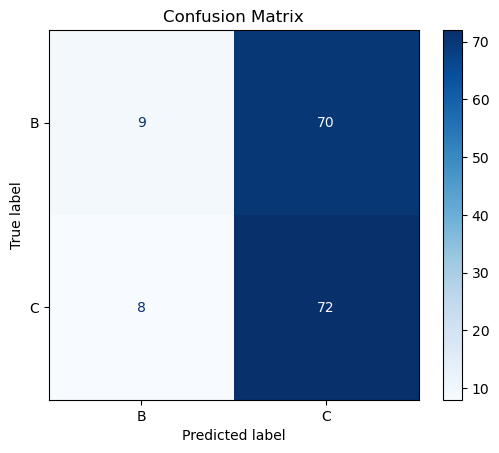

In [35]:
show_ht_metrics(model_bert_sgdm_ht, X_test, y_test, 'BERT with SGDM Optimizer')

## 5.Comparison of the Results of Different Approaches

**FFNN**

The metrics for the regular process are acceptable overall. The most balanced optimizer is Adam, giving the most equity results. The AdamW optimizer presents the worst results, showing unbalanced confusion metrics values to the B result. The general metrics of SGDM is not widely different of Adam but with the same problem in confusion matrix as AdamW. The hyperparameter tuning process didn't improved significantly the results of the optimizers. The best tuned model is Adam again. Thus, in this model, Adam optimizer is the best overal.

**LSTM**

The metrics for the regular process are poor. The only optimizer to get real metrics is AdamW with weak results. For Adam and SGDM, false posivites and true negatives are zero, thus, the calculation for precision, recall, and in consequence F1 score were zero. The hyperparameter tuning improved the previous optimizer, getting true values for metrics. However, AdamW is still the best optimizer overall, getting better metrics and more balanced results in the confusion matrix.

**BERT**

The metrics for both, regular and tuned process are the worst. For accuracy, precision, recall, and F1 score, both processes return similar results, not improving the result even with the tuning process. The same situation shows with the confusion matrix, only changing the values from left to right side, keeping the low numbers in both cases.


## 6.Conclusions

At the beginning of my research, I decided to build the models guided for the information gathered to create architectures two or three steps above the classic classification task. The first models implemented were based on the concept that a bidirectional approach and a transformers embedding layer based on BERT can generate better embeddings because of their bidirectional approach, the attention process, and the improved embedding generation that represents much better the essays. However, the results were below the worst from the present project. The present models is a result of two 'downgrades' from the original models. Both implementations (bidirectional and BERT embedding) were taken out, and surprisingly, the first two models improved. About the BERT case, it keeps the transformers implementation, and considering the results, it is verified that this approach is not the best fit.

Hyperparamter tuning really matters to get insights of the models. The LSTM metrics got an upgrade up after the tuning process. Despite that the process was intensive (almost 30 minutes per optimizer), it solved the bad calculations of the confusion matrix. In this case, digging deep into the tuning, better metrics can be achieved. On the other hand, BERT doesn't improve with any of the optimizers. In addition, for each optimizsr, the tuning process took over an hour to finish and get the hyperparameters, which were not the best for the model. Therefore, this model is not a good fit to build the classifier.

## References

- British Council. (2023, May 1). Writing Band Descriptors.
- Team, K. (n.d.). Keras Documentation: Adam. Keras - Adam. https://keras.io/api/optimizers/adam/
- Team, K. (n.d.-a). Keras Documentation: ADAMW. https://keras.io/api/optimizers/adamw/ 
- Team, K. (n.d.). Keras documentation: Optimizers. Keras - Optimizers. https://keras.io/api/optimizers/
- Team, K. (n.d.-c). Keras Documentation: SGD. https://keras.io/api/optimizers/sgd/ 